### crop ROI --> bg cleaned --> augmented 

In [2]:
import os
import cv2
import pandas as pd

def crop_roi(image_dirs, annotation_csvs, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_dir, csv_path in zip(image_dirs, annotation_csvs):
        df = pd.read_csv(csv_path)
        for idx, row in df.iterrows():
            filename = row['filename']
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            img_path = os.path.join(img_dir, filename)
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                crop = img[ymin:ymax, xmin:xmax]
                out_path = os.path.join(output_dir, filename)
                cv2.imwrite(out_path, crop)
            else:
                print(f"Image not found: {img_path}")

In [3]:
image_dirs = [
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\valid",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\train",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\test"
]
annotation_csvs = [
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\valid\annotations.csv",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\train\_annotations.csv",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\test\annotations.csv"
]
output_dir = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\01_crop_roi"

crop_roi(image_dirs, annotation_csvs, output_dir)

In [4]:
import os
import shutil
import pandas as pd

def move_by_class(image_dir, annotation_csvs, output_dir, class_map):
    dfs = []
    for csv in annotation_csvs:
        df = pd.read_csv(csv)
        dfs.append(df)
    all_annots = pd.concat(dfs, ignore_index=True)
    
    filename2class = dict(zip(all_annots['filename'], all_annots['class']))
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = filename2class.get(filename, None)
            if label is None:
                print(f"Skip, {filename} is not found")
                continue
            folder = class_map.get(label, label)
            dest_folder = os.path.join(output_dir, folder)
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            src_path = os.path.join(image_dir, filename)
            dest_path = os.path.join(dest_folder, filename)
            shutil.move(src_path, dest_path)

image_dir = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\01_crop_roi"
annotation_csvs = [
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\valid\annotations.csv",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\train\_annotations.csv",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\raw\test\annotations.csv"
]
output_dir = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\01_crop_roi"
class_map = {
    'ripe mango': 'ripe',
    'raw mango': 'unripe'
}

move_by_class(image_dir, annotation_csvs, output_dir, class_map)


In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def remove_bg(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Cannot read {image_path}")
        return None

    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    height, width = image.shape[:2]
    rect = (10, 10, width - 20, height - 20)
    try:
        cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    except Exception as e:
        print(f"grabCut failed on {image_path}: {e}")
        return None
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img_fg = image * mask2[:, :, np.newaxis]
    b, g, r = cv2.split(img_fg)
    alpha = mask2 * 255
    rgba = cv2.merge([b, g, r, alpha])
    return rgba

def bg_process_all_images(input_root, output_root):
    for subfolder in os.listdir(input_root):
        input_dir = os.path.join(input_root, subfolder)
        if not os.path.isdir(input_dir):
            continue
        output_dir = os.path.join(output_root, subfolder)
        os.makedirs(output_dir, exist_ok=True)
        files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for filename in tqdm(files, desc=f"Removing bg on {subfolder} "):
            img_path = os.path.join(input_dir, filename)
            result_rgba = remove_bg(img_path)
            if result_rgba is None:
                print(f"Warning: No object found in {img_path}")
                continue
            out_name = os.path.splitext(filename)[0] + ".png"
            out_path = os.path.join(output_dir, out_name)
            cv2.imwrite(out_path, result_rgba)

input_root = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\01_crop_roi"
output_root = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\02_cleaned"

bg_process_all_images(input_root, output_root)


Removing bg on unripe : 100%|██████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.98it/s]


In [6]:
from augmentation import augment_images_albumentations

augment_num_per_image_dict = {
    'unripe':5 ,
    'ripe': 5
}

input_folders = [
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\02_cleaned\ripe",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\02_cleaned\unripe",
]

output_folder = r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\03_augmented"

augment_images_albumentations(input_folders, output_folder, augment_num_per_image_dict)

In [7]:
from feature_extraction import (extract_rgb_his, extract_lab, extract_glcm, extract_lbp)

image_dirs = [
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\03_augmented\ripe",
    r"C:\Users\User\Desktop\FYP\Dataset\mango_2\processed\03_augmented\unripe"
]

In [8]:
extract_rgb_his(image_dirs, 
                        rgb_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_features.csv",
                        his_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_features.csv",
                        dataset="mango_2",
                        resize=(128,128))

Processing 'mango_2' (RGB+HIS)...


unripe: 100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 117.20it/s]

RGB values for mango_2 saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_features.csv, HIS values for mango_2 saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_features.csv


In [9]:
extract_lab(image_dirs, 
            save_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_features.csv", 
            dataset="mango_2",
           resize=(128,128))

Processing 'mango_2' (Lab)...


unripe: 100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 216.35it/s]

LAB values for mango_2 saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_features.csv


In [10]:
extract_lbp(image_dirs, 
            save_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_features.csv",
            dataset="mango_2", 
            resize=(128,128))

Processing 'mango_2' (LBP)...


unripe: 100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 214.48it/s]

LBP values for mango_2 saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_features.csv


In [11]:
extract_glcm(image_dirs, 
             save_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_features.csv", 
            dataset="mango_2",
            resize=(128,128))

Processing 'mango_2' (GLCM, angles=[0])...


unripe: 100%|███████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 249.88it/s]

GLCM values for mango_2 (angles=[0]) saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_features.csv


## Split test train class

In [13]:
from knn_classification import split_per_class

split_per_class(
    csv_path=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_features.csv",
    train_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_train.csv",
    test_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_test.csv",
    feature="128x128_mango_2_rgb"
)

split_per_class(
    csv_path=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_features.csv",
    train_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_train.csv",
    test_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_test.csv",
    feature="128x1284_mango_2_his"
)

split_per_class(
    csv_path=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_features.csv",
    train_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_train.csv",
    test_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_test.csv",
    feature="128x128_mango_2_lab"
)

split_per_class(
    csv_path=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_features.csv",
    train_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_train.csv",
    test_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_test.csv",
    feature="128x128_mango_2_lbp"
)

split_per_class(
    csv_path=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_features.csv",
    train_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_train.csv",
    test_output=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_test.csv",
    feature="128x128_mango_2_glcm"
)

 Train set for 128x128_mango_2_rgb saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_train.csv (660 samples)
 Test set for 128x128_mango_2_rgb saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_test.csv (165 samples)
 Train set for 128x1284_mango_2_his saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_train.csv (660 samples)
 Test set for 128x1284_mango_2_his saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_test.csv (165 samples)
 Train set for 128x128_mango_2_lab saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_train.csv (660 samples)
 Test set for 128x128_mango_2_lab saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_test.csv (165 samples)
 Train set for 128x128_mango_2_lbp saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_train.csv (660 samples)
 Test set for 128x128_mango_2_lbp saved in C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_test.csv (165 samples)
 Train set for 128x128_mango_2

## KNN = 1,3,5,7


--- KNN (k=1) on 128x128_mango2_rgb Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0020 seconds


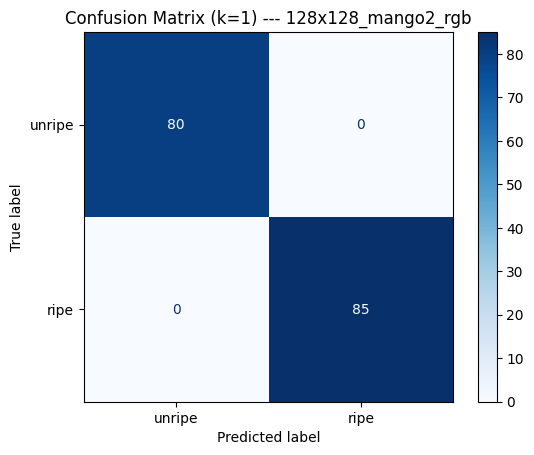

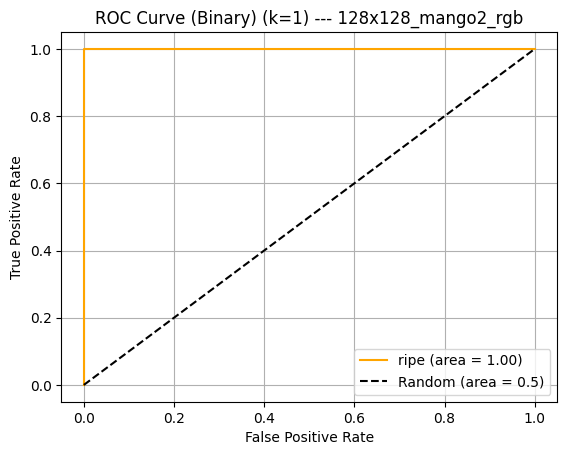


--- KNN (k=3) on 128x128_mango2_rgb Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0015 seconds


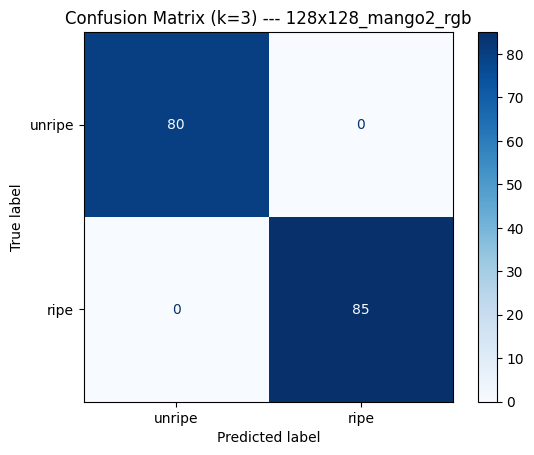

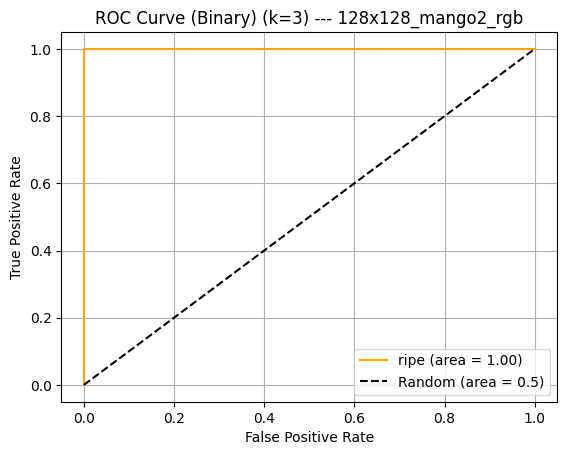


--- KNN (k=5) on 128x128_mango2_rgb Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0022 seconds


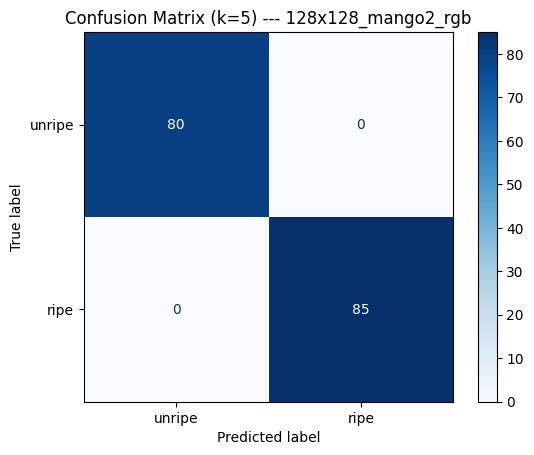

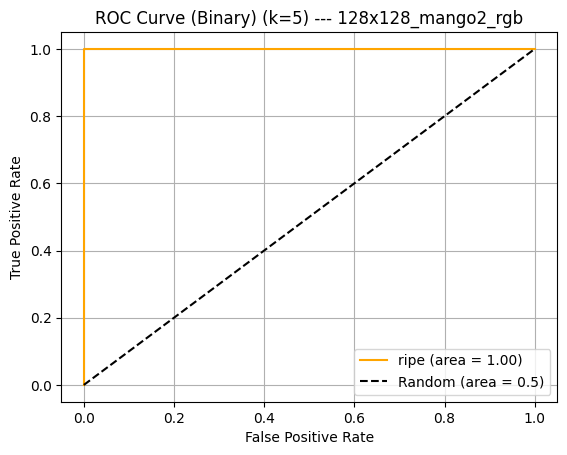


--- KNN (k=7) on 128x128_mango2_rgb Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


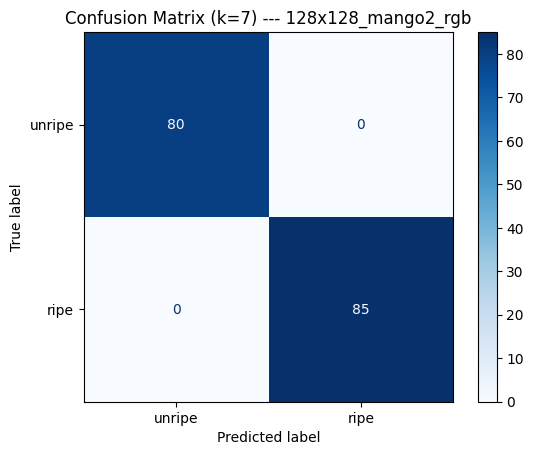

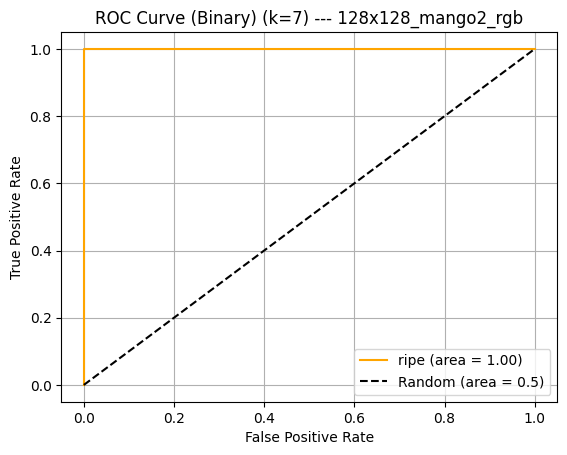


--- KNN (k=10) on 128x128_mango2_rgb Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


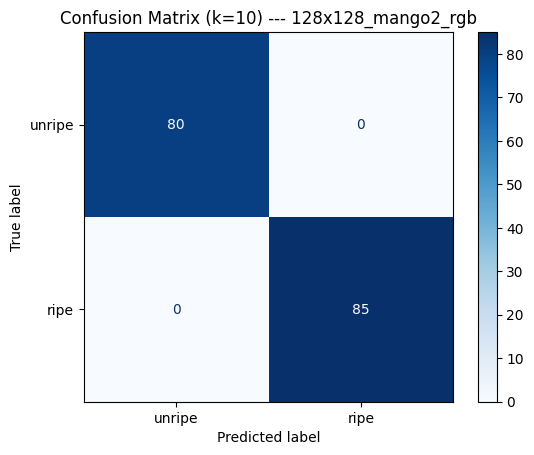

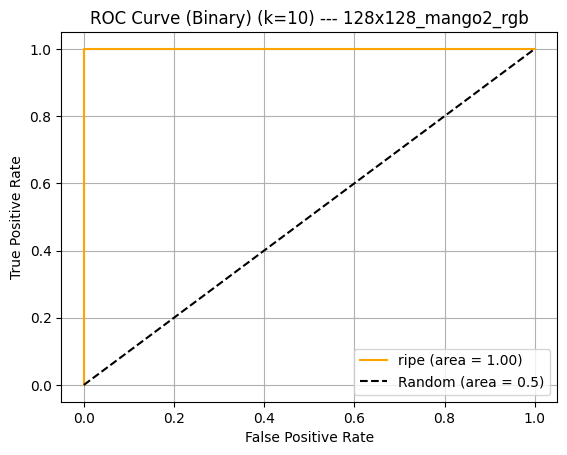

Results saved to knn_k_comparison_metrics.csv


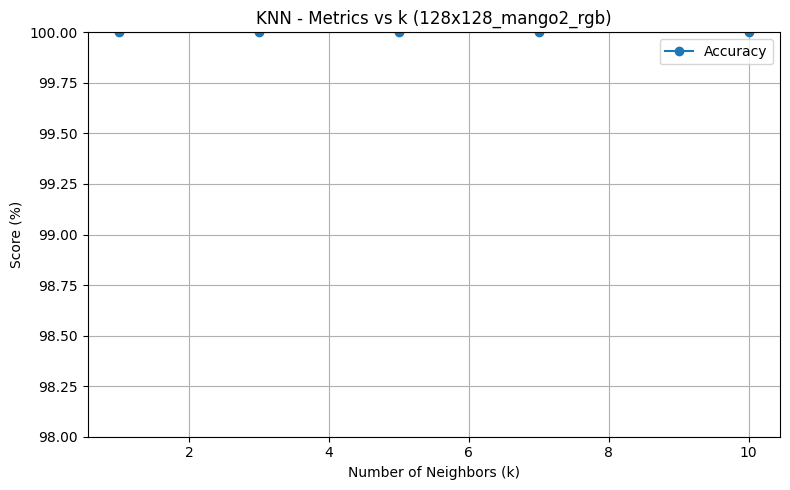

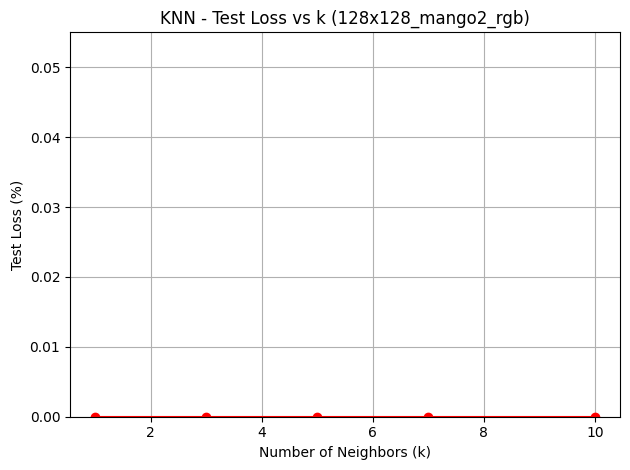

k  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  Test Loss (%)  \
0   1         100.0          100.0       100.0         100.0            0.0   
1   3         100.0          100.0       100.0         100.0            0.0   
2   5         100.0          100.0       100.0         100.0            0.0   
3   7         100.0          100.0       100.0         100.0            0.0   
4  10         100.0          100.0       100.0         100.0            0.0   

   Training Time (s)  
0           0.002000  
1           0.001504  
2           0.002230  
3           0.001000  
4           0.001000

In [15]:
from knn_classification import knn_classification

knn_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_test.csv",
    feature="128x128_mango2_rgb",
    class_order=['unripe', 'ripe']
)



--- KNN (k=1) on 128x128_mango2_his Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


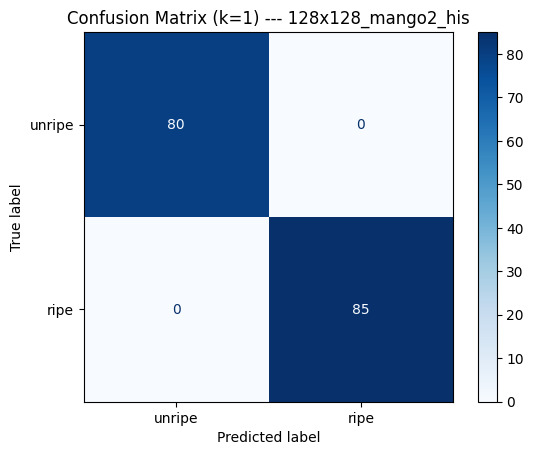

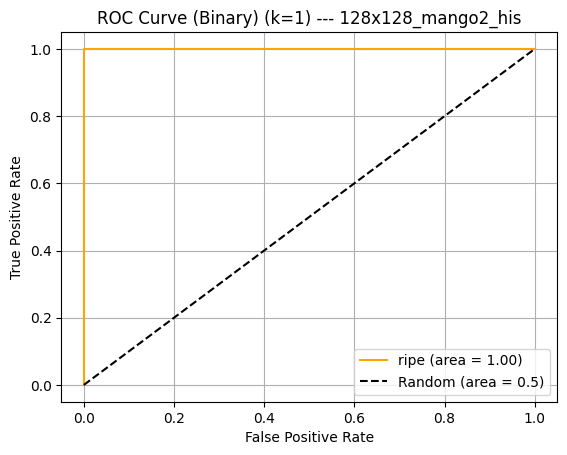


--- KNN (k=3) on 128x128_mango2_his Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


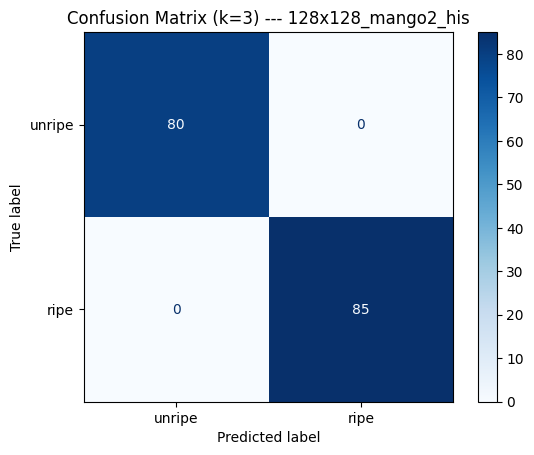

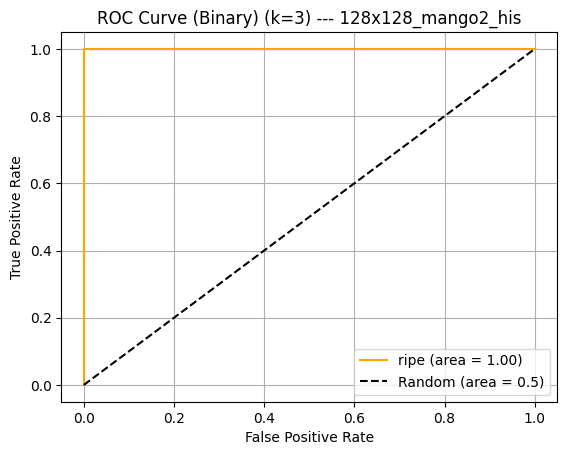


--- KNN (k=5) on 128x128_mango2_his Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


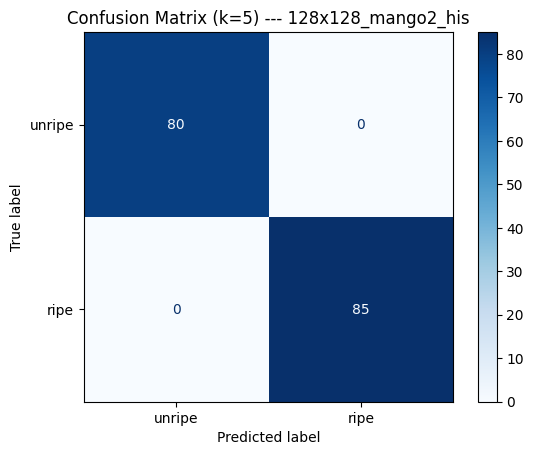

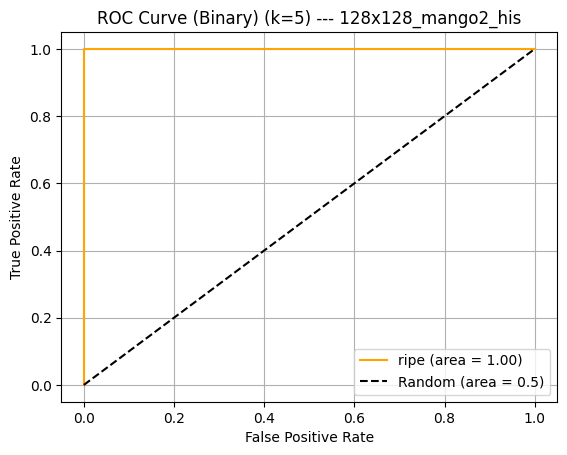


--- KNN (k=7) on 128x128_mango2_his Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.0020 seconds


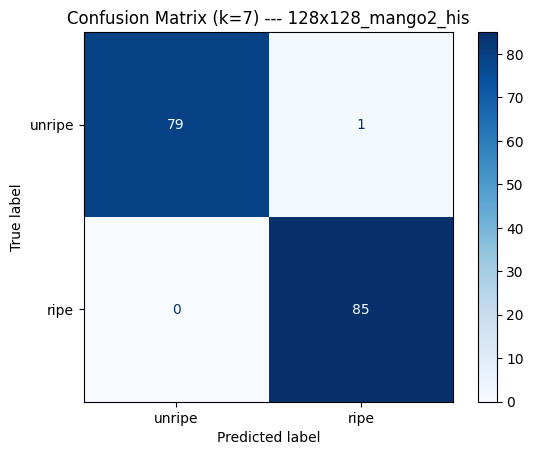

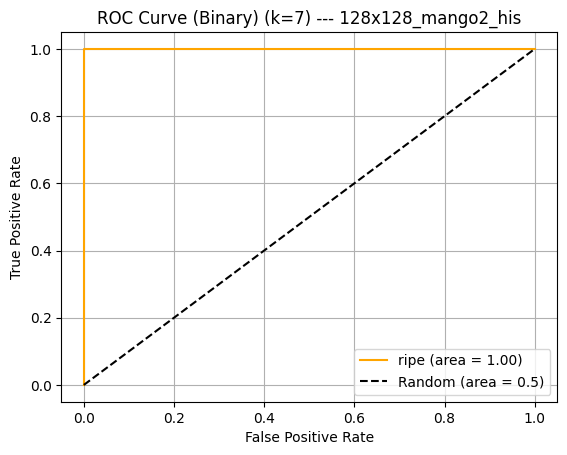


--- KNN (k=10) on 128x128_mango2_his Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.0020 seconds


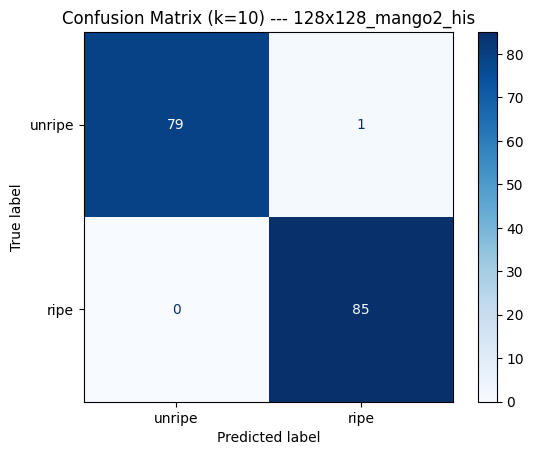

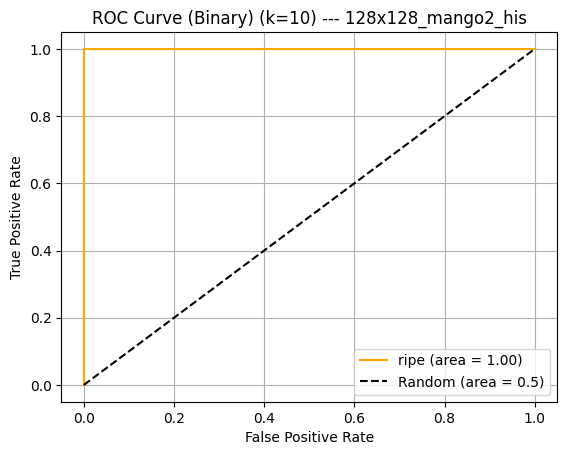

Results saved to knn_k_comparison_metrics.csv


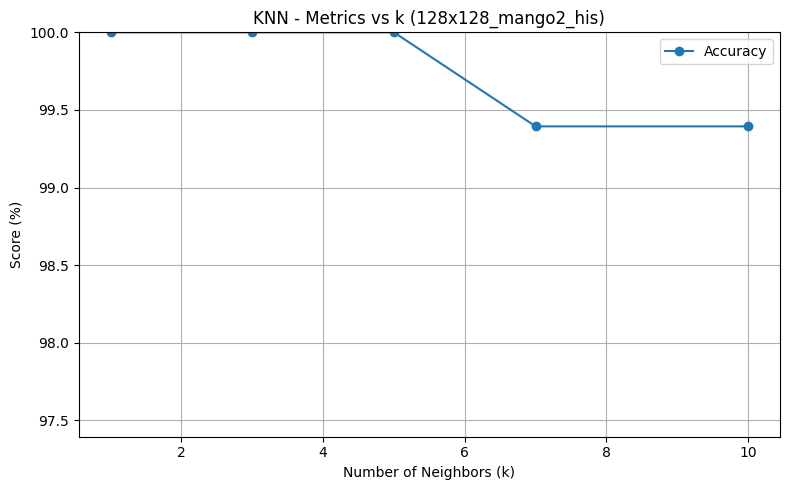

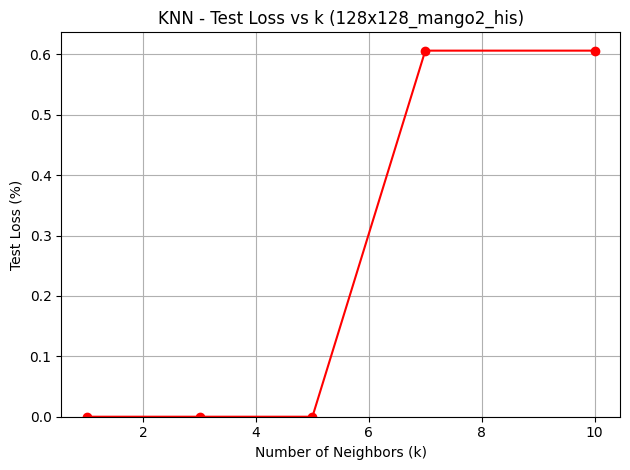

k  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  Test Loss (%)  \
0   1    100.000000     100.000000  100.000000    100.000000       0.000000   
1   3    100.000000     100.000000  100.000000    100.000000       0.000000   
2   5    100.000000     100.000000  100.000000    100.000000       0.000000   
3   7     99.393939      99.400987   99.393939     99.393806       0.606061   
4  10     99.393939      99.400987   99.393939     99.393806       0.606061   

   Training Time (s)  
0           0.001000  
1           0.001000  
2           0.001000  
3           0.002000  
4           0.002001

In [16]:
from knn_classification import knn_classification

knn_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_test.csv",
    feature="128x128_mango2_his",
   class_order=['unripe', 'ripe']
)



--- KNN (k=1) on 128x128_mango2_lab Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


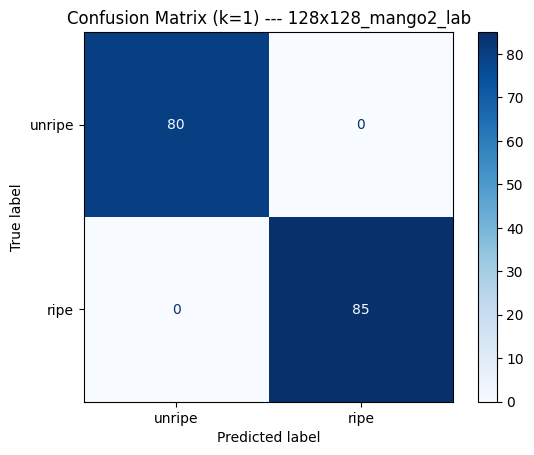

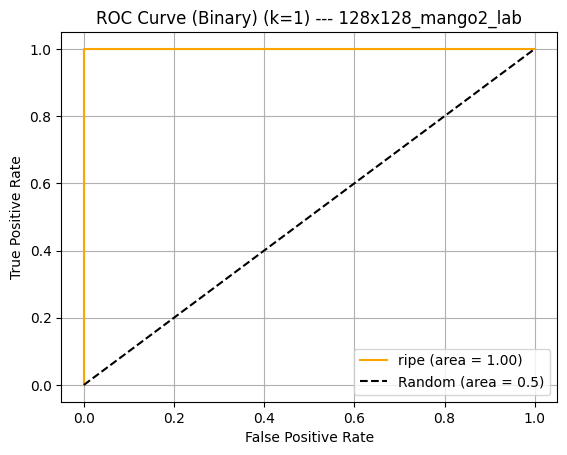


--- KNN (k=3) on 128x128_mango2_lab Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


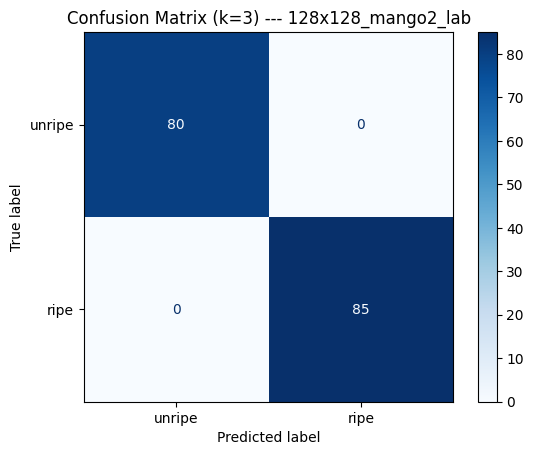

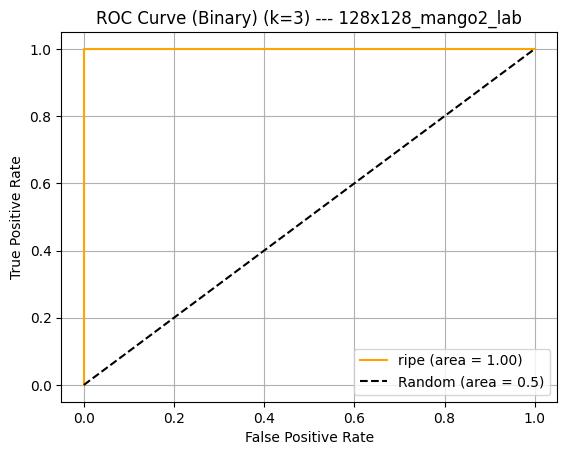


--- KNN (k=5) on 128x128_mango2_lab Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0020 seconds


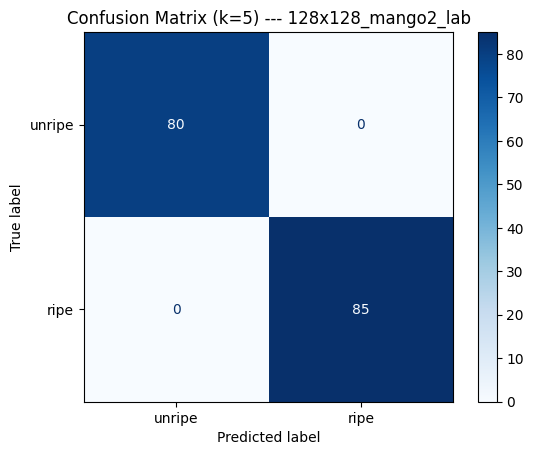

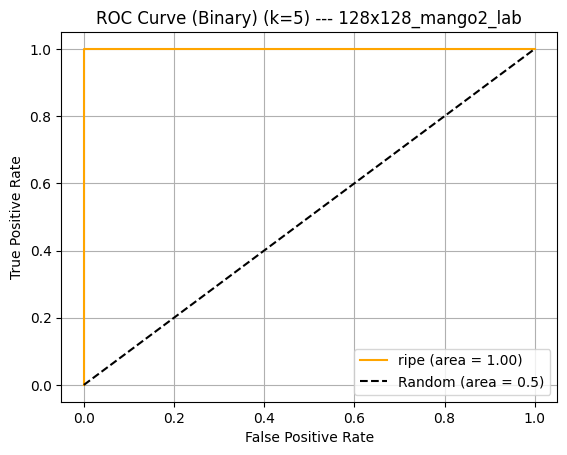


--- KNN (k=7) on 128x128_mango2_lab Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


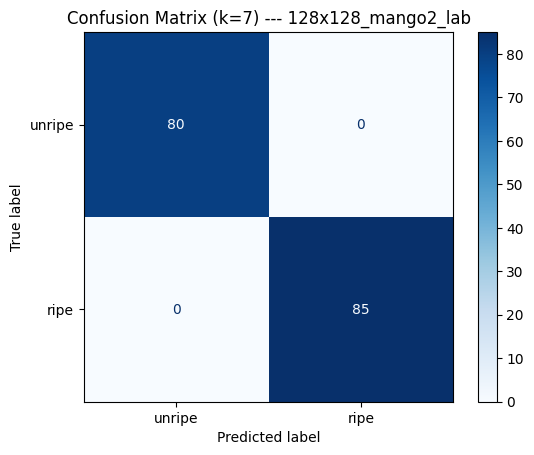

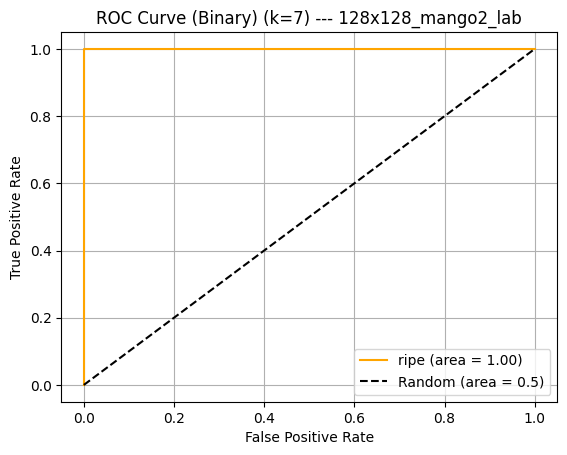


--- KNN (k=10) on 128x128_mango2_lab Feature ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0010 seconds


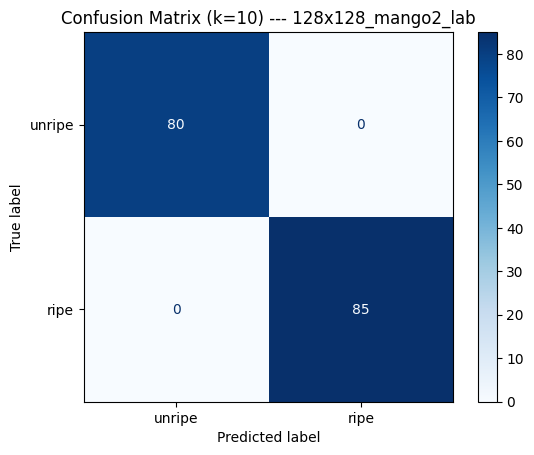

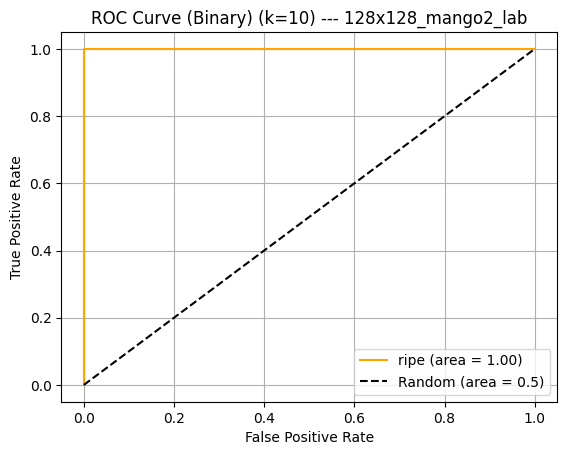

Results saved to knn_k_comparison_metrics.csv


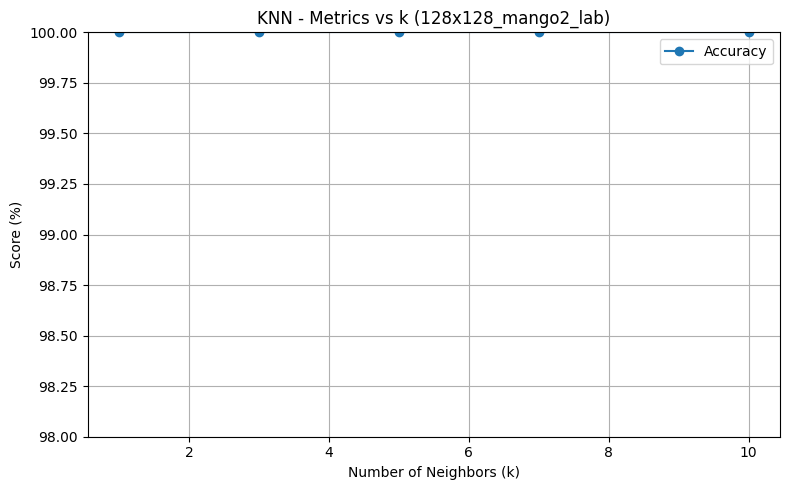

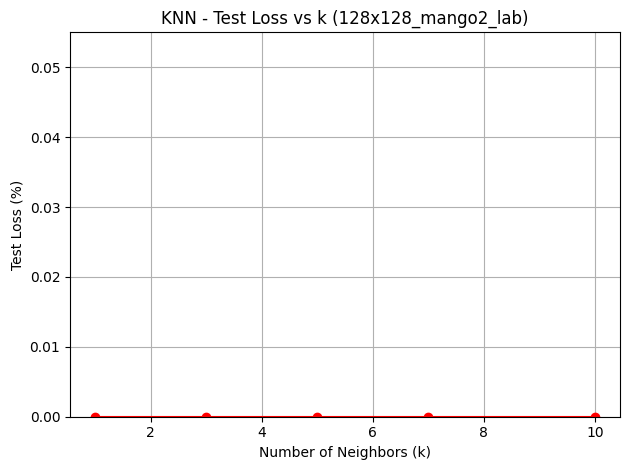

k  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  Test Loss (%)  \
0   1         100.0          100.0       100.0         100.0            0.0   
1   3         100.0          100.0       100.0         100.0            0.0   
2   5         100.0          100.0       100.0         100.0            0.0   
3   7         100.0          100.0       100.0         100.0            0.0   
4  10         100.0          100.0       100.0         100.0            0.0   

   Training Time (s)  
0           0.001000  
1           0.001001  
2           0.002002  
3           0.000999  
4           0.001000

In [17]:
from knn_classification import knn_classification

knn_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_test.csv",
    feature="128x128_mango2_lab",
    class_order=['unripe', 'ripe']
)



--- KNN (k=1) on 128x128_mango2_lbp Feature ---
              precision    recall  f1-score   support

      unripe     0.9756    1.0000    0.9877        80
        ripe     1.0000    0.9765    0.9881        85

    accuracy                         0.9879       165
   macro avg     0.9878    0.9882    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165

Training time: 0.0010 seconds


C:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\User\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

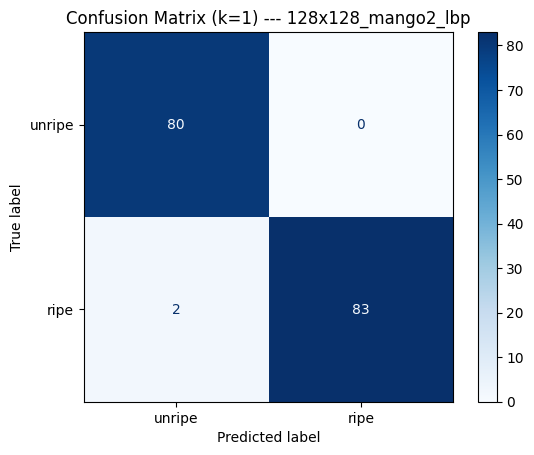

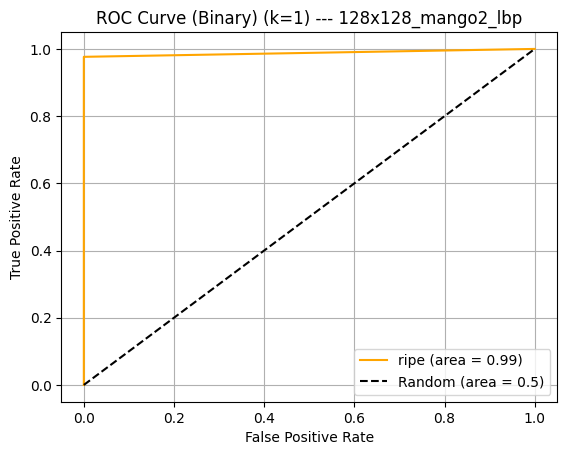


--- KNN (k=3) on 128x128_mango2_lbp Feature ---
              precision    recall  f1-score   support

      unripe     0.9873    0.9750    0.9811        80
        ripe     0.9767    0.9882    0.9825        85

    accuracy                         0.9818       165
   macro avg     0.9820    0.9816    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.0010 seconds


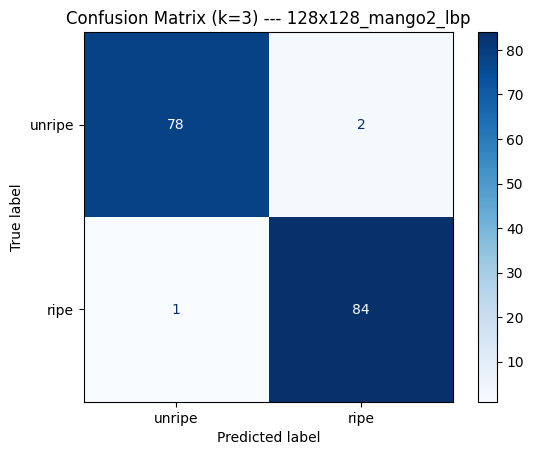

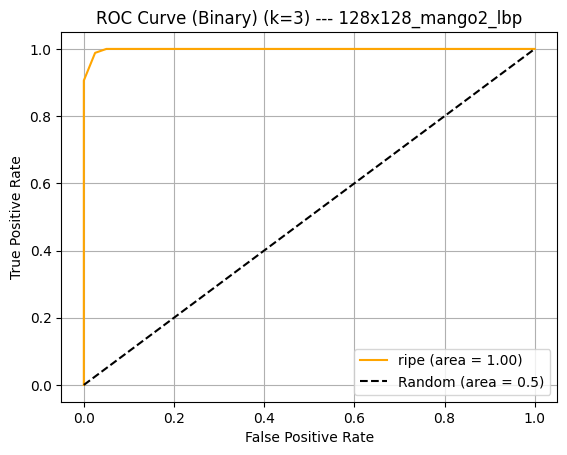


--- KNN (k=5) on 128x128_mango2_lbp Feature ---
              precision    recall  f1-score   support

      unripe     0.9750    0.9750    0.9750        80
        ripe     0.9765    0.9765    0.9765        85

    accuracy                         0.9758       165
   macro avg     0.9757    0.9757    0.9757       165
weighted avg     0.9758    0.9758    0.9758       165

Training time: 0.0010 seconds


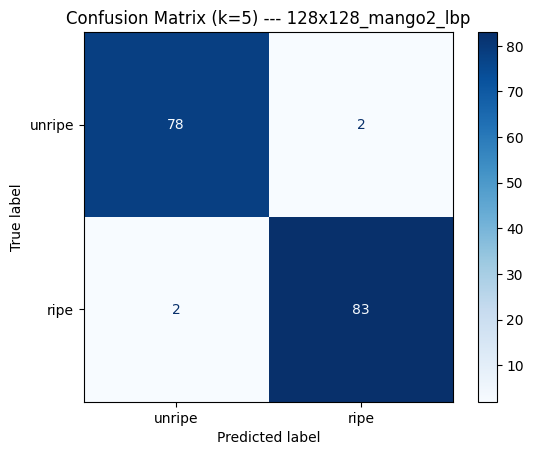

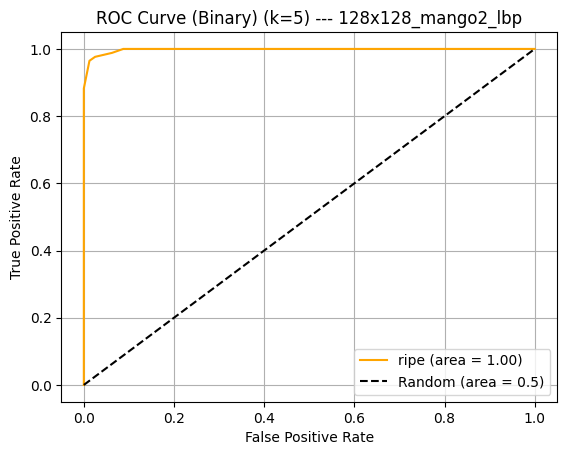


--- KNN (k=7) on 128x128_mango2_lbp Feature ---
              precision    recall  f1-score   support

      unripe     0.9750    0.9750    0.9750        80
        ripe     0.9765    0.9765    0.9765        85

    accuracy                         0.9758       165
   macro avg     0.9757    0.9757    0.9757       165
weighted avg     0.9758    0.9758    0.9758       165

Training time: 0.0020 seconds


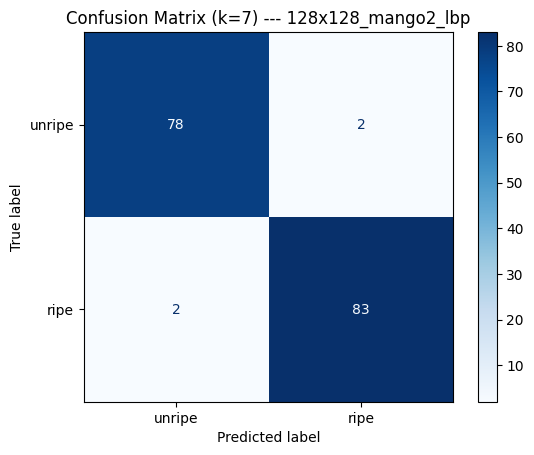

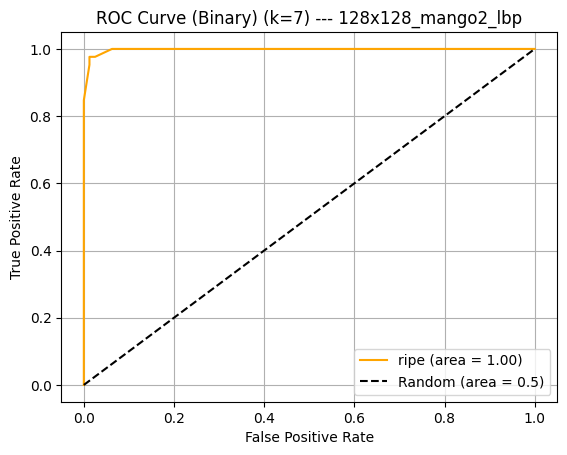


--- KNN (k=10) on 128x128_mango2_lbp Feature ---
              precision    recall  f1-score   support

      unripe     0.9750    0.9750    0.9750        80
        ripe     0.9765    0.9765    0.9765        85

    accuracy                         0.9758       165
   macro avg     0.9757    0.9757    0.9757       165
weighted avg     0.9758    0.9758    0.9758       165

Training time: 0.0010 seconds


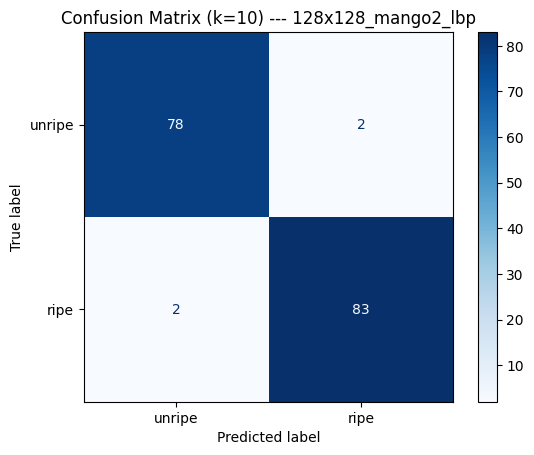

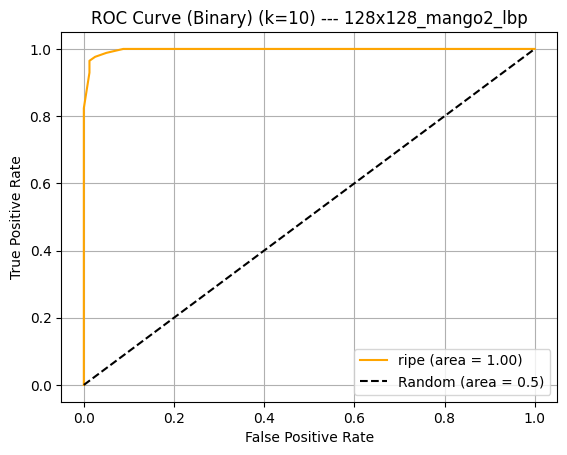

Results saved to knn_k_comparison_metrics.csv


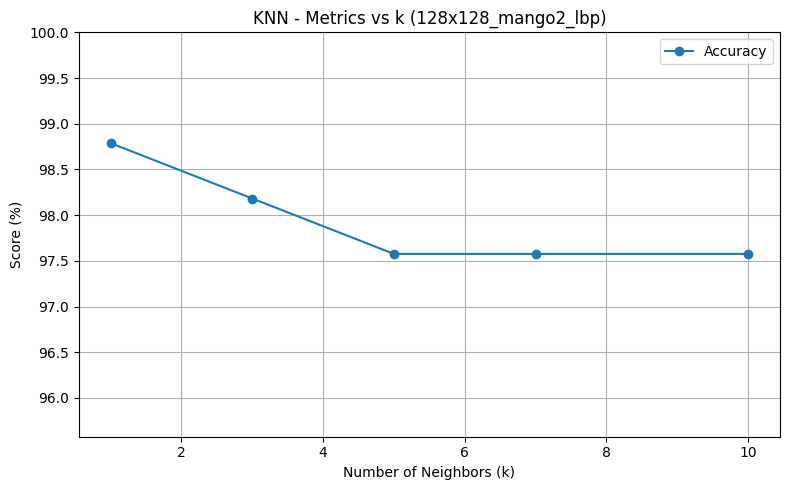

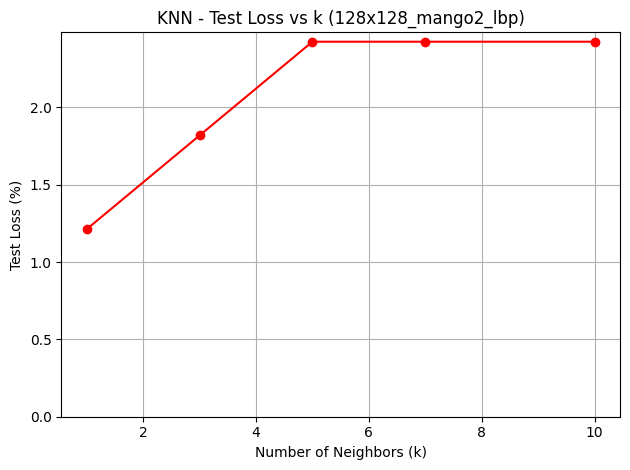

k  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  Test Loss (%)  \
0   1     98.787879      98.817443   98.787879     98.788146       1.212121   
1   3     98.181818      98.188241   98.181818     98.181417       1.818182   
2   5     97.575758      97.575758   97.575758     97.575758       2.424242   
3   7     97.575758      97.575758   97.575758     97.575758       2.424242   
4  10     97.575758      97.575758   97.575758     97.575758       2.424242   

   Training Time (s)  
0           0.001000  
1           0.001004  
2           0.001002  
3           0.001999  
4           0.001000

In [18]:
from knn_classification import knn_classification

knn_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_test.csv",
    feature="128x128_mango2_lbp",
    class_order=['unripe', 'ripe']
)



--- KNN (k=1) on 128x128_mango2_glcm Feature ---
              precision    recall  f1-score   support

      unripe     0.9750    0.9750    0.9750        80
        ripe     0.9765    0.9765    0.9765        85

    accuracy                         0.9758       165
   macro avg     0.9757    0.9757    0.9757       165
weighted avg     0.9758    0.9758    0.9758       165

Training time: 0.0010 seconds


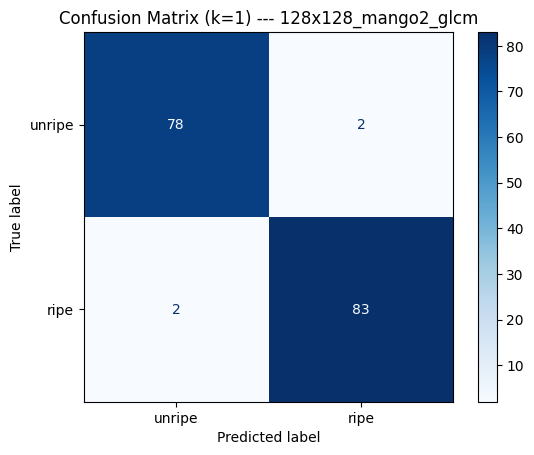

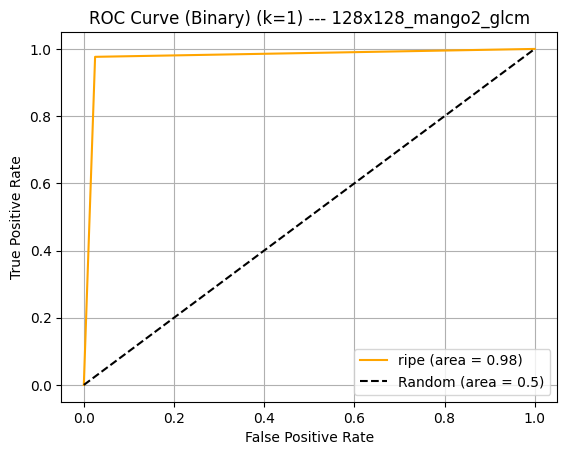


--- KNN (k=3) on 128x128_mango2_glcm Feature ---
              precision    recall  f1-score   support

      unripe     0.9756    1.0000    0.9877        80
        ripe     1.0000    0.9765    0.9881        85

    accuracy                         0.9879       165
   macro avg     0.9878    0.9882    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165

Training time: 0.0010 seconds


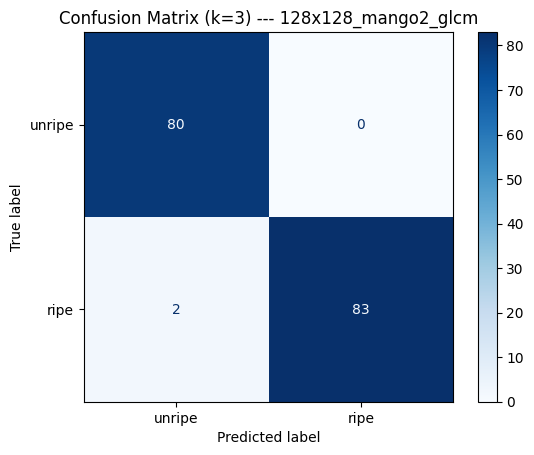

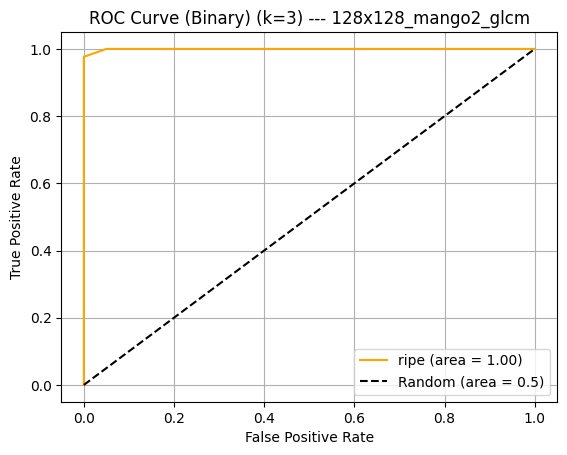


--- KNN (k=5) on 128x128_mango2_glcm Feature ---
              precision    recall  f1-score   support

      unripe     0.9518    0.9875    0.9693        80
        ripe     0.9878    0.9529    0.9701        85

    accuracy                         0.9697       165
   macro avg     0.9698    0.9702    0.9697       165
weighted avg     0.9704    0.9697    0.9697       165

Training time: 0.0010 seconds


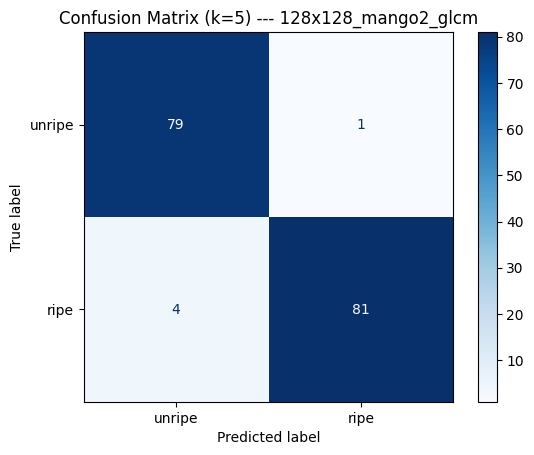

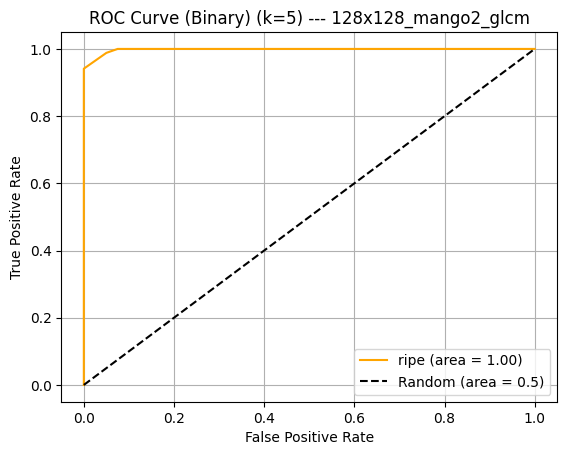


--- KNN (k=7) on 128x128_mango2_glcm Feature ---
              precision    recall  f1-score   support

      unripe     0.9630    0.9750    0.9689        80
        ripe     0.9762    0.9647    0.9704        85

    accuracy                         0.9697       165
   macro avg     0.9696    0.9699    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165

Training time: 0.0015 seconds


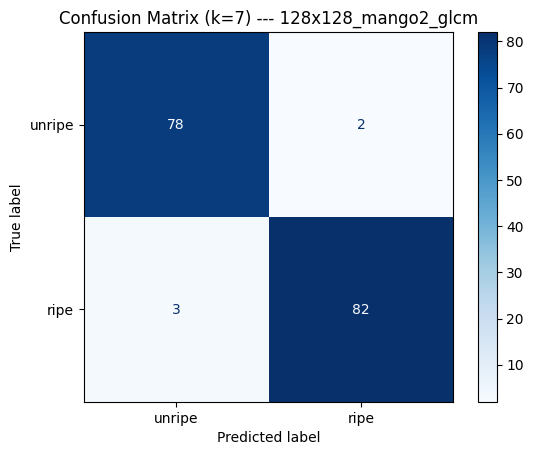

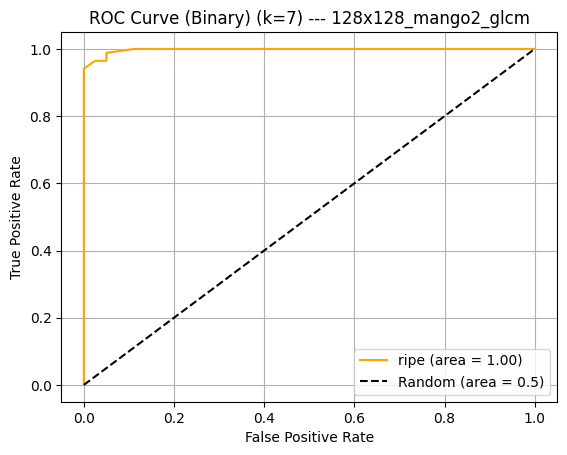


--- KNN (k=10) on 128x128_mango2_glcm Feature ---
              precision    recall  f1-score   support

      unripe     0.9625    0.9625    0.9625        80
        ripe     0.9647    0.9647    0.9647        85

    accuracy                         0.9636       165
   macro avg     0.9636    0.9636    0.9636       165
weighted avg     0.9636    0.9636    0.9636       165

Training time: 0.0010 seconds


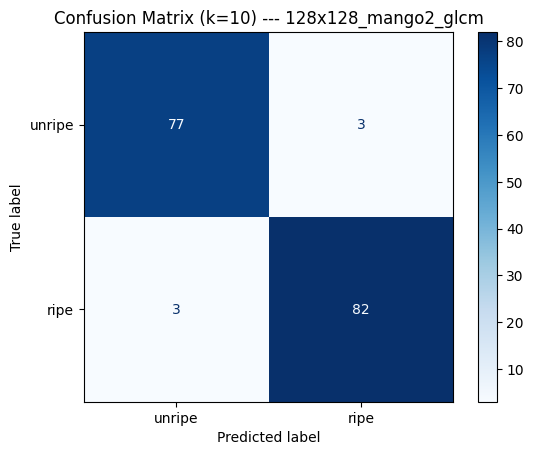

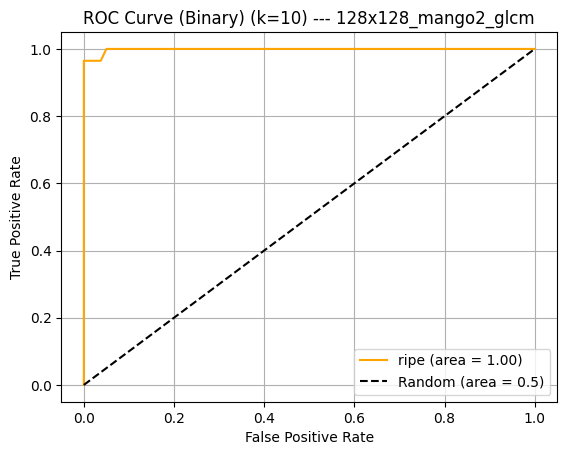

Results saved to knn_k_comparison_metrics.csv


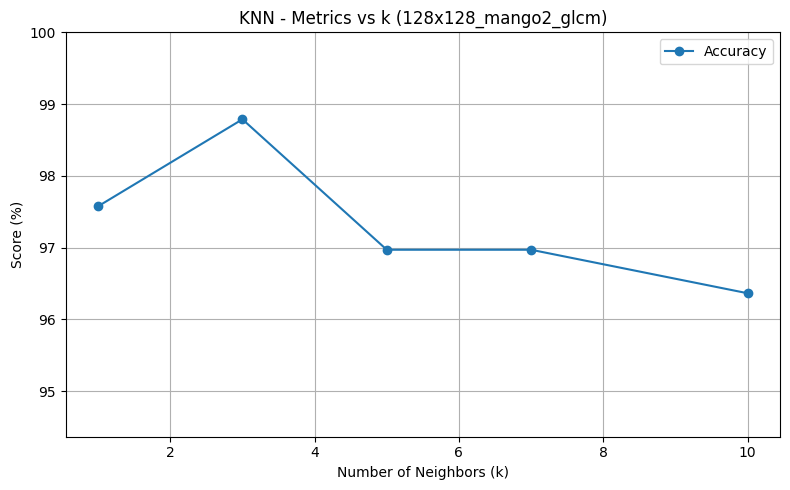

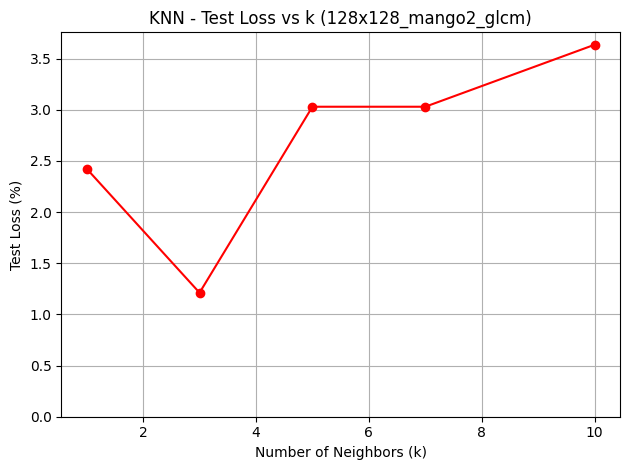

k  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  Test Loss (%)  \
0   1     97.575758      97.575758   97.575758     97.575758       2.424242   
1   3     98.787879      98.817443   98.787879     98.788146       1.212121   
2   5     96.969697      97.035147   96.969697     96.970365       3.030303   
3   7     96.969697      96.977714   96.969697     96.970142       3.030303   
4  10     96.363636      96.363636   96.363636     96.363636       3.636364   

   Training Time (s)  
0           0.000999  
1           0.000999  
2           0.001001  
3           0.001503  
4           0.001000

In [19]:
from knn_classification import knn_classification

knn_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_test.csv",
    feature="128x128_mango2_glcm",
    class_order=['unripe', 'ripe']
)


## SVM


 Now running: 128x128_rgb

=== SVM (kernel=poly, degree=3, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



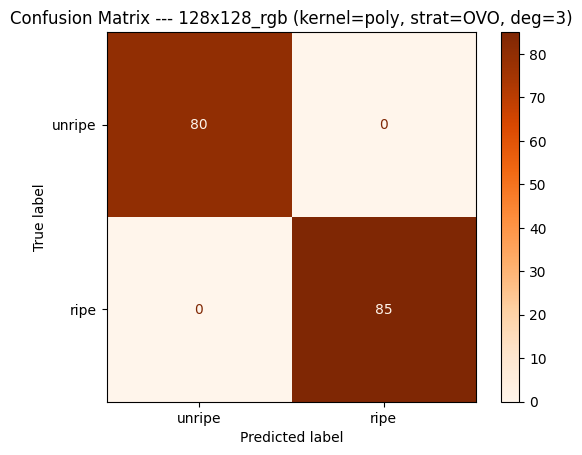


=== SVM (kernel=poly, degree=4, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9434    0.6250    0.7519        80
        ripe     0.7321    0.9647    0.8325        85

    accuracy                         0.8000       165
   macro avg     0.8378    0.7949    0.7922       165
weighted avg     0.8346    0.8000    0.7934       165



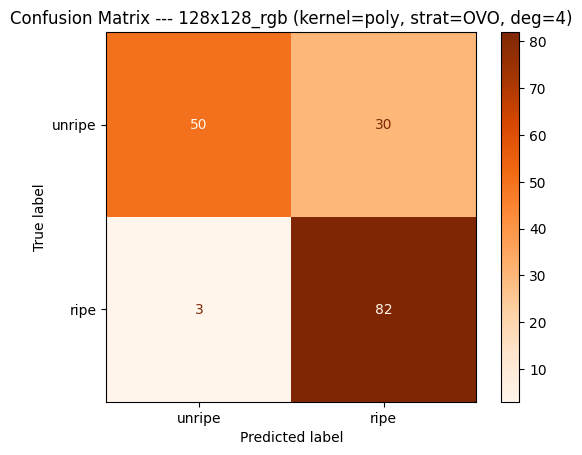


=== SVM (kernel=poly, degree=5, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9750    0.9873        80
        ripe     0.9770    1.0000    0.9884        85

    accuracy                         0.9879       165
   macro avg     0.9885    0.9875    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165



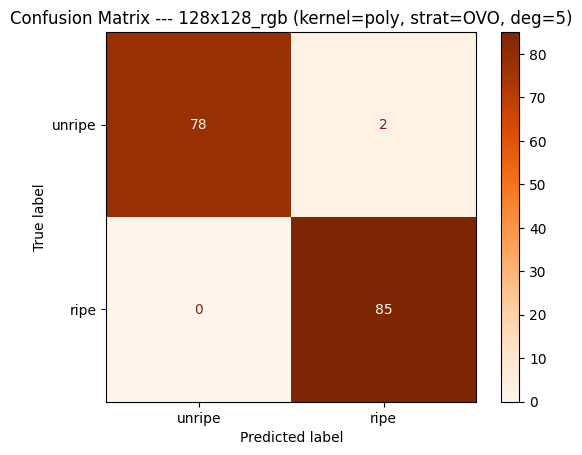


=== SVM (kernel=poly, degree=6, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9556    0.5375    0.6880        80
        ripe     0.6917    0.9765    0.8098        85

    accuracy                         0.7636       165
   macro avg     0.8236    0.7570    0.7489       165
weighted avg     0.8196    0.7636    0.7507       165



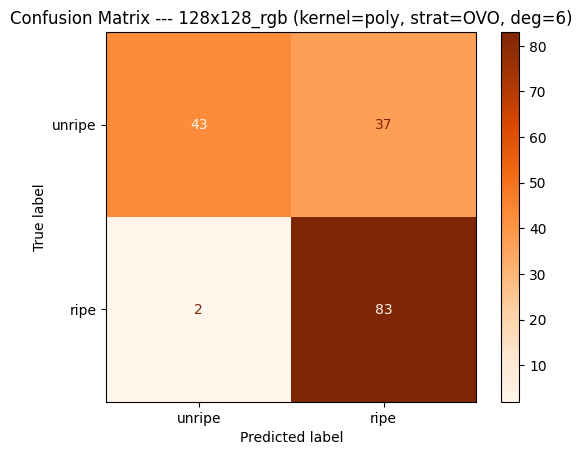


=== SVM (kernel=poly, degree=7, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.8375    0.9116        80
        ripe     0.8673    1.0000    0.9290        85

    accuracy                         0.9212       165
   macro avg     0.9337    0.9187    0.9203       165
weighted avg     0.9317    0.9212    0.9205       165



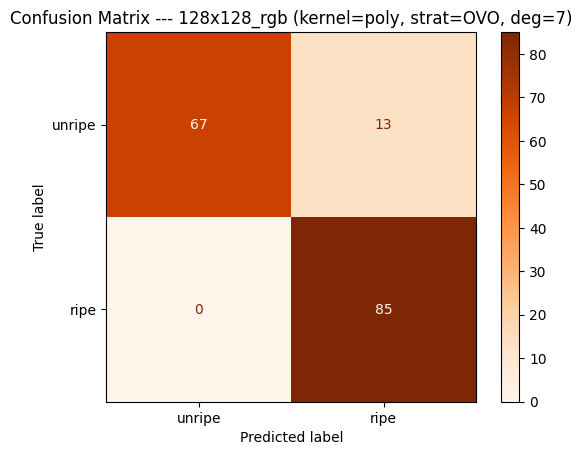


=== SVM (kernel=poly, degree=8, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9459    0.4375    0.5983        80
        ripe     0.6484    0.9765    0.7793        85

    accuracy                         0.7152       165
   macro avg     0.7972    0.7070    0.6888       165
weighted avg     0.7927    0.7152    0.6916       165



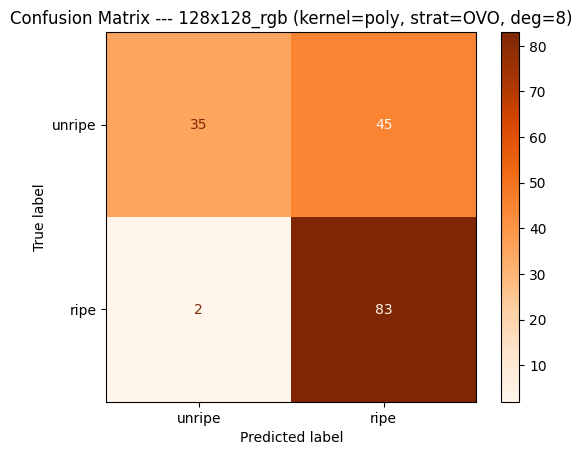


=== SVM (kernel=poly, degree=9, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7000    0.8235        80
        ripe     0.7798    1.0000    0.8763        85

    accuracy                         0.8545       165
   macro avg     0.8899    0.8500    0.8499       165
weighted avg     0.8866    0.8545    0.8507       165



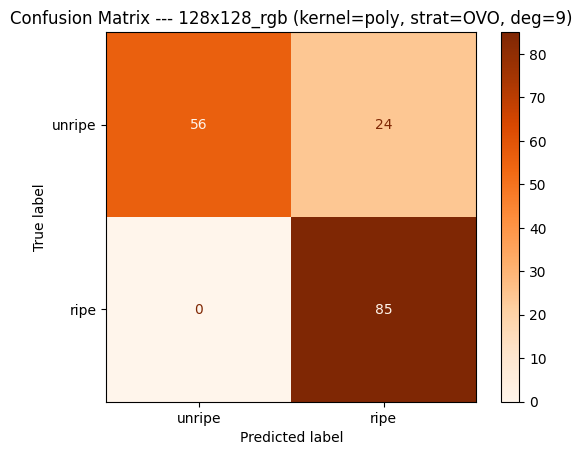


=== SVM (kernel=poly, degree=3, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



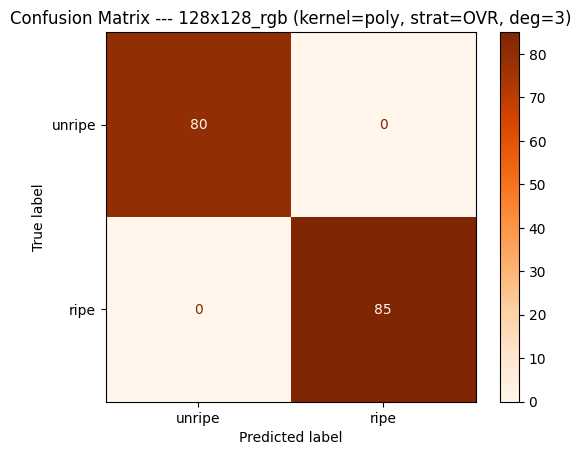


=== SVM (kernel=poly, degree=4, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9434    0.6250    0.7519        80
        ripe     0.7321    0.9647    0.8325        85

    accuracy                         0.8000       165
   macro avg     0.8378    0.7949    0.7922       165
weighted avg     0.8346    0.8000    0.7934       165



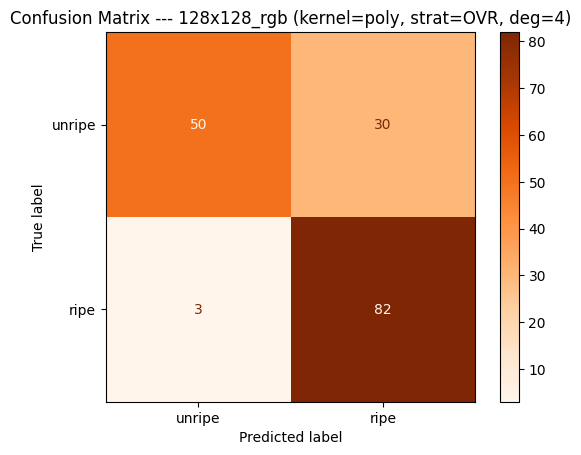


=== SVM (kernel=poly, degree=5, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9750    0.9873        80
        ripe     0.9770    1.0000    0.9884        85

    accuracy                         0.9879       165
   macro avg     0.9885    0.9875    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165



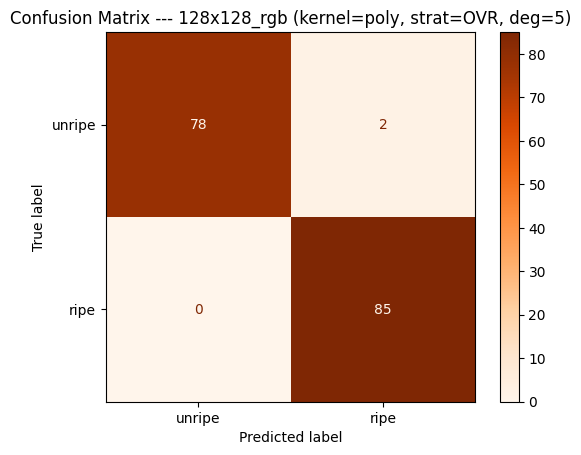


=== SVM (kernel=poly, degree=6, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9556    0.5375    0.6880        80
        ripe     0.6917    0.9765    0.8098        85

    accuracy                         0.7636       165
   macro avg     0.8236    0.7570    0.7489       165
weighted avg     0.8196    0.7636    0.7507       165



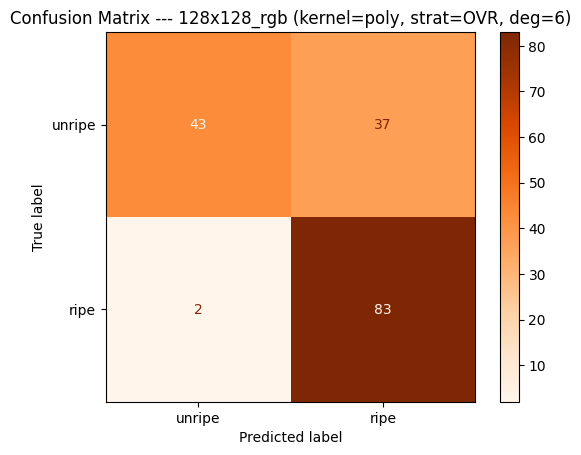


=== SVM (kernel=poly, degree=7, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.8375    0.9116        80
        ripe     0.8673    1.0000    0.9290        85

    accuracy                         0.9212       165
   macro avg     0.9337    0.9187    0.9203       165
weighted avg     0.9317    0.9212    0.9205       165



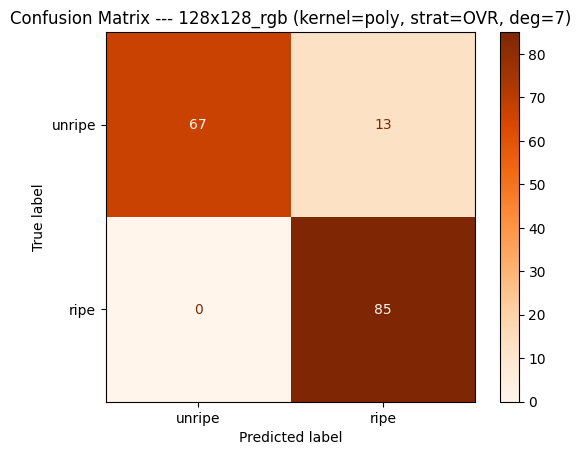


=== SVM (kernel=poly, degree=8, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9459    0.4375    0.5983        80
        ripe     0.6484    0.9765    0.7793        85

    accuracy                         0.7152       165
   macro avg     0.7972    0.7070    0.6888       165
weighted avg     0.7927    0.7152    0.6916       165



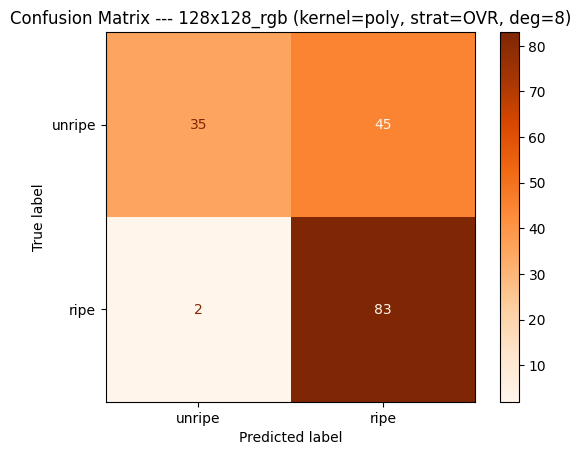


=== SVM (kernel=poly, degree=9, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7000    0.8235        80
        ripe     0.7798    1.0000    0.8763        85

    accuracy                         0.8545       165
   macro avg     0.8899    0.8500    0.8499       165
weighted avg     0.8866    0.8545    0.8507       165



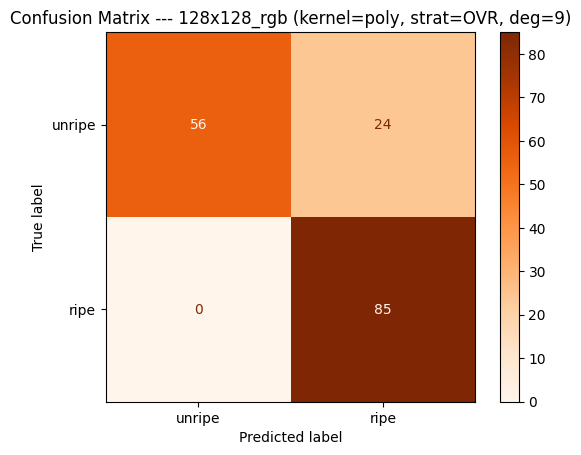


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_rgb\poly\poly_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_rgb\poly\poly_results_pairwise.csv


=== SVM (kernel=linear, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



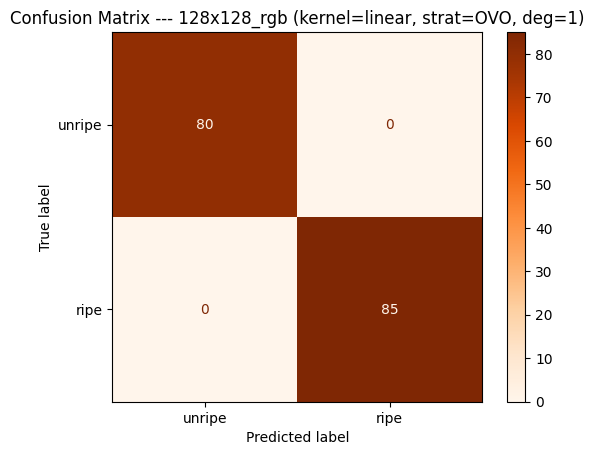


=== SVM (kernel=linear, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



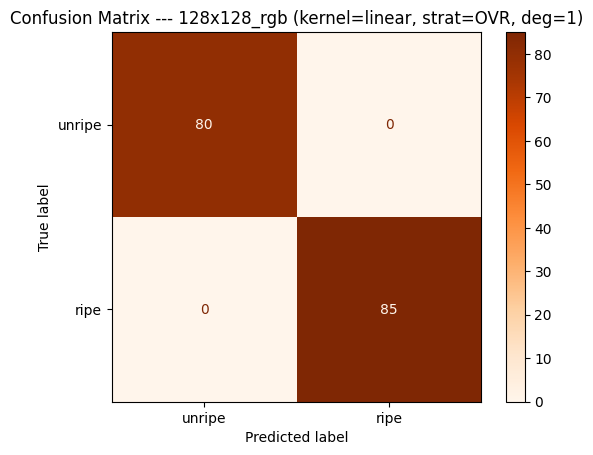


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_rgb\linear\linear_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_rgb\linear\linear_results_pairwise.csv


=== SVM (kernel=rbf, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



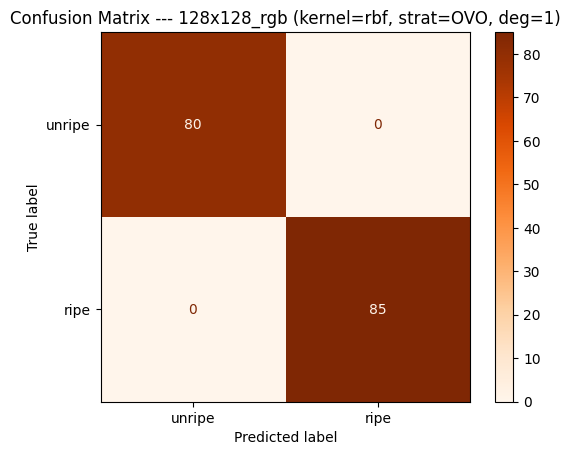


=== SVM (kernel=rbf, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



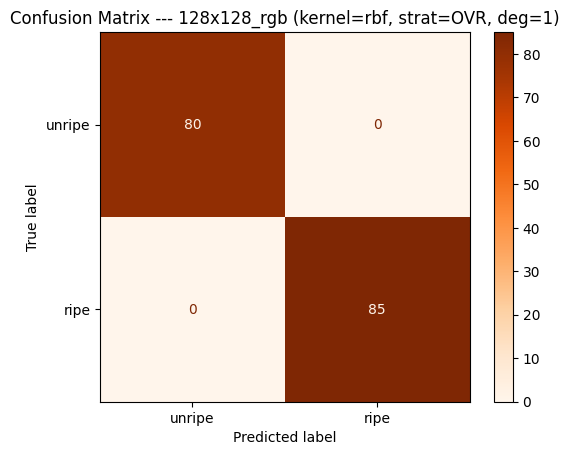


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_rgb\rbf\rbf_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_rgb\rbf\rbf_results_pairwise.csv


=== SVM (kernel=sigmoid, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8472    0.7625    0.8026        80
        ripe     0.7957    0.8706    0.8315        85

    accuracy                         0.8182       165
   macro avg     0.8215    0.8165    0.8170       165
weighted avg     0.8207    0.8182    0.8175       165



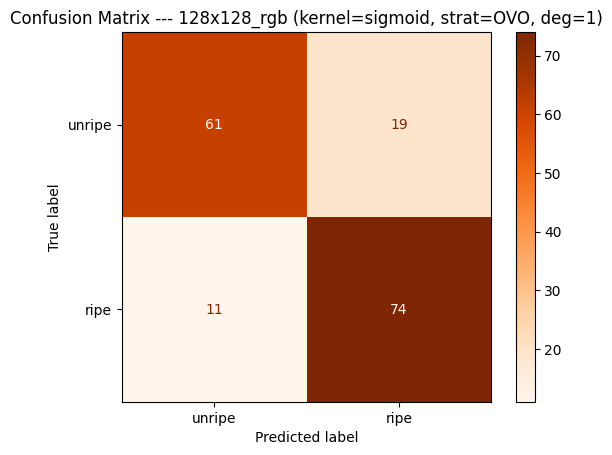


=== SVM (kernel=sigmoid, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8472    0.7625    0.8026        80
        ripe     0.7957    0.8706    0.8315        85

    accuracy                         0.8182       165
   macro avg     0.8215    0.8165    0.8170       165
weighted avg     0.8207    0.8182    0.8175       165



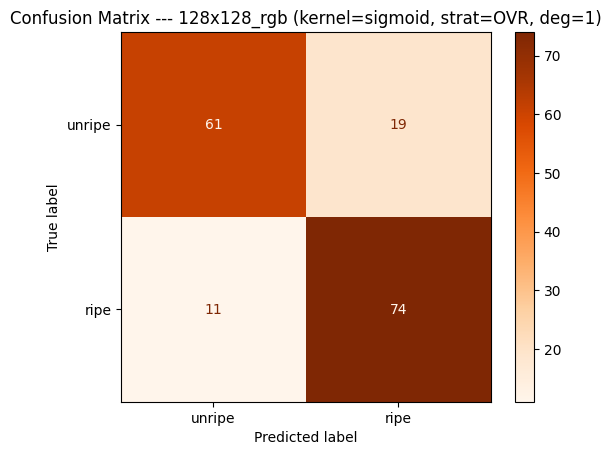


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_rgb\sigmoid\sigmoid_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_rgb\sigmoid\sigmoid_results_pairwise.csv


 Now running: 128x128_his

=== SVM (kernel=poly, degree=3, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



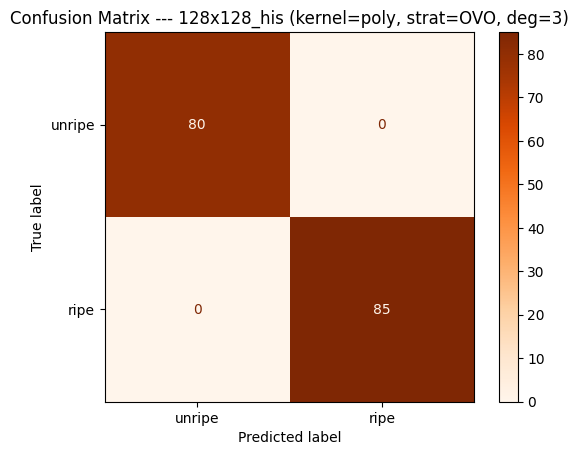


=== SVM (kernel=poly, degree=4, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9398    0.9750    0.9571        80
        ripe     0.9756    0.9412    0.9581        85

    accuracy                         0.9576       165
   macro avg     0.9577    0.9581    0.9576       165
weighted avg     0.9582    0.9576    0.9576       165



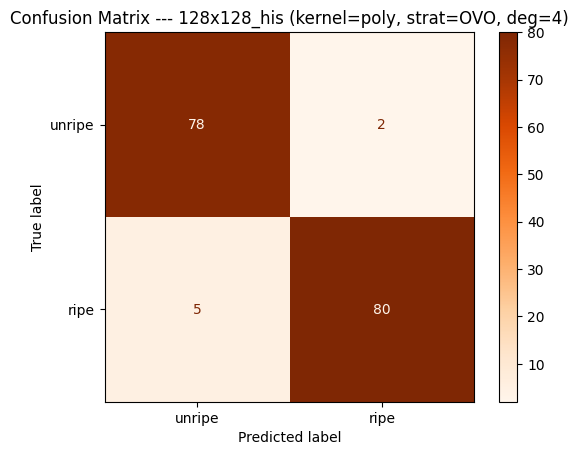


=== SVM (kernel=poly, degree=5, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



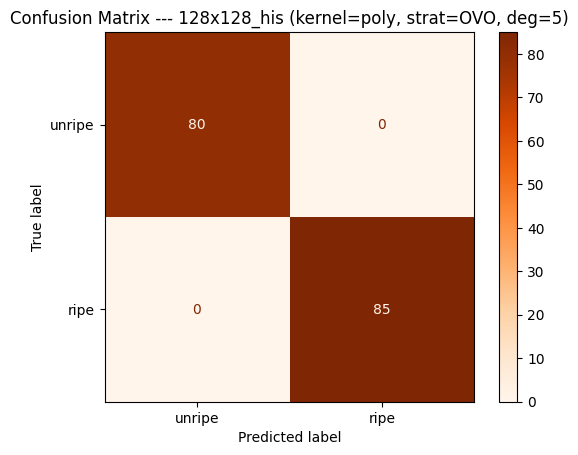


=== SVM (kernel=poly, degree=6, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8387    0.9750    0.9017        80
        ripe     0.9722    0.8235    0.8917        85

    accuracy                         0.8970       165
   macro avg     0.9055    0.8993    0.8967       165
weighted avg     0.9075    0.8970    0.8966       165



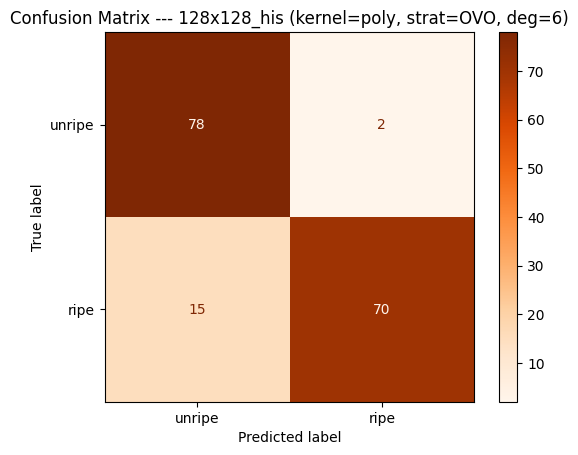


=== SVM (kernel=poly, degree=7, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8791    1.0000    0.9357        80
        ripe     1.0000    0.8706    0.9308        85

    accuracy                         0.9333       165
   macro avg     0.9396    0.9353    0.9332       165
weighted avg     0.9414    0.9333    0.9332       165



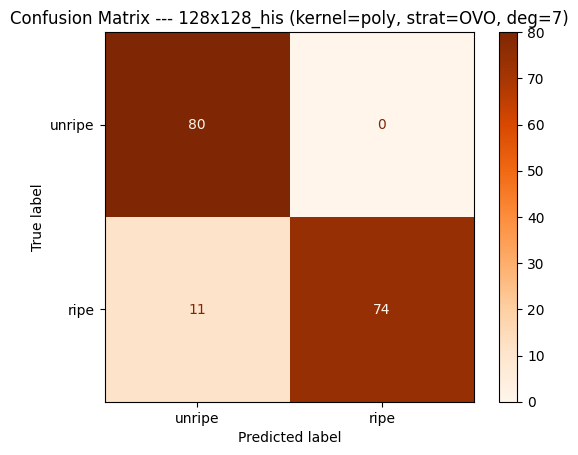


=== SVM (kernel=poly, degree=8, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.7117    0.9875    0.8272        80
        ripe     0.9815    0.6235    0.7626        85

    accuracy                         0.8000       165
   macro avg     0.8466    0.8055    0.7949       165
weighted avg     0.8507    0.8000    0.7939       165



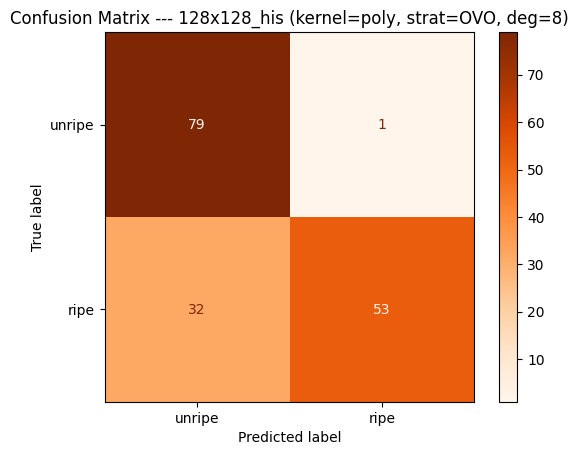


=== SVM (kernel=poly, degree=9, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.7273    1.0000    0.8421        80
        ripe     1.0000    0.6471    0.7857        85

    accuracy                         0.8182       165
   macro avg     0.8636    0.8235    0.8139       165
weighted avg     0.8678    0.8182    0.8131       165



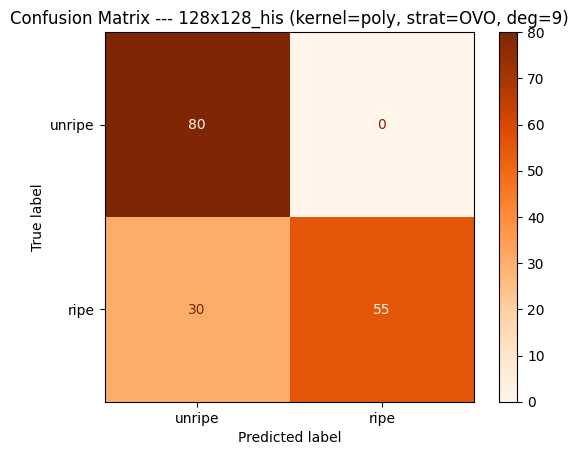


=== SVM (kernel=poly, degree=3, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



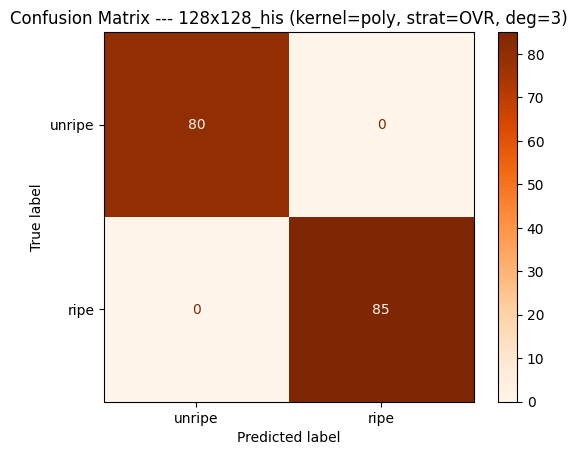


=== SVM (kernel=poly, degree=4, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9398    0.9750    0.9571        80
        ripe     0.9756    0.9412    0.9581        85

    accuracy                         0.9576       165
   macro avg     0.9577    0.9581    0.9576       165
weighted avg     0.9582    0.9576    0.9576       165



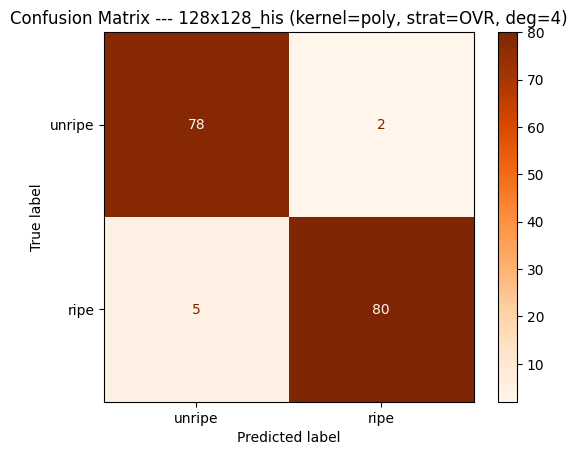


=== SVM (kernel=poly, degree=5, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



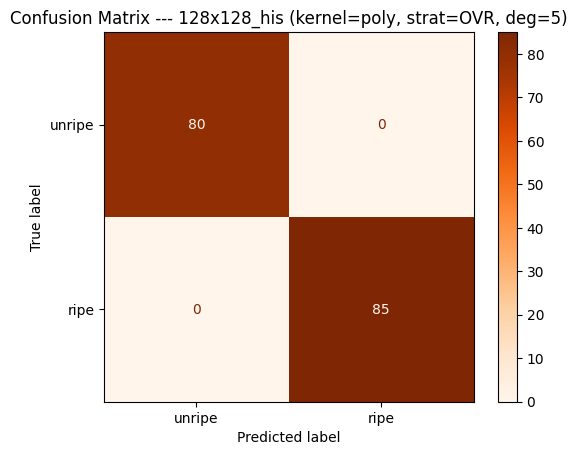


=== SVM (kernel=poly, degree=6, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8387    0.9750    0.9017        80
        ripe     0.9722    0.8235    0.8917        85

    accuracy                         0.8970       165
   macro avg     0.9055    0.8993    0.8967       165
weighted avg     0.9075    0.8970    0.8966       165



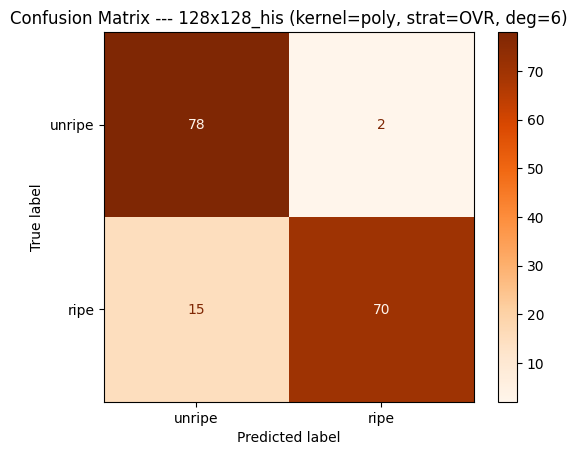


=== SVM (kernel=poly, degree=7, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8791    1.0000    0.9357        80
        ripe     1.0000    0.8706    0.9308        85

    accuracy                         0.9333       165
   macro avg     0.9396    0.9353    0.9332       165
weighted avg     0.9414    0.9333    0.9332       165



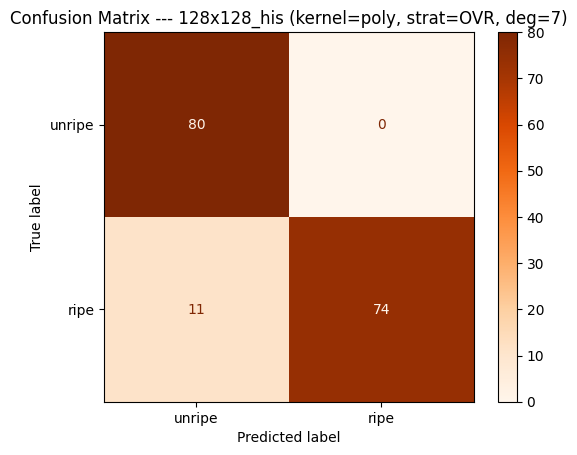


=== SVM (kernel=poly, degree=8, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.7117    0.9875    0.8272        80
        ripe     0.9815    0.6235    0.7626        85

    accuracy                         0.8000       165
   macro avg     0.8466    0.8055    0.7949       165
weighted avg     0.8507    0.8000    0.7939       165



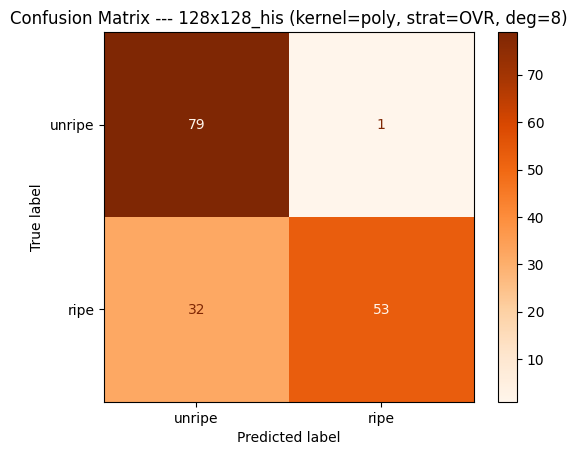


=== SVM (kernel=poly, degree=9, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.7273    1.0000    0.8421        80
        ripe     1.0000    0.6471    0.7857        85

    accuracy                         0.8182       165
   macro avg     0.8636    0.8235    0.8139       165
weighted avg     0.8678    0.8182    0.8131       165



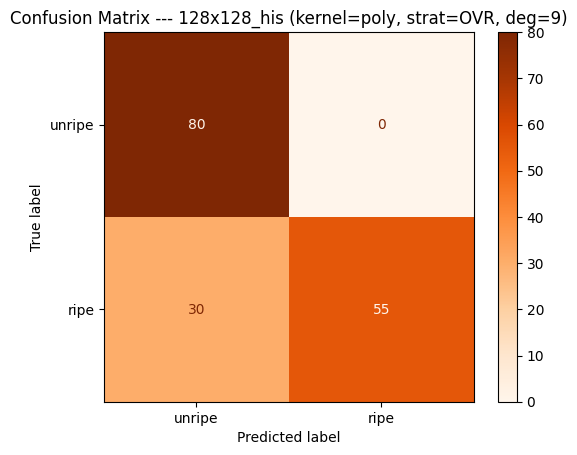


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_his\poly\poly_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_his\poly\poly_results_pairwise.csv


=== SVM (kernel=linear, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



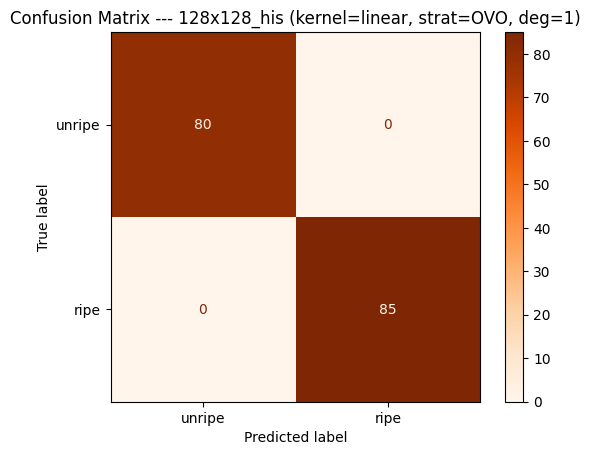


=== SVM (kernel=linear, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



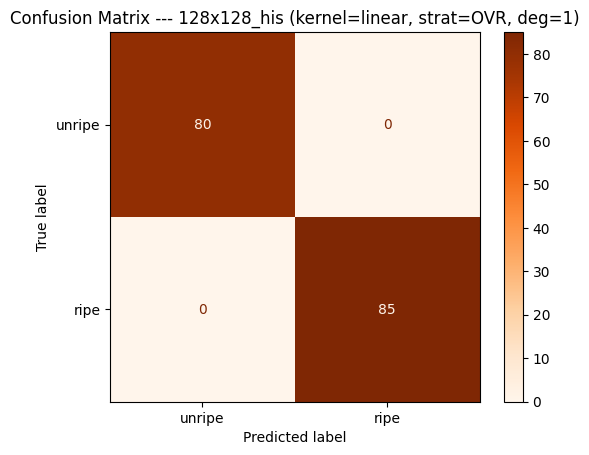


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_his\linear\linear_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_his\linear\linear_results_pairwise.csv


=== SVM (kernel=rbf, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



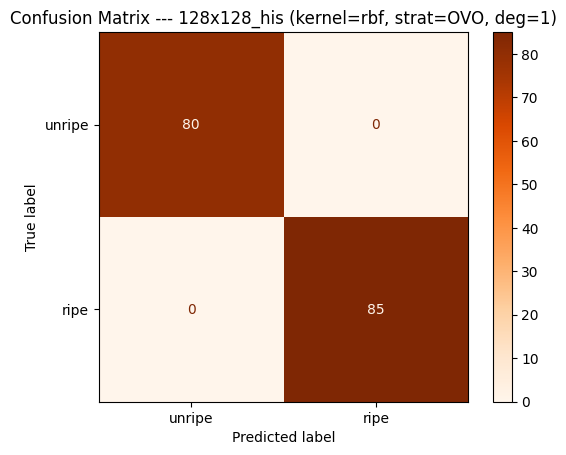


=== SVM (kernel=rbf, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



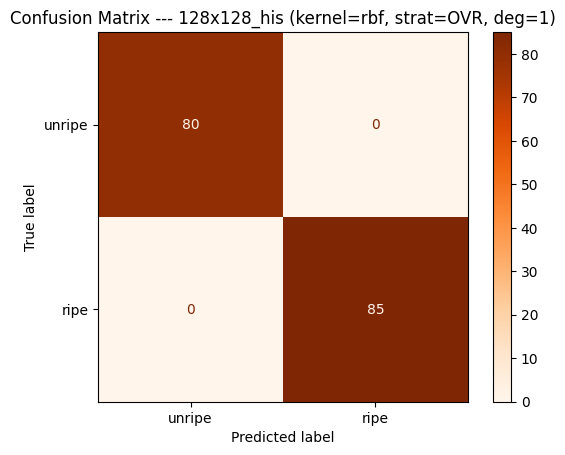


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_his\rbf\rbf_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_his\rbf\rbf_results_pairwise.csv


=== SVM (kernel=sigmoid, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



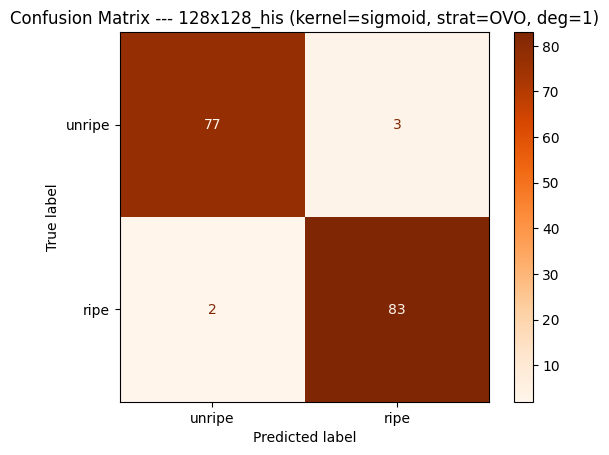


=== SVM (kernel=sigmoid, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



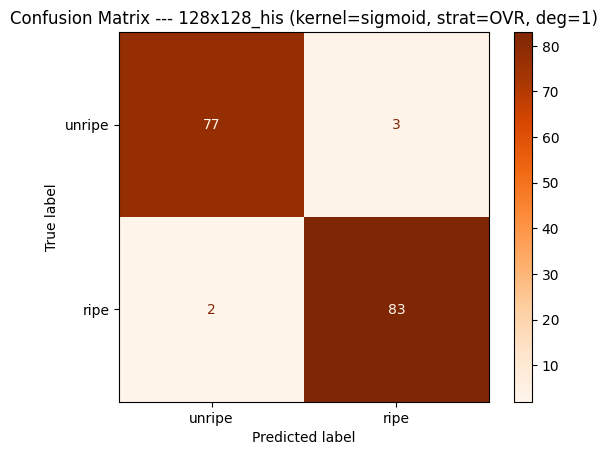


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_his\sigmoid\sigmoid_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_his\sigmoid\sigmoid_results_pairwise.csv


 Now running: 128x128_lab

=== SVM (kernel=poly, degree=3, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



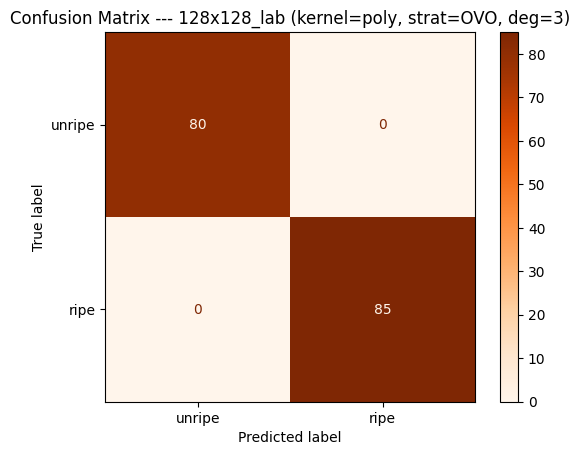


=== SVM (kernel=poly, degree=4, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9545    0.5250    0.6774        80
        ripe     0.6860    0.9765    0.8058        85

    accuracy                         0.7576       165
   macro avg     0.8202    0.7507    0.7416       165
weighted avg     0.8162    0.7576    0.7436       165



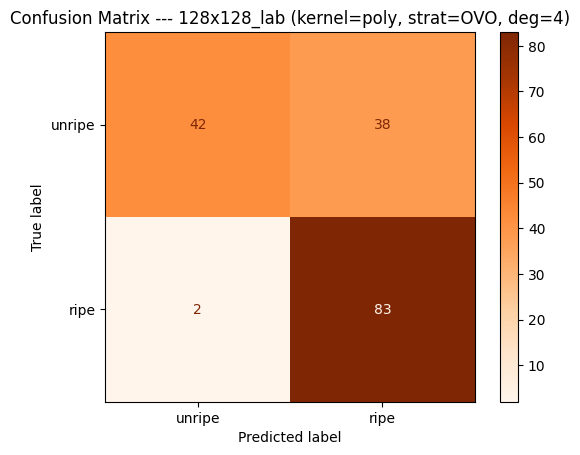


=== SVM (kernel=poly, degree=5, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



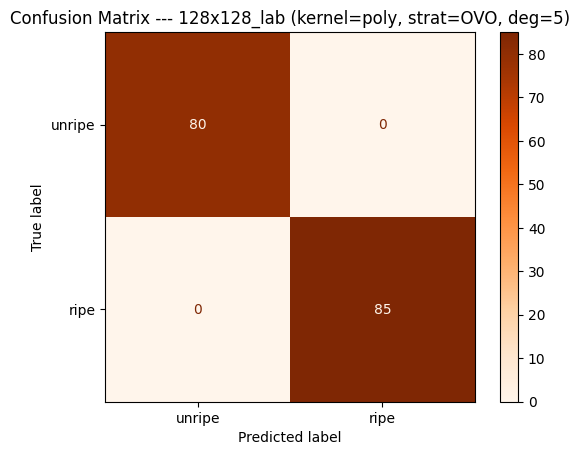


=== SVM (kernel=poly, degree=6, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9565    0.5500    0.6984        80
        ripe     0.6975    0.9765    0.8137        85

    accuracy                         0.7697       165
   macro avg     0.8270    0.7632    0.7561       165
weighted avg     0.8231    0.7697    0.7578       165



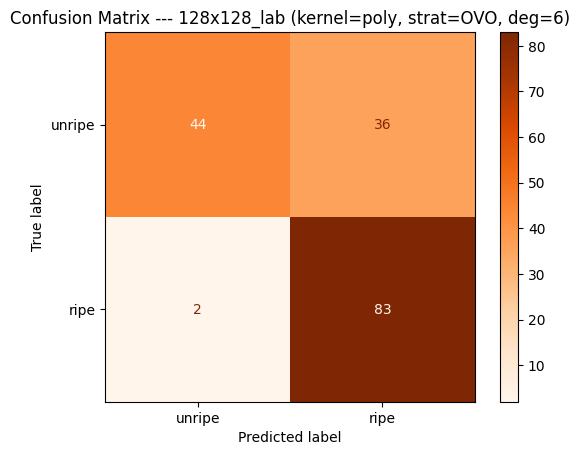


=== SVM (kernel=poly, degree=7, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.8750    0.9333        80
        ripe     0.8947    1.0000    0.9444        85

    accuracy                         0.9394       165
   macro avg     0.9474    0.9375    0.9389       165
weighted avg     0.9458    0.9394    0.9391       165



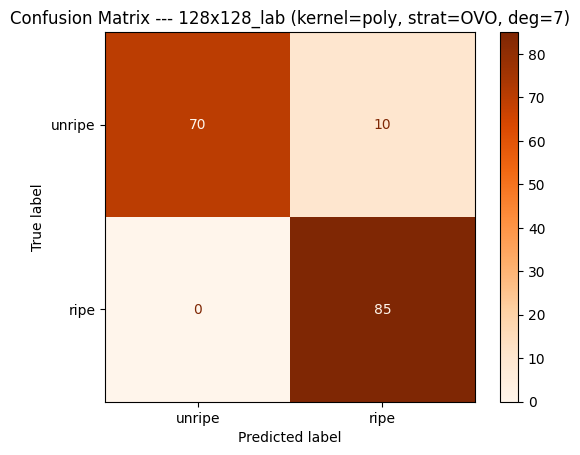


=== SVM (kernel=poly, degree=8, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9750    0.4875    0.6500        80
        ripe     0.6720    0.9882    0.8000        85

    accuracy                         0.7455       165
   macro avg     0.8235    0.7379    0.7250       165
weighted avg     0.8189    0.7455    0.7273       165



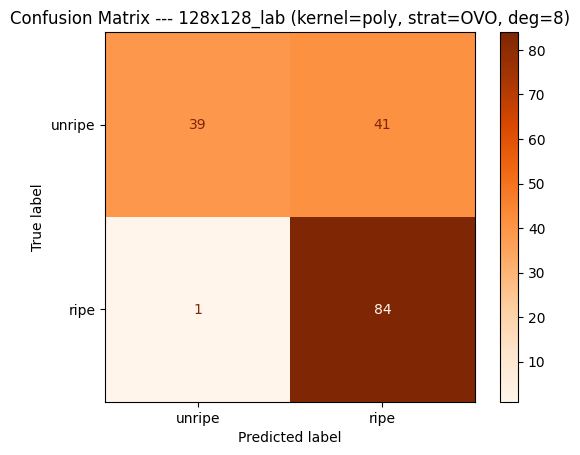


=== SVM (kernel=poly, degree=9, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7625    0.8652        80
        ripe     0.8173    1.0000    0.8995        85

    accuracy                         0.8848       165
   macro avg     0.9087    0.8812    0.8824       165
weighted avg     0.9059    0.8848    0.8829       165



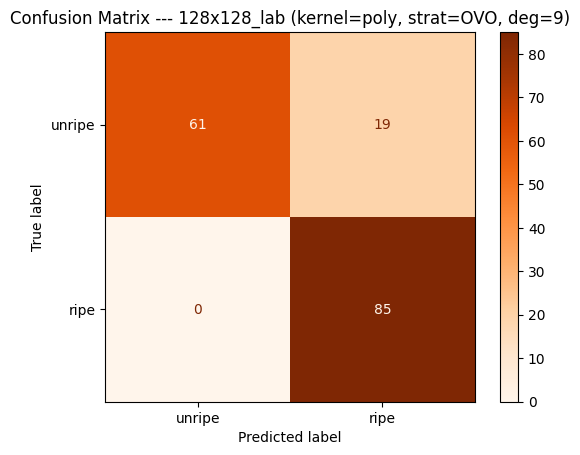


=== SVM (kernel=poly, degree=3, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



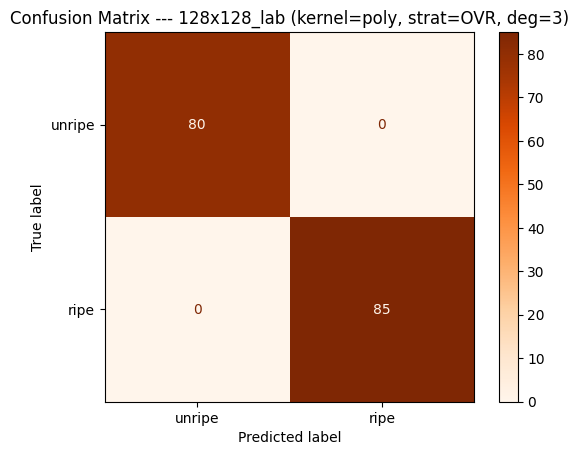


=== SVM (kernel=poly, degree=4, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9545    0.5250    0.6774        80
        ripe     0.6860    0.9765    0.8058        85

    accuracy                         0.7576       165
   macro avg     0.8202    0.7507    0.7416       165
weighted avg     0.8162    0.7576    0.7436       165



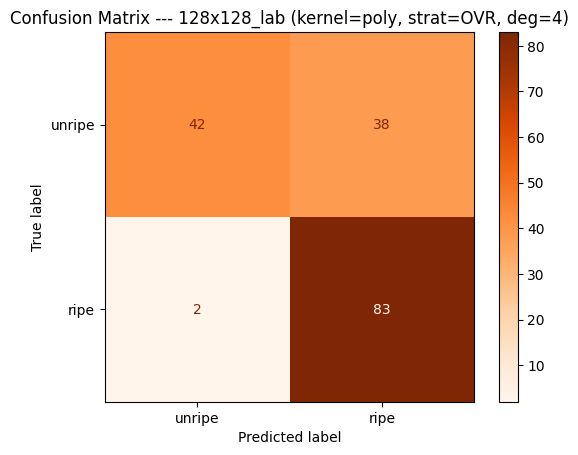


=== SVM (kernel=poly, degree=5, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



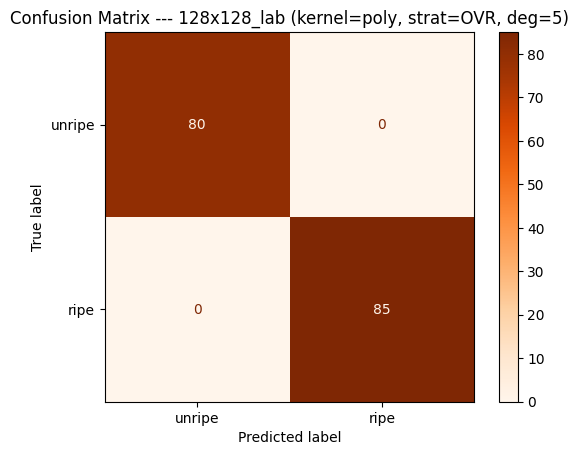


=== SVM (kernel=poly, degree=6, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9565    0.5500    0.6984        80
        ripe     0.6975    0.9765    0.8137        85

    accuracy                         0.7697       165
   macro avg     0.8270    0.7632    0.7561       165
weighted avg     0.8231    0.7697    0.7578       165



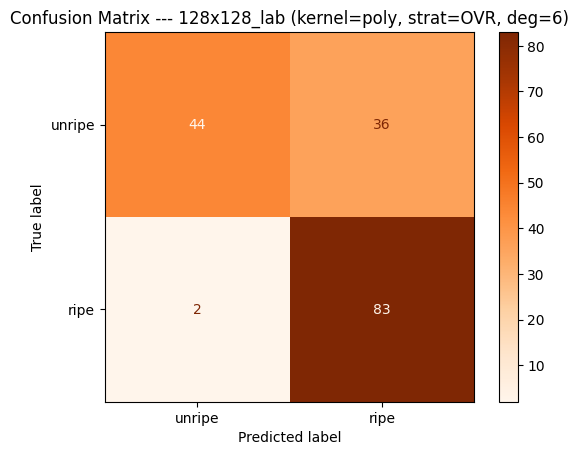


=== SVM (kernel=poly, degree=7, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.8750    0.9333        80
        ripe     0.8947    1.0000    0.9444        85

    accuracy                         0.9394       165
   macro avg     0.9474    0.9375    0.9389       165
weighted avg     0.9458    0.9394    0.9391       165



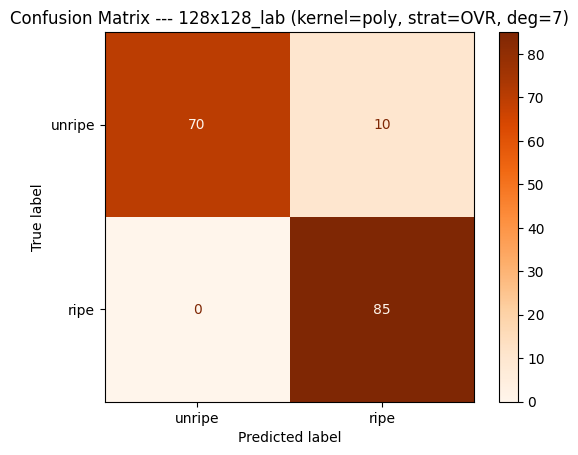


=== SVM (kernel=poly, degree=8, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9750    0.4875    0.6500        80
        ripe     0.6720    0.9882    0.8000        85

    accuracy                         0.7455       165
   macro avg     0.8235    0.7379    0.7250       165
weighted avg     0.8189    0.7455    0.7273       165



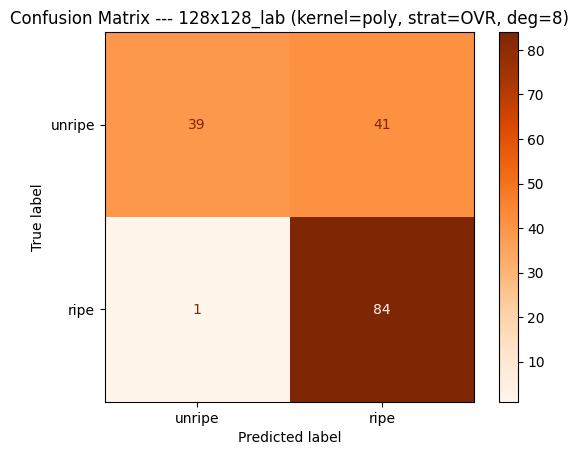


=== SVM (kernel=poly, degree=9, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7625    0.8652        80
        ripe     0.8173    1.0000    0.8995        85

    accuracy                         0.8848       165
   macro avg     0.9087    0.8812    0.8824       165
weighted avg     0.9059    0.8848    0.8829       165



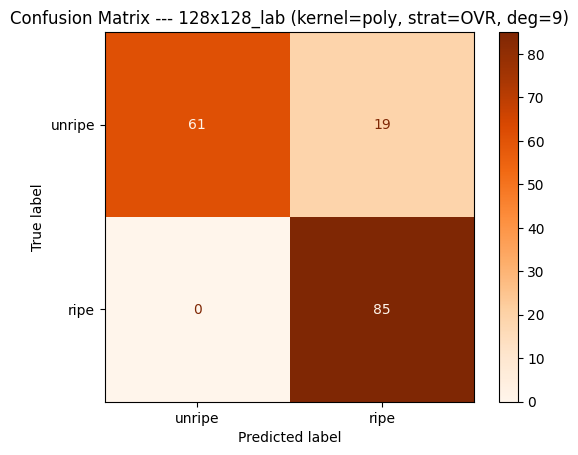


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lab\poly\poly_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lab\poly\poly_results_pairwise.csv


=== SVM (kernel=linear, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



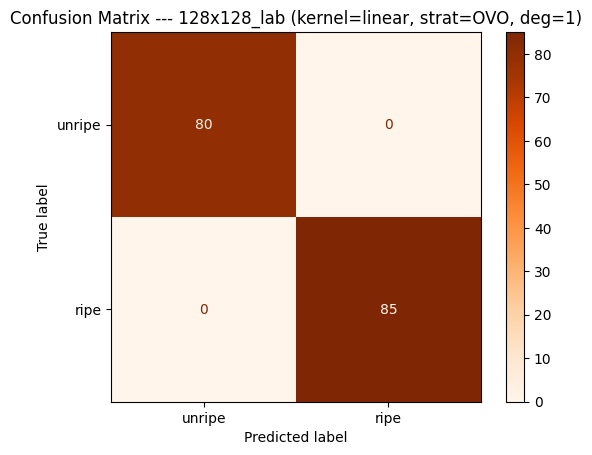


=== SVM (kernel=linear, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



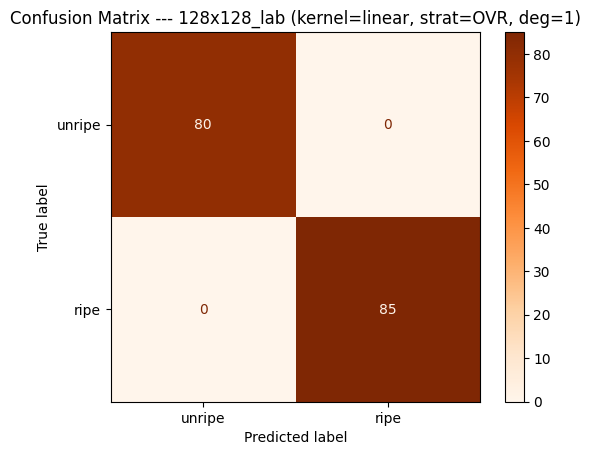


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lab\linear\linear_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lab\linear\linear_results_pairwise.csv


=== SVM (kernel=rbf, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



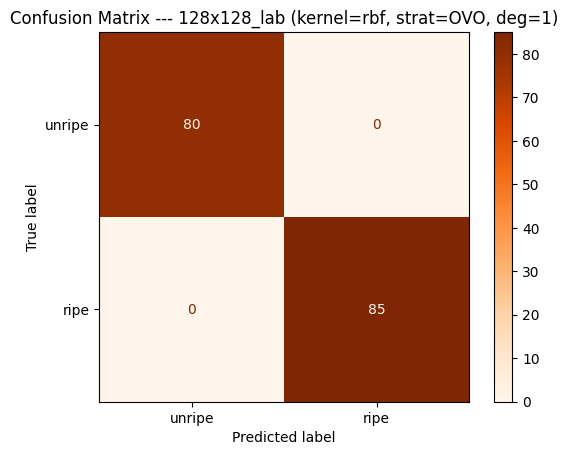


=== SVM (kernel=rbf, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165



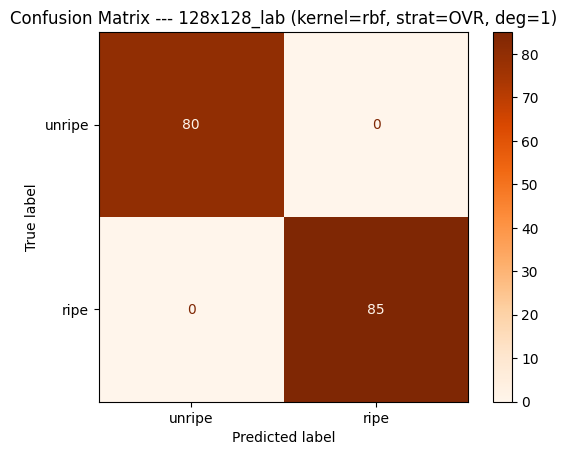


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lab\rbf\rbf_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lab\rbf\rbf_results_pairwise.csv


=== SVM (kernel=sigmoid, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9625    0.9809        80
        ripe     0.9659    1.0000    0.9827        85

    accuracy                         0.9818       165
   macro avg     0.9830    0.9812    0.9818       165
weighted avg     0.9824    0.9818    0.9818       165



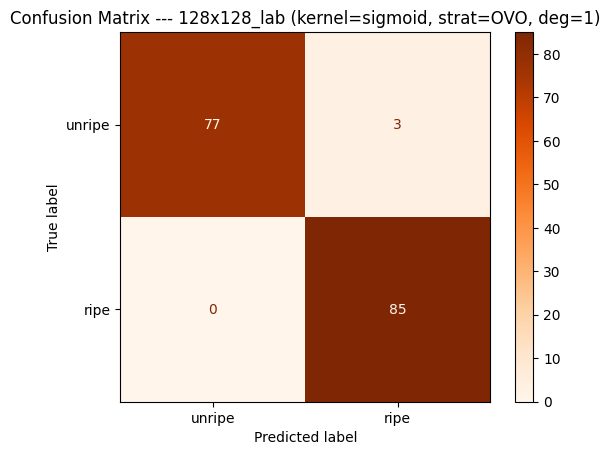


=== SVM (kernel=sigmoid, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9625    0.9809        80
        ripe     0.9659    1.0000    0.9827        85

    accuracy                         0.9818       165
   macro avg     0.9830    0.9812    0.9818       165
weighted avg     0.9824    0.9818    0.9818       165



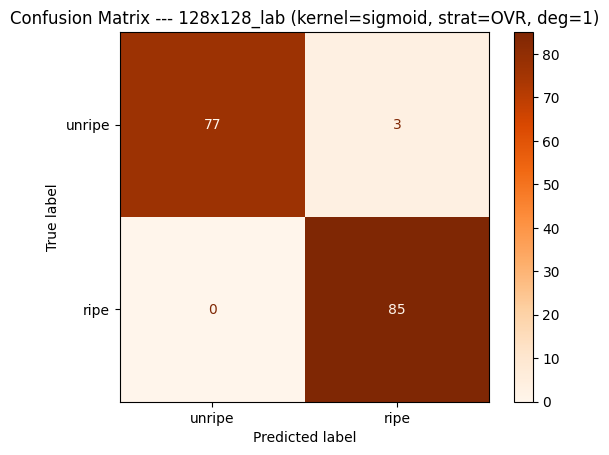


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lab\sigmoid\sigmoid_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lab\sigmoid\sigmoid_results_pairwise.csv


 Now running: 128x128_glcm

=== SVM (kernel=poly, degree=3, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9518    0.9875    0.9693        80
        ripe     0.9878    0.9529    0.9701        85

    accuracy                         0.9697       165
   macro avg     0.9698    0.9702    0.9697       165
weighted avg     0.9704    0.9697    0.9697       165



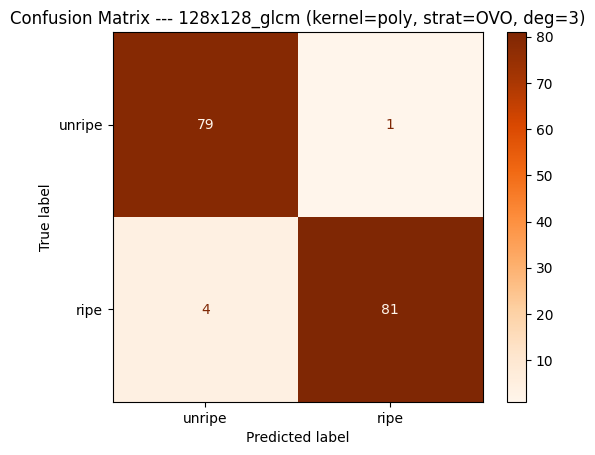


=== SVM (kernel=poly, degree=4, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9643    0.6750    0.7941        80
        ripe     0.7615    0.9765    0.8557        85

    accuracy                         0.8303       165
   macro avg     0.8629    0.8257    0.8249       165
weighted avg     0.8598    0.8303    0.8258       165



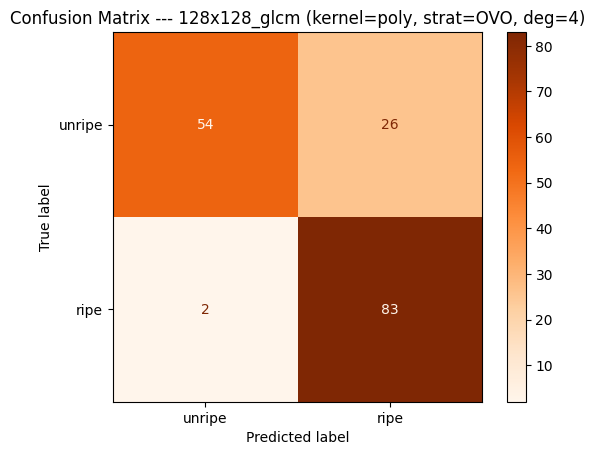


=== SVM (kernel=poly, degree=5, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



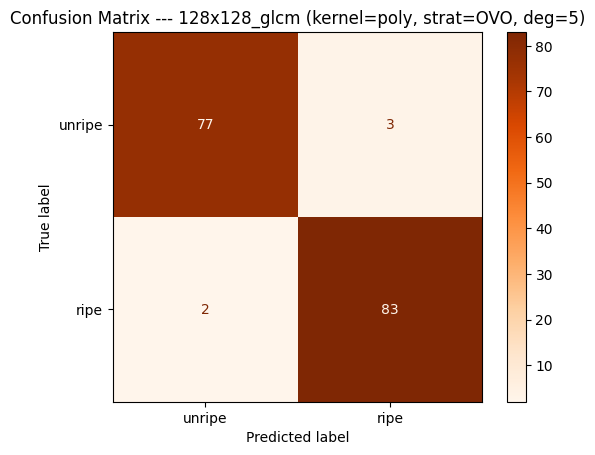


=== SVM (kernel=poly, degree=6, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9773    0.5375    0.6935        80
        ripe     0.6942    0.9882    0.8155        85

    accuracy                         0.7697       165
   macro avg     0.8357    0.7629    0.7545       165
weighted avg     0.8315    0.7697    0.7564       165



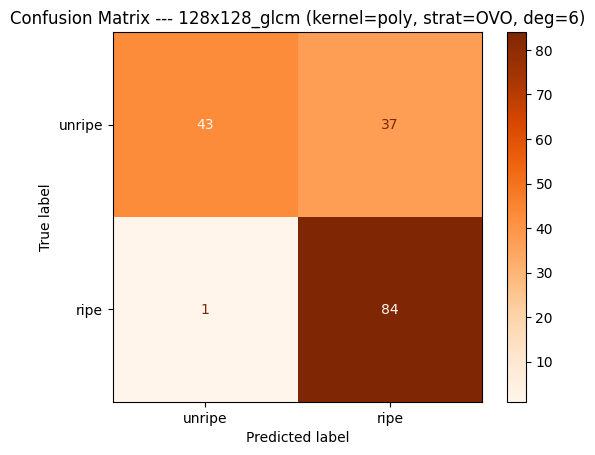


=== SVM (kernel=poly, degree=7, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7250    0.8406        80
        ripe     0.7944    1.0000    0.8854        85

    accuracy                         0.8667       165
   macro avg     0.8972    0.8625    0.8630       165
weighted avg     0.8941    0.8667    0.8637       165



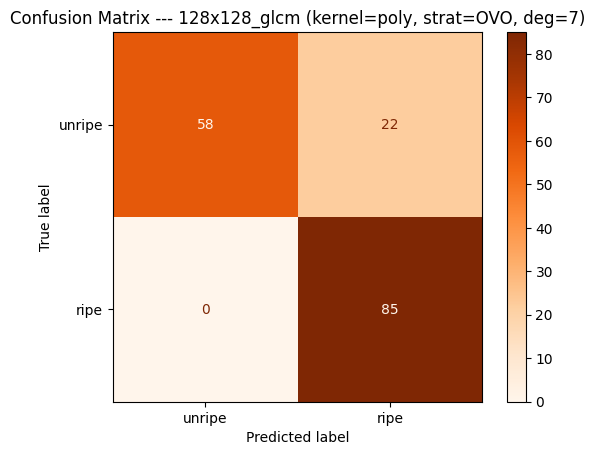


=== SVM (kernel=poly, degree=8, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9231    0.4500    0.6050        80
        ripe     0.6508    0.9647    0.7773        85

    accuracy                         0.7152       165
   macro avg     0.7869    0.7074    0.6911       165
weighted avg     0.7828    0.7152    0.6938       165



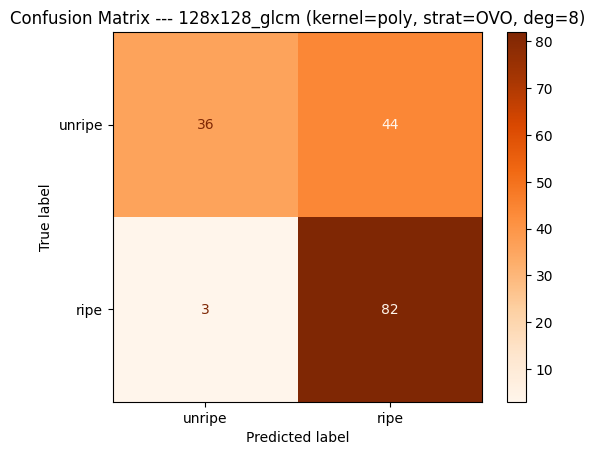


=== SVM (kernel=poly, degree=9, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.5750    0.7302        80
        ripe     0.7143    1.0000    0.8333        85

    accuracy                         0.7939       165
   macro avg     0.8571    0.7875    0.7817       165
weighted avg     0.8528    0.7939    0.7833       165



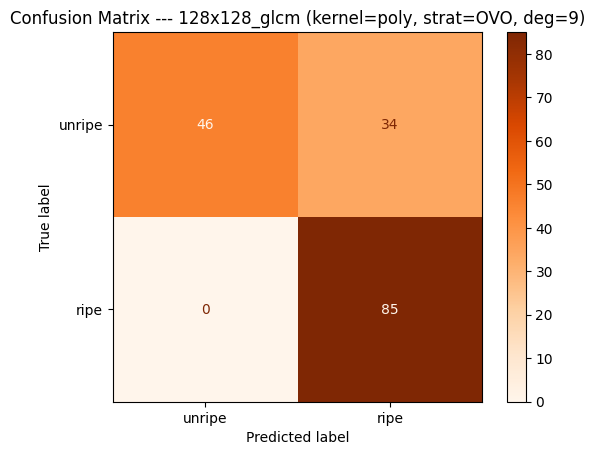


=== SVM (kernel=poly, degree=3, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9518    0.9875    0.9693        80
        ripe     0.9878    0.9529    0.9701        85

    accuracy                         0.9697       165
   macro avg     0.9698    0.9702    0.9697       165
weighted avg     0.9704    0.9697    0.9697       165



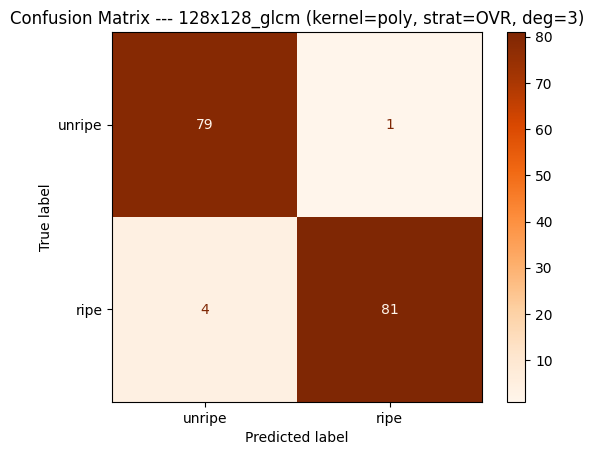


=== SVM (kernel=poly, degree=4, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9643    0.6750    0.7941        80
        ripe     0.7615    0.9765    0.8557        85

    accuracy                         0.8303       165
   macro avg     0.8629    0.8257    0.8249       165
weighted avg     0.8598    0.8303    0.8258       165



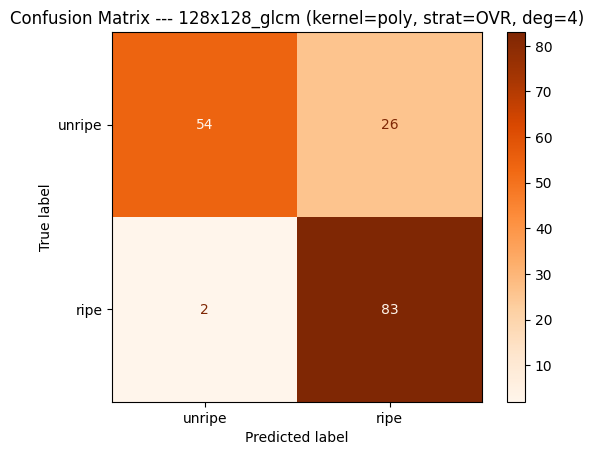


=== SVM (kernel=poly, degree=5, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



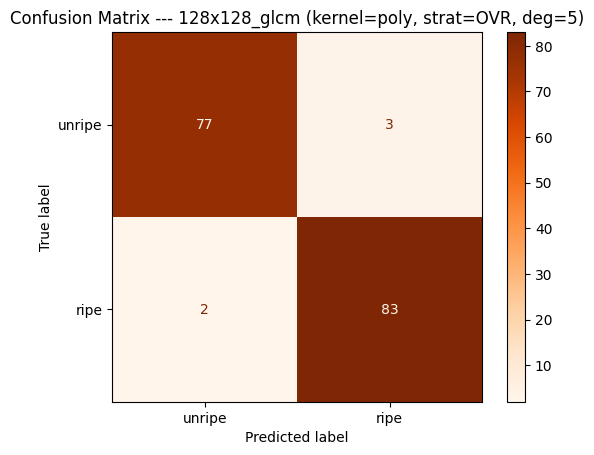


=== SVM (kernel=poly, degree=6, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9773    0.5375    0.6935        80
        ripe     0.6942    0.9882    0.8155        85

    accuracy                         0.7697       165
   macro avg     0.8357    0.7629    0.7545       165
weighted avg     0.8315    0.7697    0.7564       165



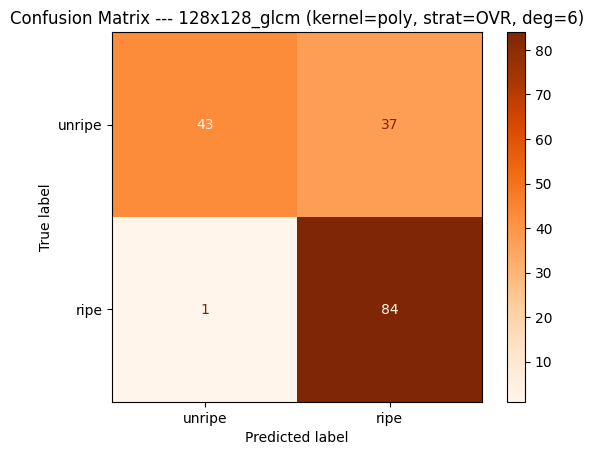


=== SVM (kernel=poly, degree=7, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.7250    0.8406        80
        ripe     0.7944    1.0000    0.8854        85

    accuracy                         0.8667       165
   macro avg     0.8972    0.8625    0.8630       165
weighted avg     0.8941    0.8667    0.8637       165



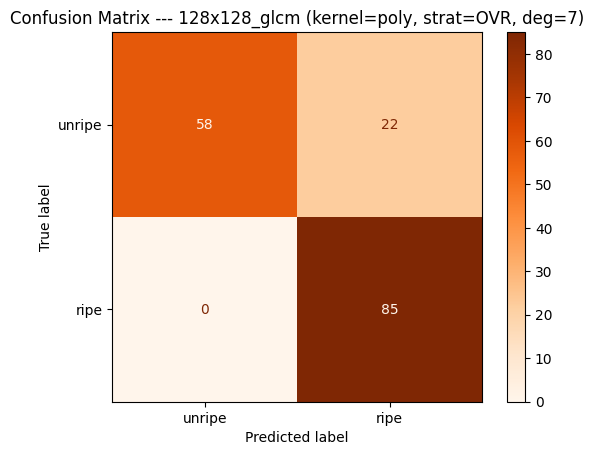


=== SVM (kernel=poly, degree=8, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9231    0.4500    0.6050        80
        ripe     0.6508    0.9647    0.7773        85

    accuracy                         0.7152       165
   macro avg     0.7869    0.7074    0.6911       165
weighted avg     0.7828    0.7152    0.6938       165



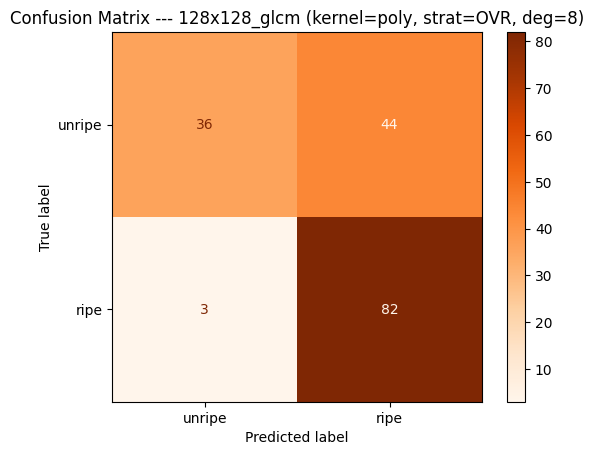


=== SVM (kernel=poly, degree=9, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.5750    0.7302        80
        ripe     0.7143    1.0000    0.8333        85

    accuracy                         0.7939       165
   macro avg     0.8571    0.7875    0.7817       165
weighted avg     0.8528    0.7939    0.7833       165



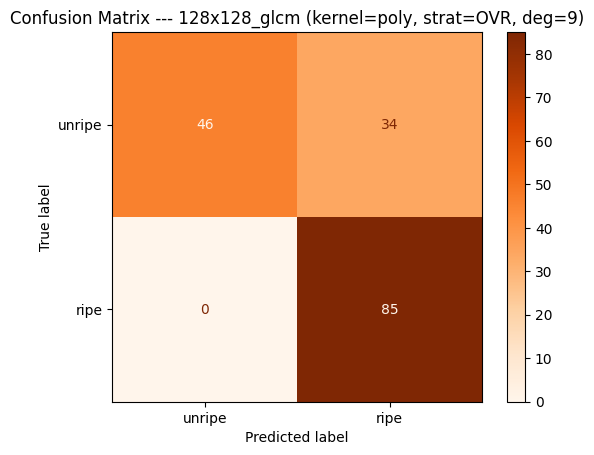


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_glcm\poly\poly_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_glcm\poly\poly_results_pairwise.csv


=== SVM (kernel=linear, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165



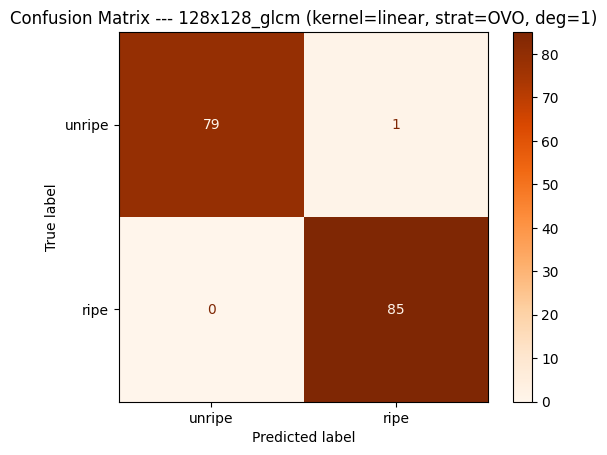


=== SVM (kernel=linear, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165



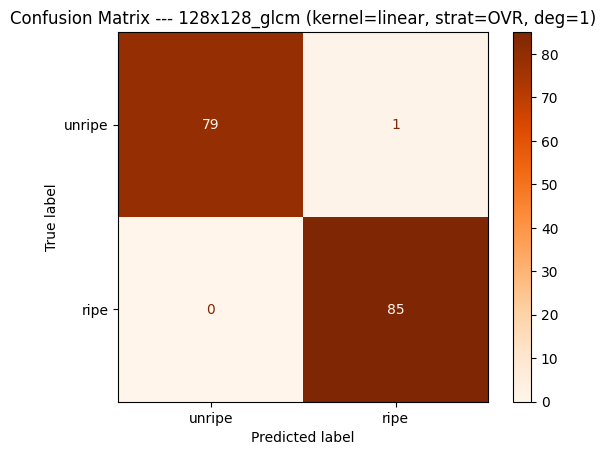


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_glcm\linear\linear_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_glcm\linear\linear_results_pairwise.csv


=== SVM (kernel=rbf, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9756    1.0000    0.9877        80
        ripe     1.0000    0.9765    0.9881        85

    accuracy                         0.9879       165
   macro avg     0.9878    0.9882    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165



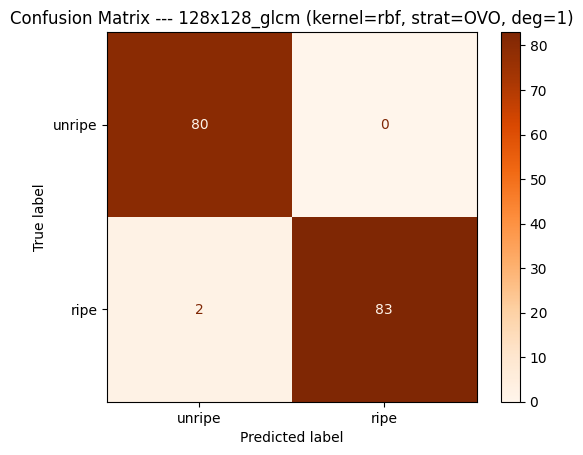


=== SVM (kernel=rbf, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9756    1.0000    0.9877        80
        ripe     1.0000    0.9765    0.9881        85

    accuracy                         0.9879       165
   macro avg     0.9878    0.9882    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165



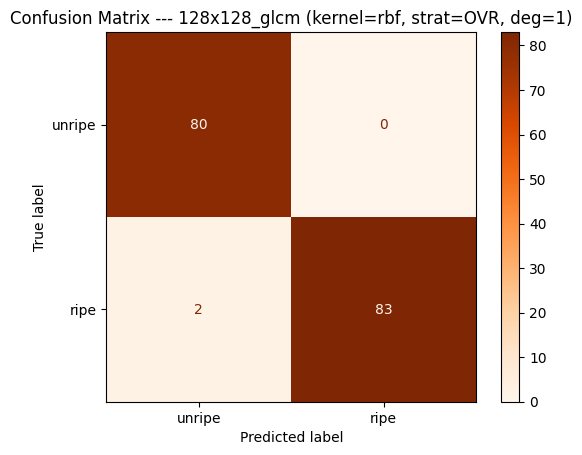


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_glcm\rbf\rbf_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_glcm\rbf\rbf_results_pairwise.csv


=== SVM (kernel=sigmoid, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9481    0.9125    0.9299        80
        ripe     0.9205    0.9529    0.9364        85

    accuracy                         0.9333       165
   macro avg     0.9343    0.9327    0.9332       165
weighted avg     0.9338    0.9333    0.9333       165



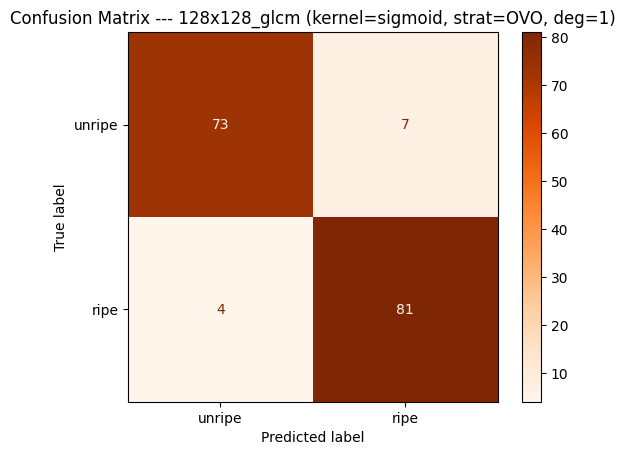


=== SVM (kernel=sigmoid, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9481    0.9125    0.9299        80
        ripe     0.9205    0.9529    0.9364        85

    accuracy                         0.9333       165
   macro avg     0.9343    0.9327    0.9332       165
weighted avg     0.9338    0.9333    0.9333       165



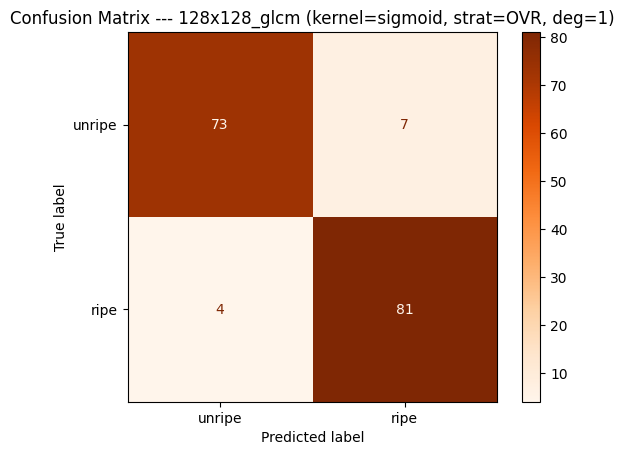


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_glcm\sigmoid\sigmoid_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_glcm\sigmoid\sigmoid_results_pairwise.csv


 Now running: 128x128_lbp

=== SVM (kernel=poly, degree=3, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9873    0.9750    0.9811        80
        ripe     0.9767    0.9882    0.9825        85

    accuracy                         0.9818       165
   macro avg     0.9820    0.9816    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165



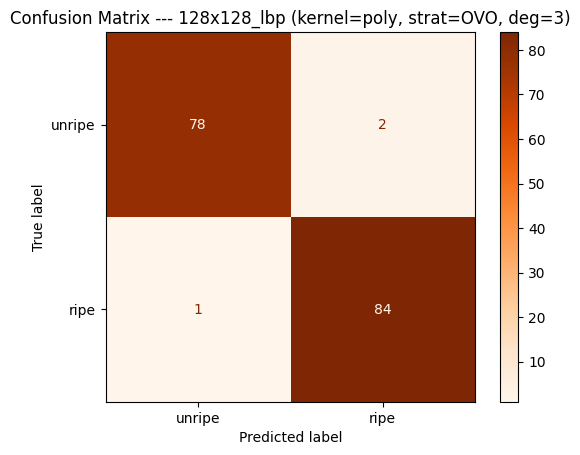


=== SVM (kernel=poly, degree=4, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8977    0.9875    0.9405        80
        ripe     0.9870    0.8941    0.9383        85

    accuracy                         0.9394       165
   macro avg     0.9424    0.9408    0.9394       165
weighted avg     0.9437    0.9394    0.9393       165



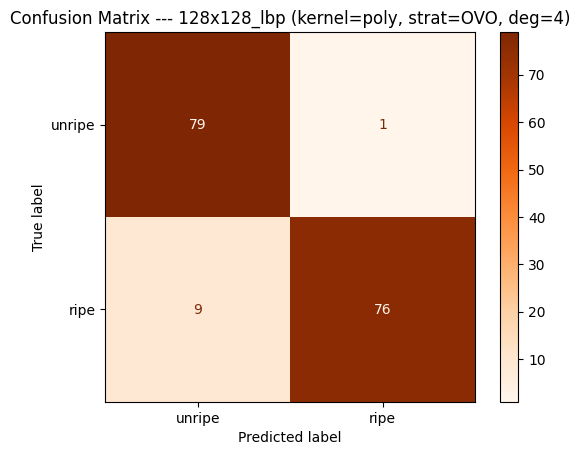


=== SVM (kernel=poly, degree=5, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8889    1.0000    0.9412        80
        ripe     1.0000    0.8824    0.9375        85

    accuracy                         0.9394       165
   macro avg     0.9444    0.9412    0.9393       165
weighted avg     0.9461    0.9394    0.9393       165



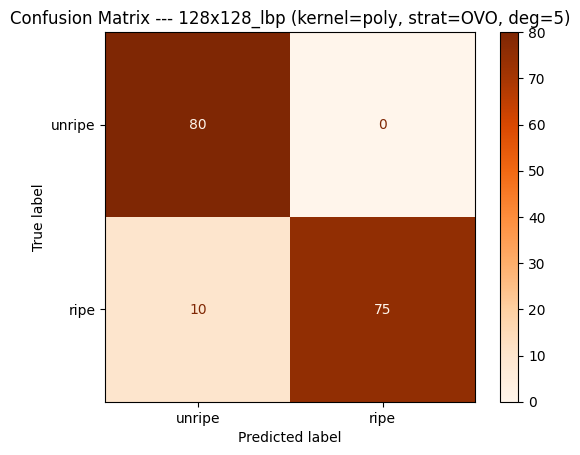


=== SVM (kernel=poly, degree=6, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8229    0.9875    0.8977        80
        ripe     0.9855    0.8000    0.8831        85

    accuracy                         0.8909       165
   macro avg     0.9042    0.8938    0.8904       165
weighted avg     0.9067    0.8909    0.8902       165



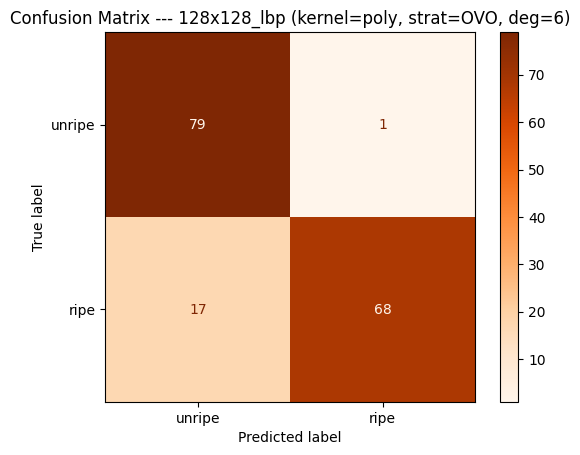


=== SVM (kernel=poly, degree=7, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8333    1.0000    0.9091        80
        ripe     1.0000    0.8118    0.8961        85

    accuracy                         0.9030       165
   macro avg     0.9167    0.9059    0.9026       165
weighted avg     0.9192    0.9030    0.9024       165



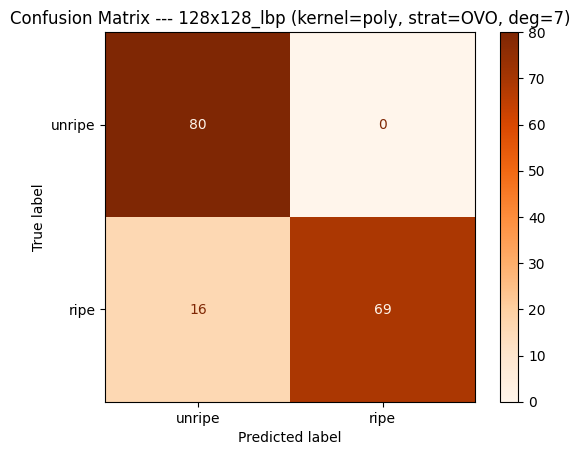


=== SVM (kernel=poly, degree=8, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.8061    0.9875    0.8876        80
        ripe     0.9851    0.7765    0.8684        85

    accuracy                         0.8788       165
   macro avg     0.8956    0.8820    0.8780       165
weighted avg     0.8983    0.8788    0.8777       165



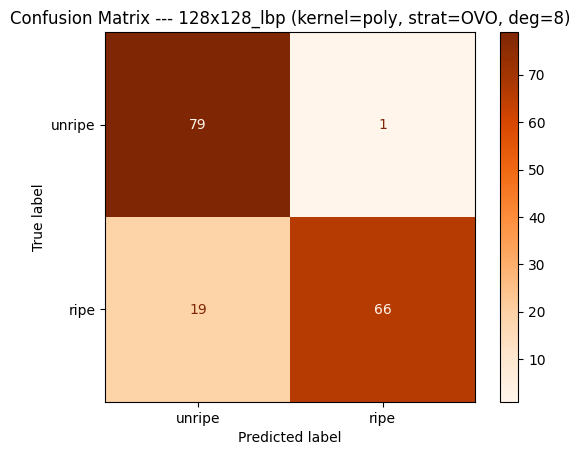


=== SVM (kernel=poly, degree=9, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.7619    1.0000    0.8649        80
        ripe     1.0000    0.7059    0.8276        85

    accuracy                         0.8485       165
   macro avg     0.8810    0.8529    0.8462       165
weighted avg     0.8846    0.8485    0.8457       165



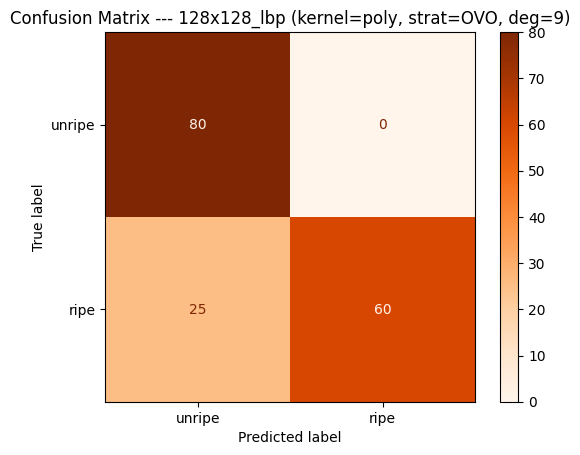


=== SVM (kernel=poly, degree=3, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9873    0.9750    0.9811        80
        ripe     0.9767    0.9882    0.9825        85

    accuracy                         0.9818       165
   macro avg     0.9820    0.9816    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165



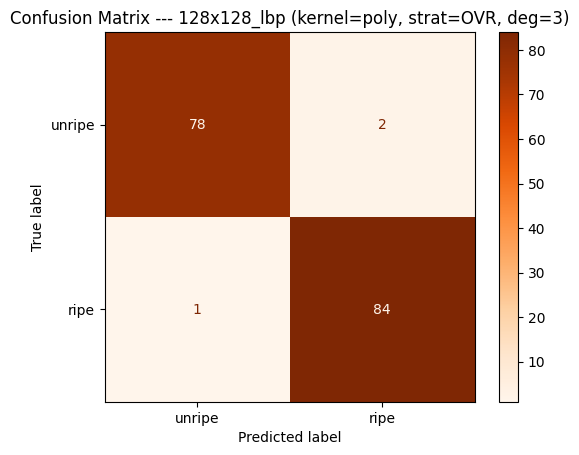


=== SVM (kernel=poly, degree=4, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8977    0.9875    0.9405        80
        ripe     0.9870    0.8941    0.9383        85

    accuracy                         0.9394       165
   macro avg     0.9424    0.9408    0.9394       165
weighted avg     0.9437    0.9394    0.9393       165



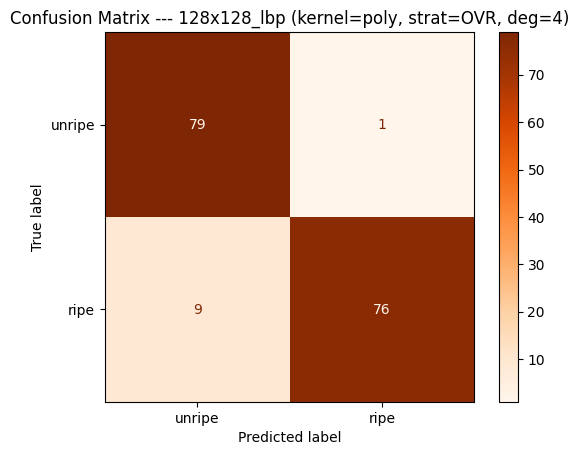


=== SVM (kernel=poly, degree=5, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8889    1.0000    0.9412        80
        ripe     1.0000    0.8824    0.9375        85

    accuracy                         0.9394       165
   macro avg     0.9444    0.9412    0.9393       165
weighted avg     0.9461    0.9394    0.9393       165



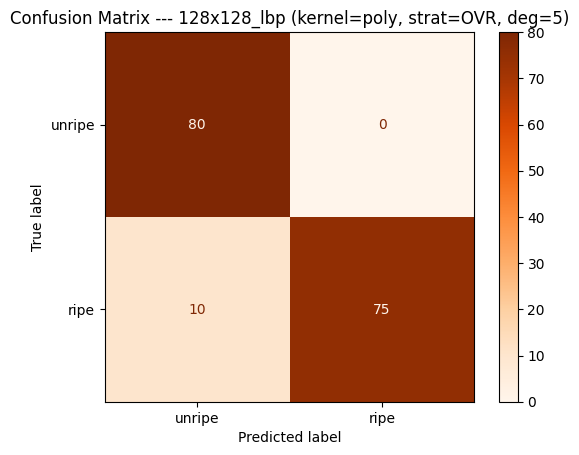


=== SVM (kernel=poly, degree=6, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8229    0.9875    0.8977        80
        ripe     0.9855    0.8000    0.8831        85

    accuracy                         0.8909       165
   macro avg     0.9042    0.8938    0.8904       165
weighted avg     0.9067    0.8909    0.8902       165



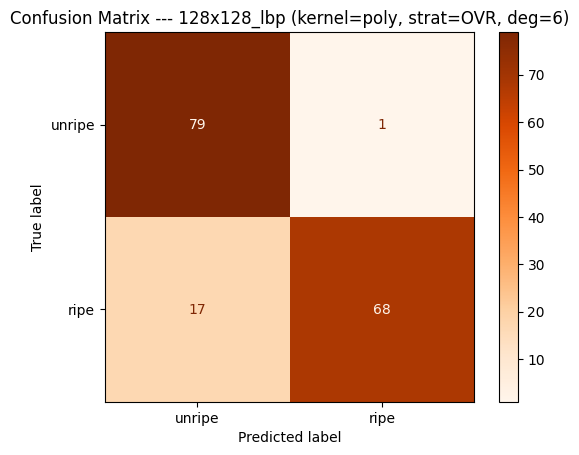


=== SVM (kernel=poly, degree=7, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8333    1.0000    0.9091        80
        ripe     1.0000    0.8118    0.8961        85

    accuracy                         0.9030       165
   macro avg     0.9167    0.9059    0.9026       165
weighted avg     0.9192    0.9030    0.9024       165



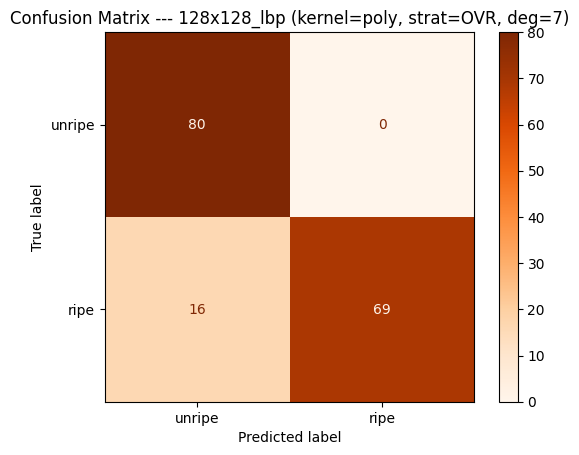


=== SVM (kernel=poly, degree=8, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.8061    0.9875    0.8876        80
        ripe     0.9851    0.7765    0.8684        85

    accuracy                         0.8788       165
   macro avg     0.8956    0.8820    0.8780       165
weighted avg     0.8983    0.8788    0.8777       165



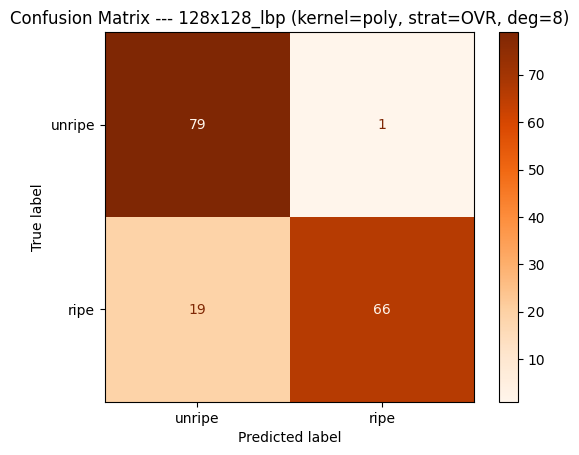


=== SVM (kernel=poly, degree=9, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.7619    1.0000    0.8649        80
        ripe     1.0000    0.7059    0.8276        85

    accuracy                         0.8485       165
   macro avg     0.8810    0.8529    0.8462       165
weighted avg     0.8846    0.8485    0.8457       165



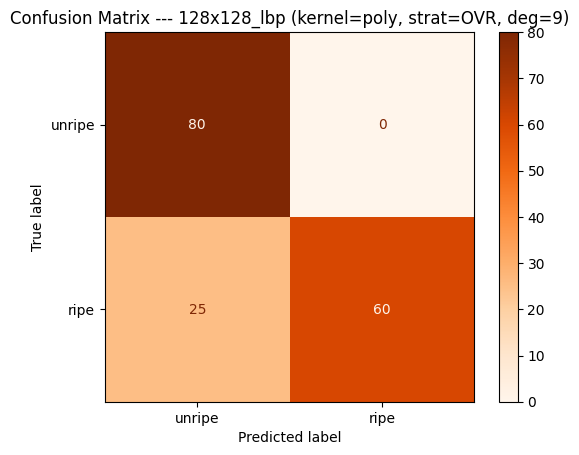


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lbp\poly\poly_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lbp\poly\poly_results_pairwise.csv


=== SVM (kernel=linear, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



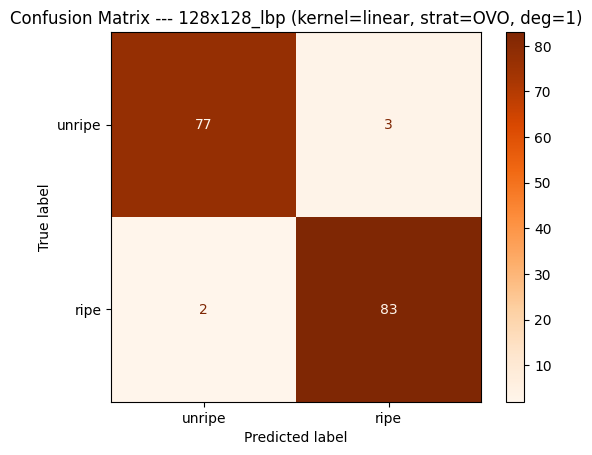


=== SVM (kernel=linear, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9747    0.9625    0.9686        80
        ripe     0.9651    0.9765    0.9708        85

    accuracy                         0.9697       165
   macro avg     0.9699    0.9695    0.9697       165
weighted avg     0.9698    0.9697    0.9697       165



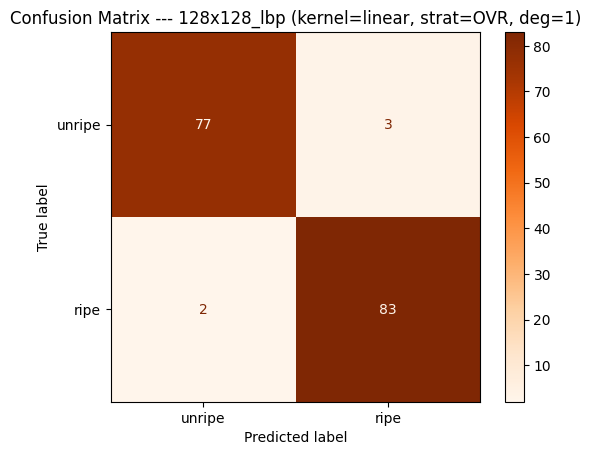


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lbp\linear\linear_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lbp\linear\linear_results_pairwise.csv


=== SVM (kernel=rbf, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165



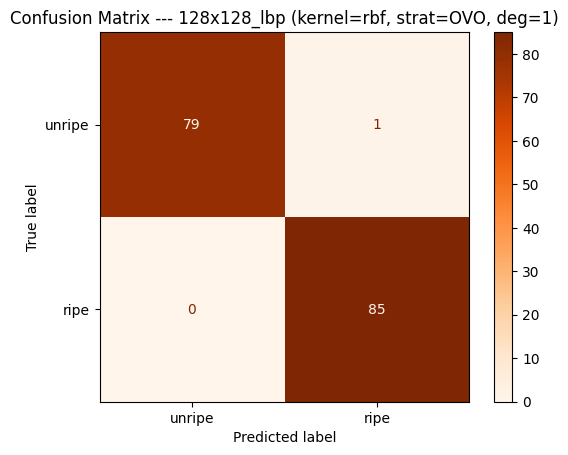


=== SVM (kernel=rbf, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165



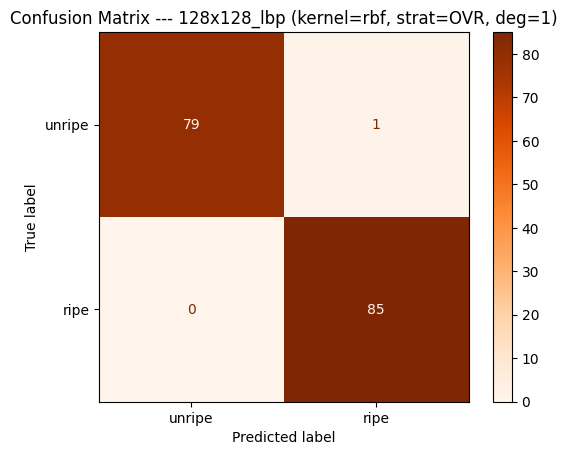


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lbp\rbf\rbf_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lbp\rbf\rbf_results_pairwise.csv


=== SVM (kernel=sigmoid, degree=1, strat=OVO) ===
              precision    recall  f1-score   support

      unripe     0.9474    0.9000    0.9231        80
        ripe     0.9101    0.9529    0.9310        85

    accuracy                         0.9273       165
   macro avg     0.9287    0.9265    0.9271       165
weighted avg     0.9282    0.9273    0.9272       165



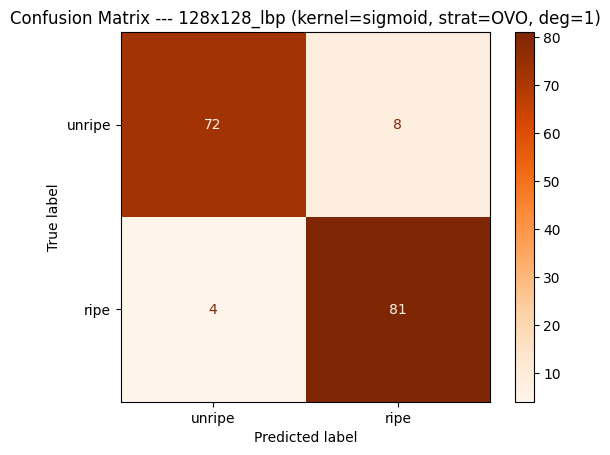


=== SVM (kernel=sigmoid, degree=1, strat=OVR) ===
              precision    recall  f1-score   support

      unripe     0.9474    0.9000    0.9231        80
        ripe     0.9101    0.9529    0.9310        85

    accuracy                         0.9273       165
   macro avg     0.9287    0.9265    0.9271       165
weighted avg     0.9282    0.9273    0.9272       165



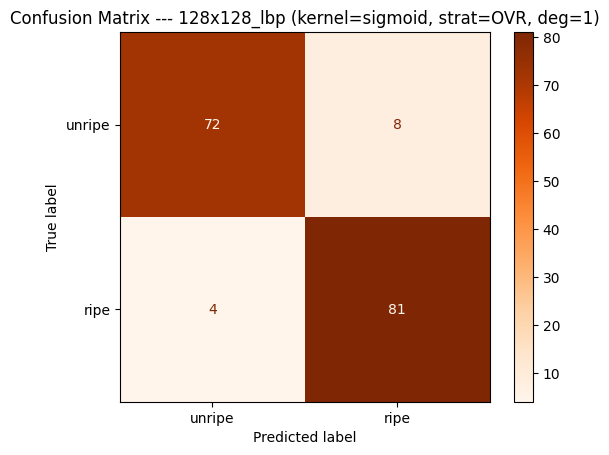


Saved:
  C:\Users\User\Desktop\Results\M2\128x128_lbp\sigmoid\sigmoid_results.csv
  C:\Users\User\Desktop\Results\M2\128x128_lbp\sigmoid\sigmoid_results_pairwise.csv



In [21]:
from svm_classification import svm_classification

base_dir = r"C:\Users\User\Desktop\FYP\Dataset\mango_2"
results_dir = r"C:\Users\User\Desktop\Results\M2"

feature_types = ['128x128_rgb', '128x128_his', '128x128_lab', '128x128_glcm', '128x128_lbp']

class_order=['unripe', 'ripe']

for feature_name in feature_types:
    train_csv = f"{base_dir}\\{feature_name}_train.csv"
    test_csv  = f"{base_dir}\\{feature_name}_test.csv"

    print(f"\n Now running: {feature_name}")

    svm_classification(
        train_csv     = train_csv,
        test_csv      = test_csv,
        feature_name  = feature_name,
        degrees       = list(range(3, 10)), 
        strategies    = ['ovo', 'ovr'],
        kernels       = ['poly'],
        class_order   = class_order,
        output_dir    = f"{results_dir}\\{feature_name}\\poly",
        out_csv_name  = f"poly_results.csv"
    )

    for kernel in ['linear', 'rbf', 'sigmoid']:
        svm_classification(
            train_csv     = train_csv,
            test_csv      = test_csv,
            feature_name  = feature_name,
            degrees       = [1],
            strategies    = ['ovo', 'ovr'],
            kernels       = [kernel],
            class_order   = class_order,
            output_dir    = f"{results_dir}\\{feature_name}\\{kernel}",
            out_csv_name  = f"{kernel}_results.csv"
        )


## Random Forest


--- Random Forest (n_estimators=10) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9750    0.9873        80
        ripe     0.9770    1.0000    0.9884        85

    accuracy                         0.9879       165
   macro avg     0.9885    0.9875    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165

Training time: 0.0120 seconds


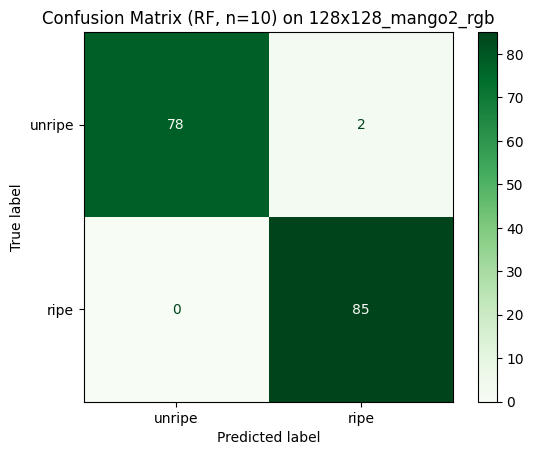

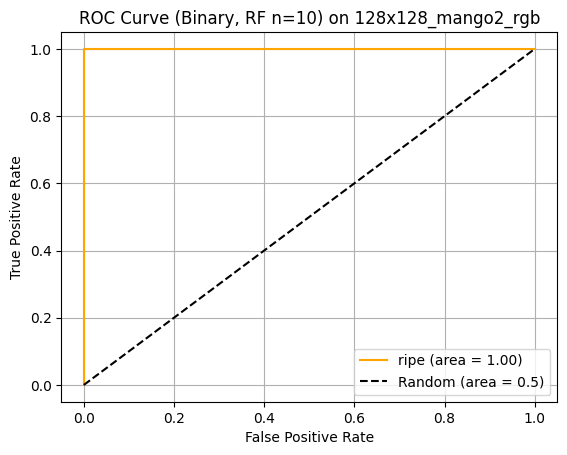


--- Random Forest (n_estimators=30) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.0305 seconds


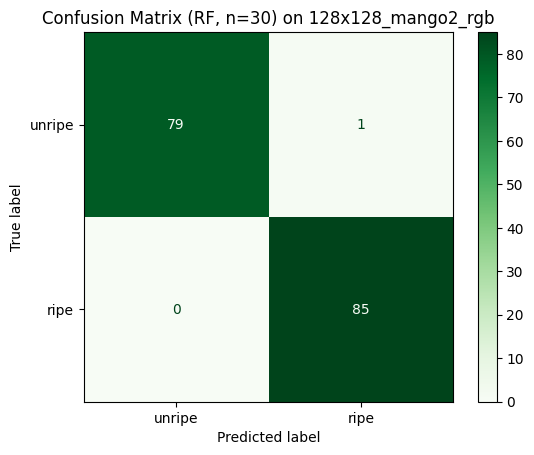

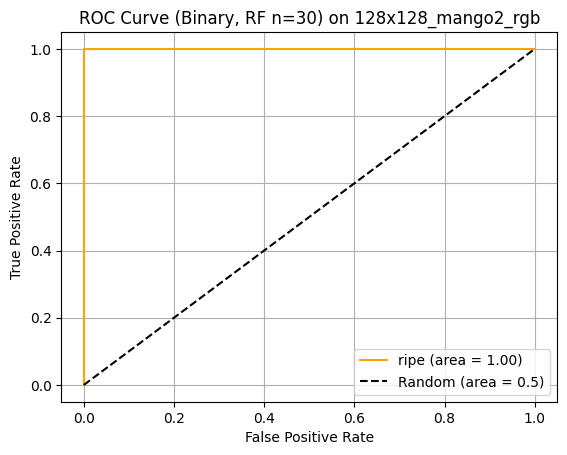


--- Random Forest (n_estimators=50) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.0505 seconds


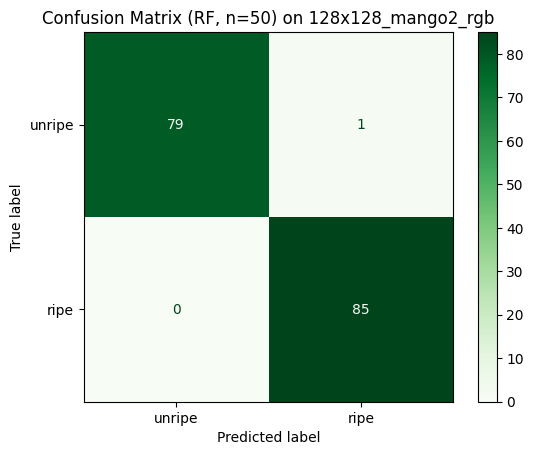

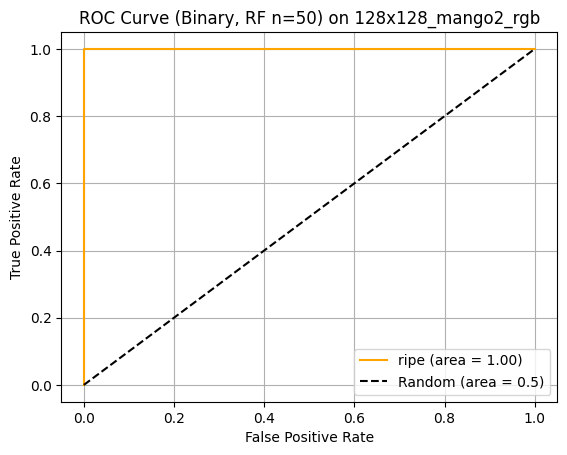


--- Random Forest (n_estimators=100) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.0963 seconds


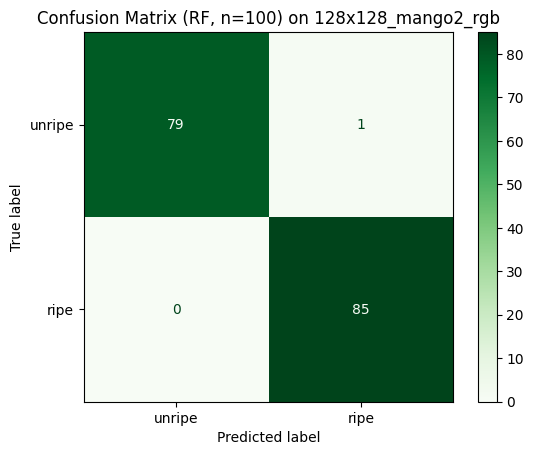

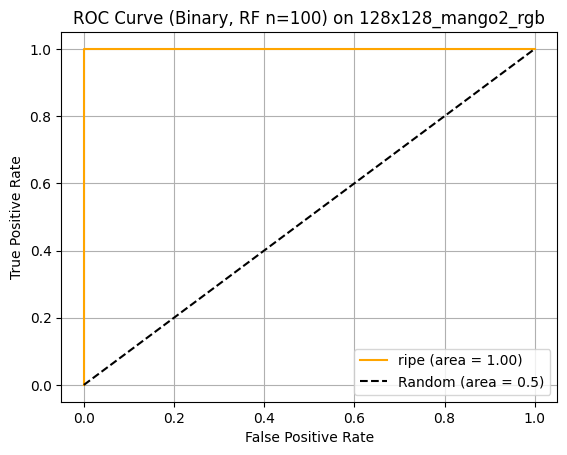


--- Random Forest (n_estimators=150) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.1448 seconds


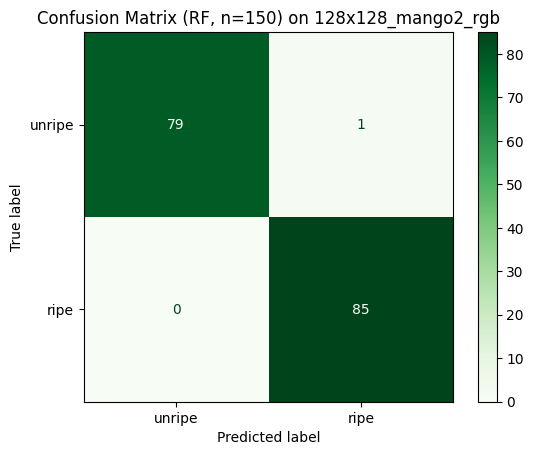

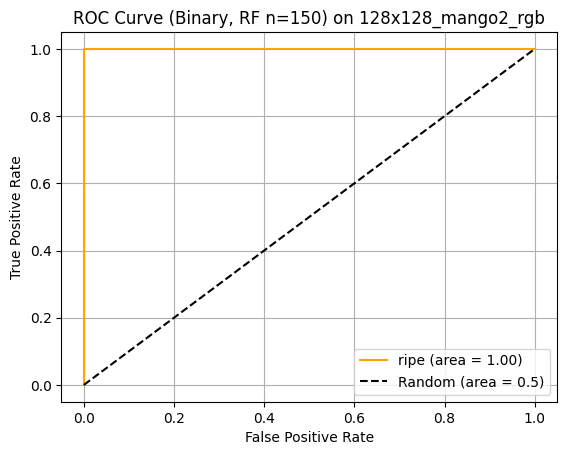


--- Random Forest (n_estimators=200) on 128x128_mango2_rgb ---
              precision    recall  f1-score   support

      unripe     1.0000    0.9875    0.9937        80
        ripe     0.9884    1.0000    0.9942        85

    accuracy                         0.9939       165
   macro avg     0.9942    0.9938    0.9939       165
weighted avg     0.9940    0.9939    0.9939       165

Training time: 0.2009 seconds


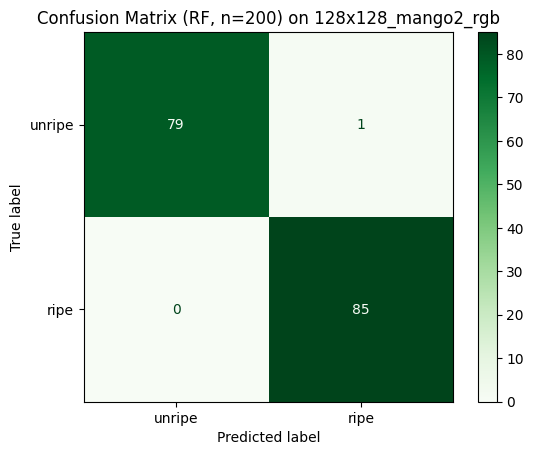

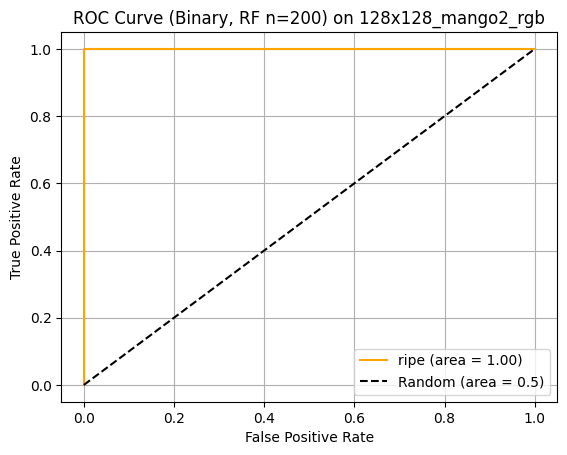

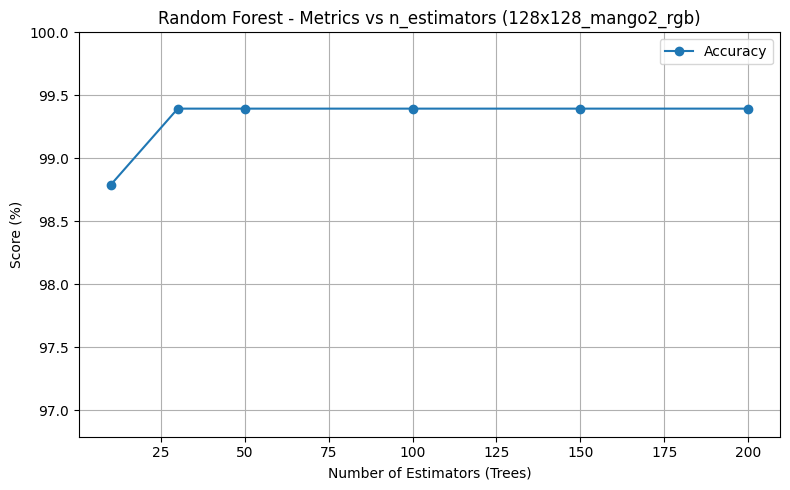

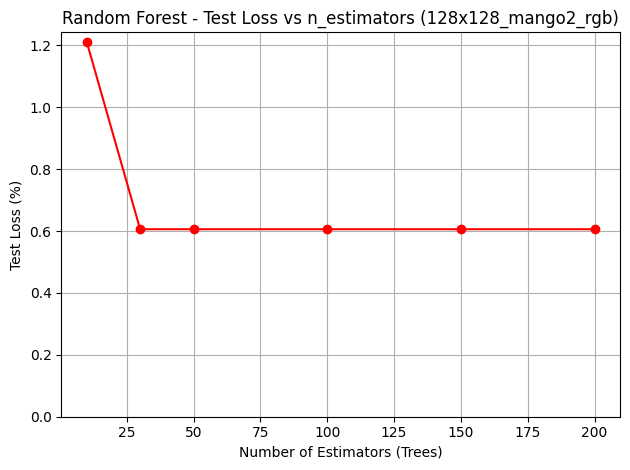

n_estimators  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  \
0            10     98.787879      98.815744   98.787879     98.787254   
1            30     99.393939      99.400987   99.393939     99.393806   
2            50     99.393939      99.400987   99.393939     99.393806   
3           100     99.393939      99.400987   99.393939     99.393806   
4           150     99.393939      99.400987   99.393939     99.393806   
5           200     99.393939      99.400987   99.393939     99.393806   

   Test Loss (%)  Training Time (s)  
0       1.212121           0.011999  
1       0.606061           0.030519  
2       0.606061           0.050511  
3       0.606061           0.096274  
4       0.606061           0.144772  
5       0.606061           0.200904

In [23]:
from rf_classification import rf_classification

rf_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_rgb_test.csv",
    feature="128x128_mango2_rgb",
    class_order=['unripe', 'ripe']
)


--- Random Forest (n_estimators=10) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0090 seconds


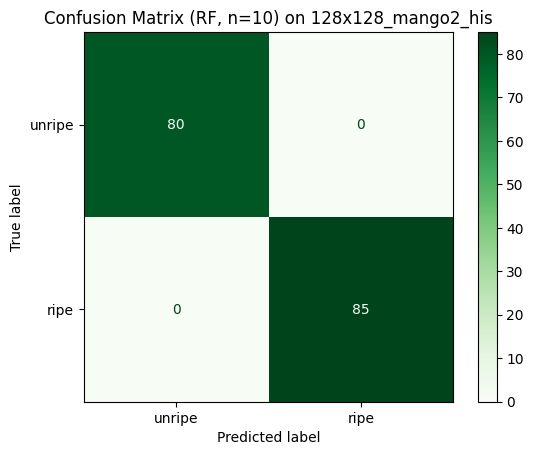

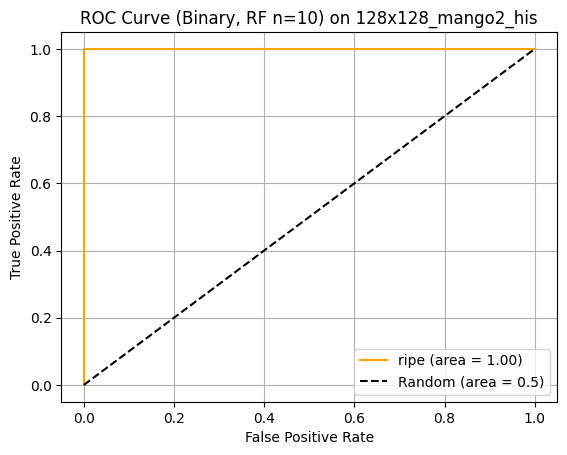


--- Random Forest (n_estimators=30) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0240 seconds


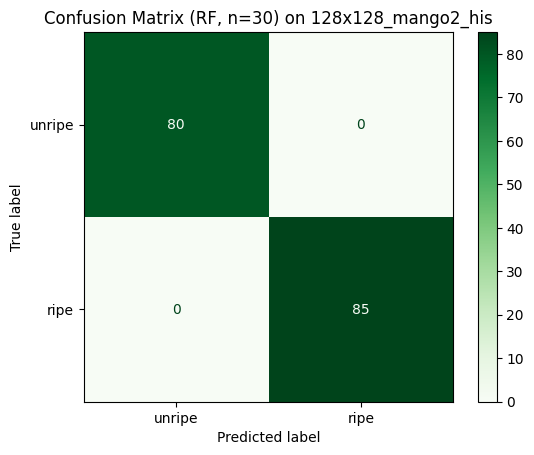

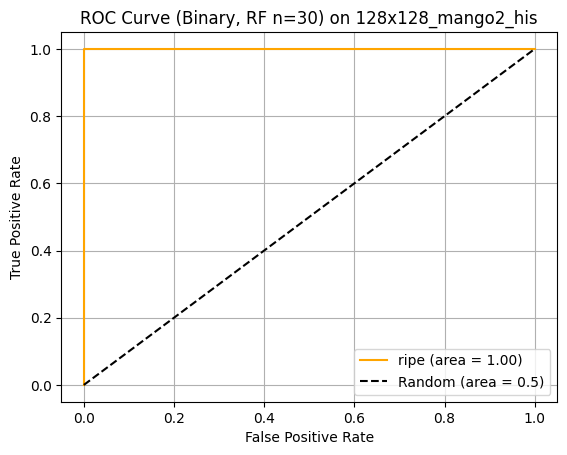


--- Random Forest (n_estimators=50) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0445 seconds


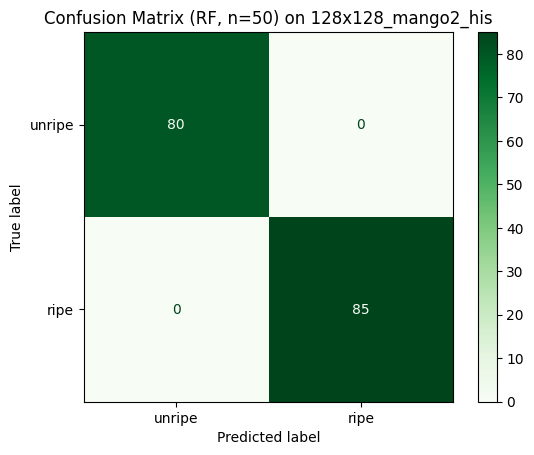

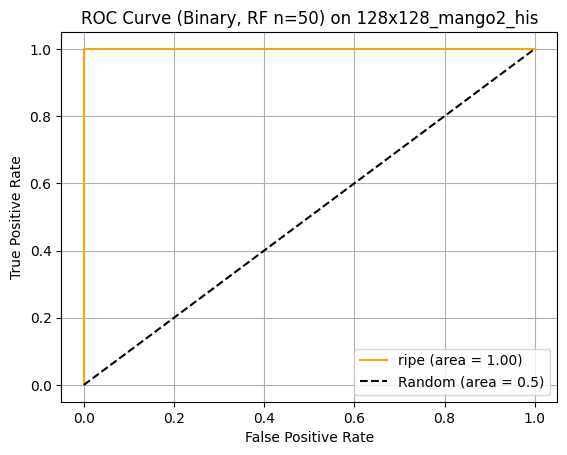


--- Random Forest (n_estimators=100) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0795 seconds


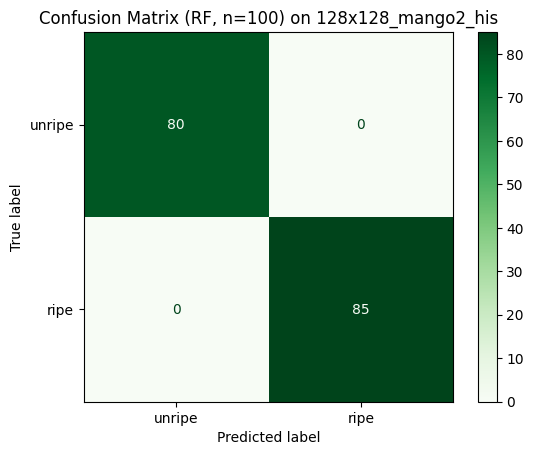

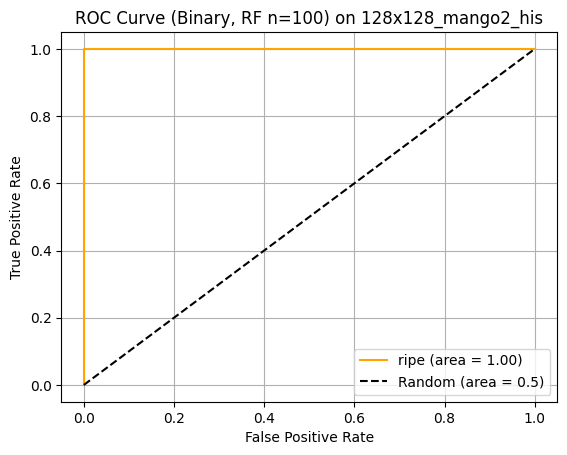


--- Random Forest (n_estimators=150) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.1185 seconds


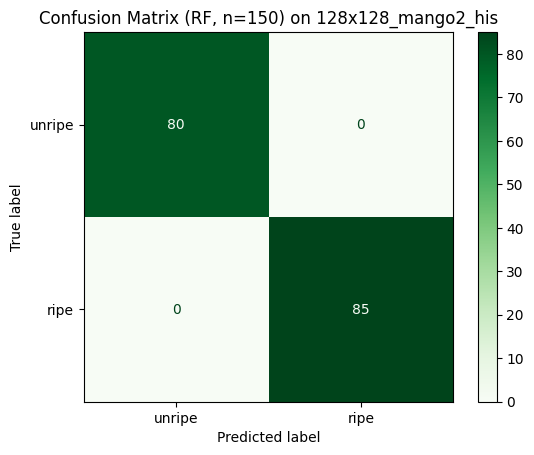

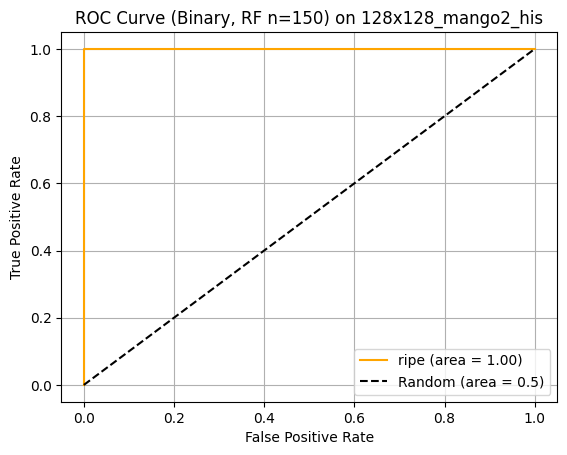


--- Random Forest (n_estimators=200) on 128x128_mango2_his ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.1609 seconds


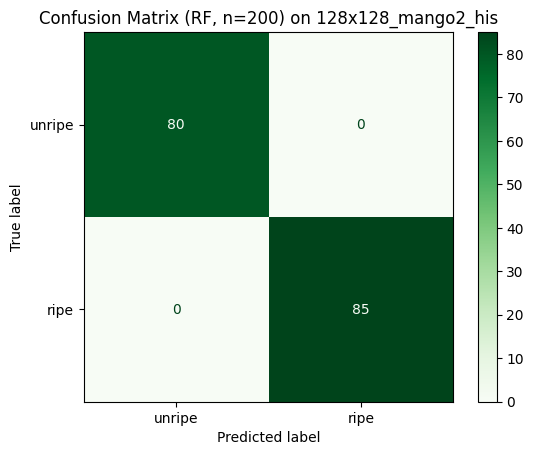

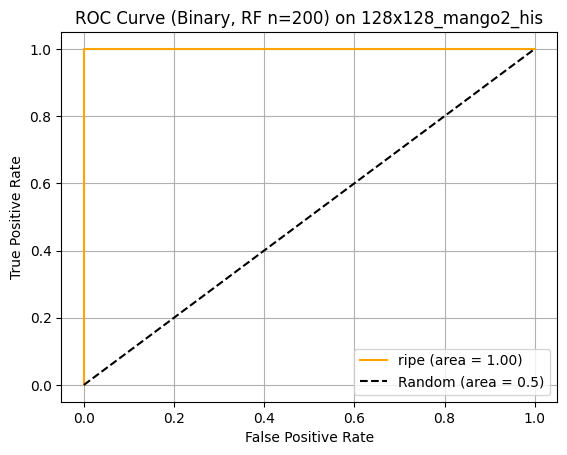

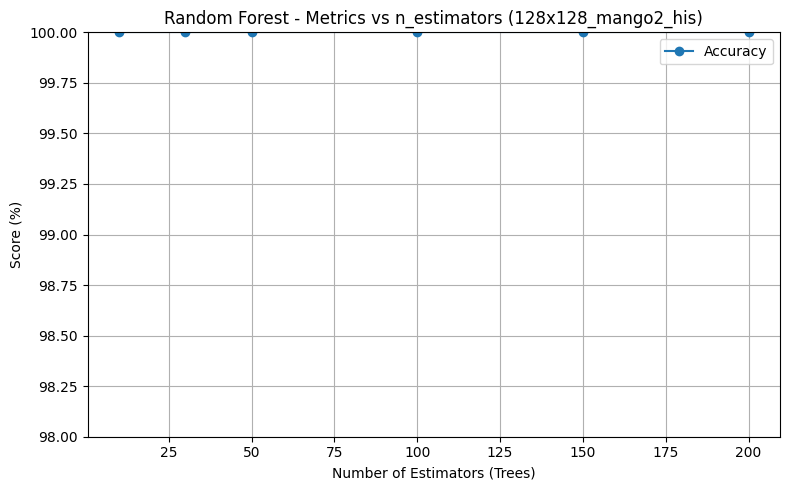

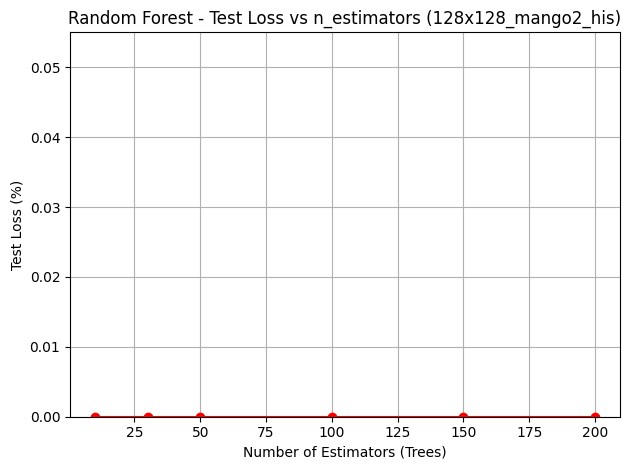

n_estimators  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  \
0            10         100.0          100.0       100.0         100.0   
1            30         100.0          100.0       100.0         100.0   
2            50         100.0          100.0       100.0         100.0   
3           100         100.0          100.0       100.0         100.0   
4           150         100.0          100.0       100.0         100.0   
5           200         100.0          100.0       100.0         100.0   

   Test Loss (%)  Training Time (s)  
0            0.0           0.009000  
1            0.0           0.024000  
2            0.0           0.044509  
3            0.0           0.079510  
4            0.0           0.118510  
5            0.0           0.160861

In [24]:
from rf_classification import rf_classification

rf_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_his_test.csv",
    feature="128x128_mango2_his",
    class_order=['unripe', 'ripe']
)


--- Random Forest (n_estimators=10) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0140 seconds


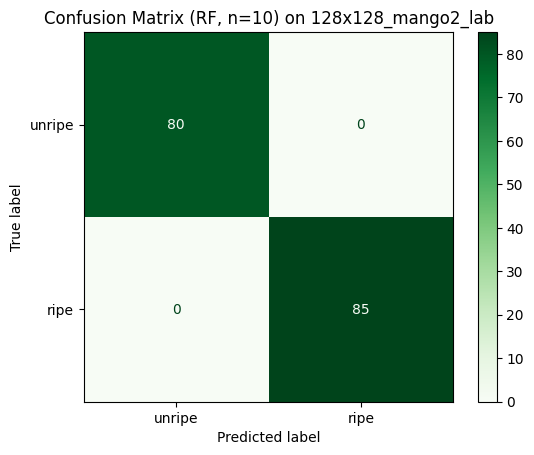

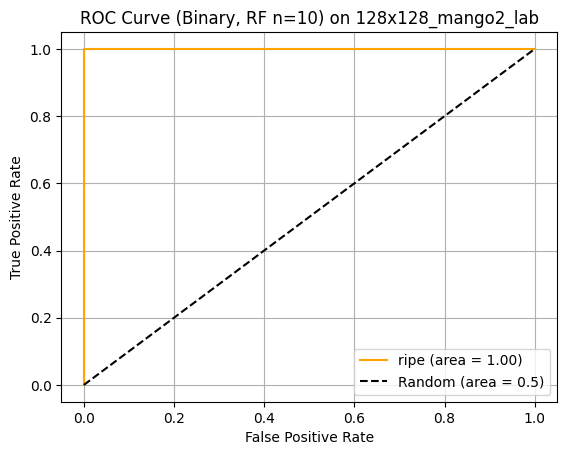


--- Random Forest (n_estimators=30) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0280 seconds


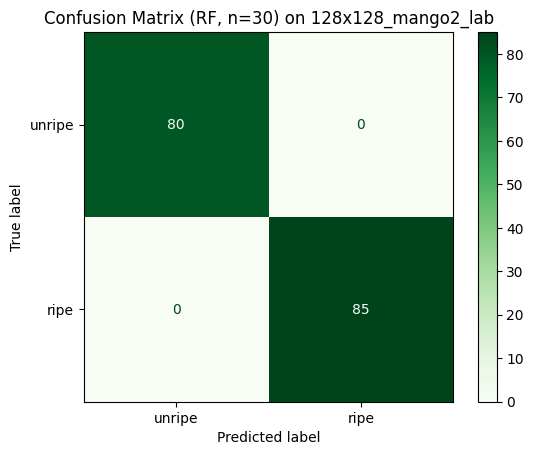

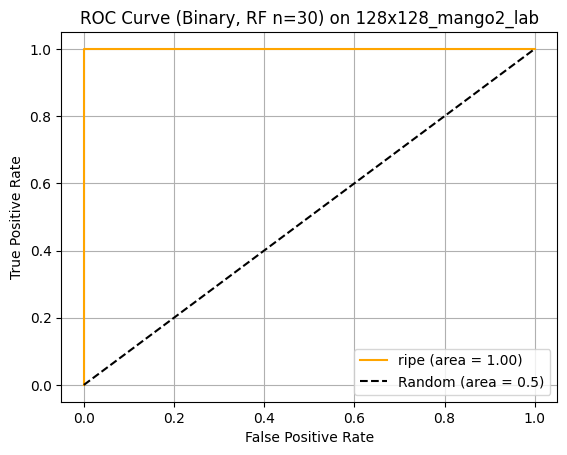


--- Random Forest (n_estimators=50) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.0460 seconds


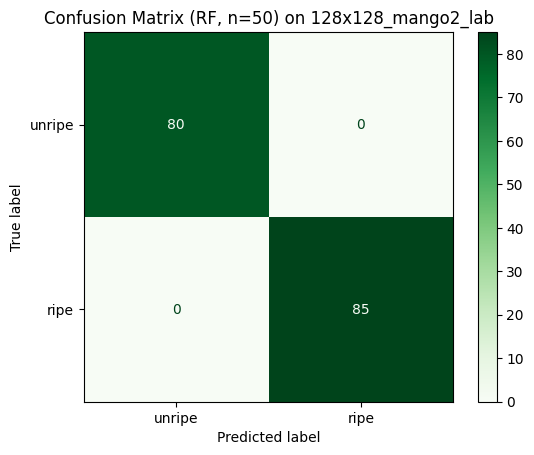

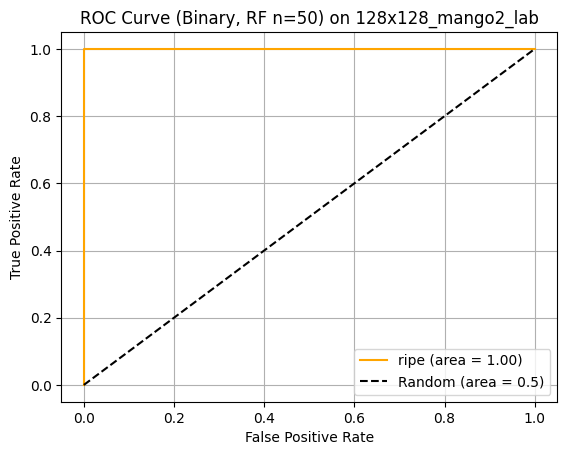


--- Random Forest (n_estimators=100) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.1005 seconds


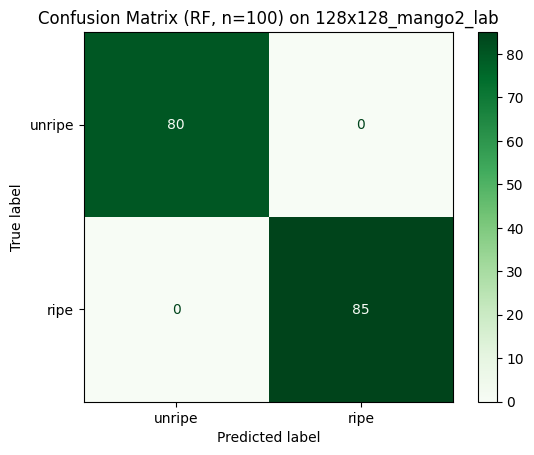

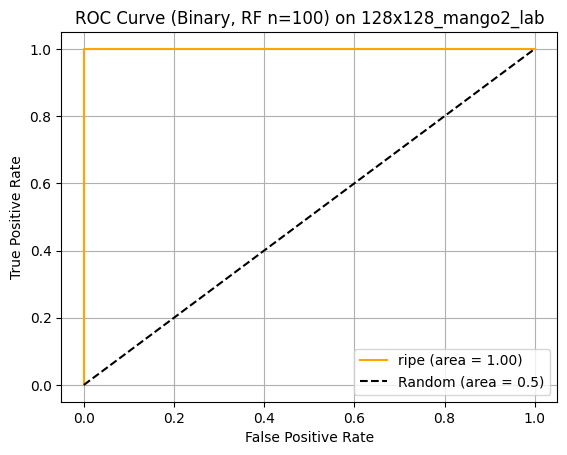


--- Random Forest (n_estimators=150) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.1290 seconds


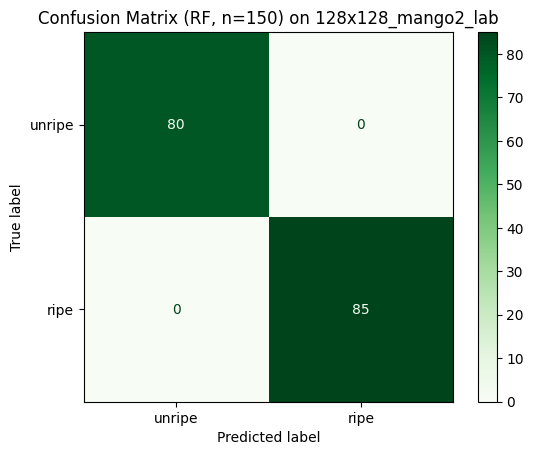

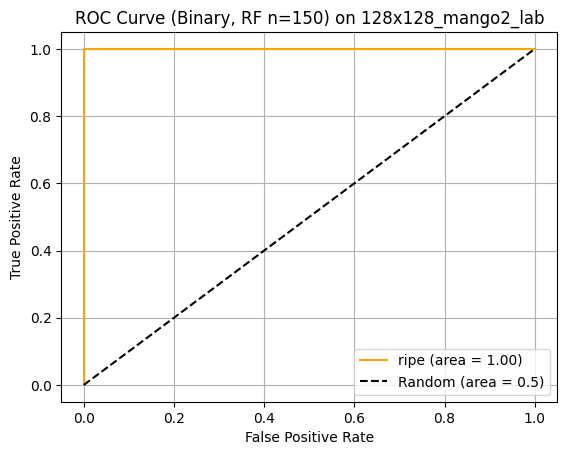


--- Random Forest (n_estimators=200) on 128x128_mango2_lab ---
              precision    recall  f1-score   support

      unripe     1.0000    1.0000    1.0000        80
        ripe     1.0000    1.0000    1.0000        85

    accuracy                         1.0000       165
   macro avg     1.0000    1.0000    1.0000       165
weighted avg     1.0000    1.0000    1.0000       165

Training time: 0.1809 seconds


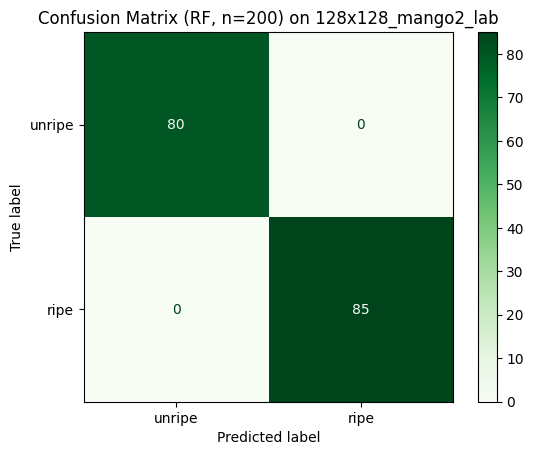

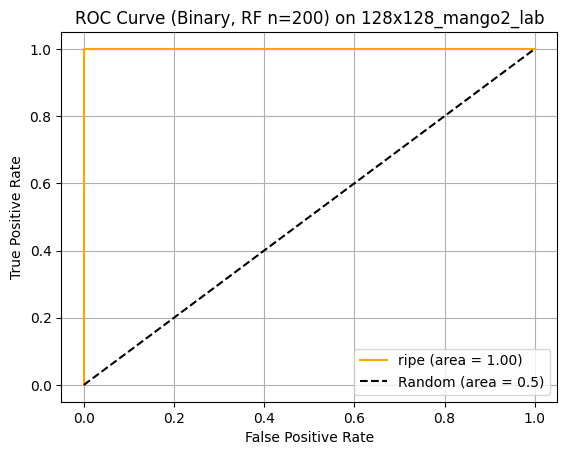

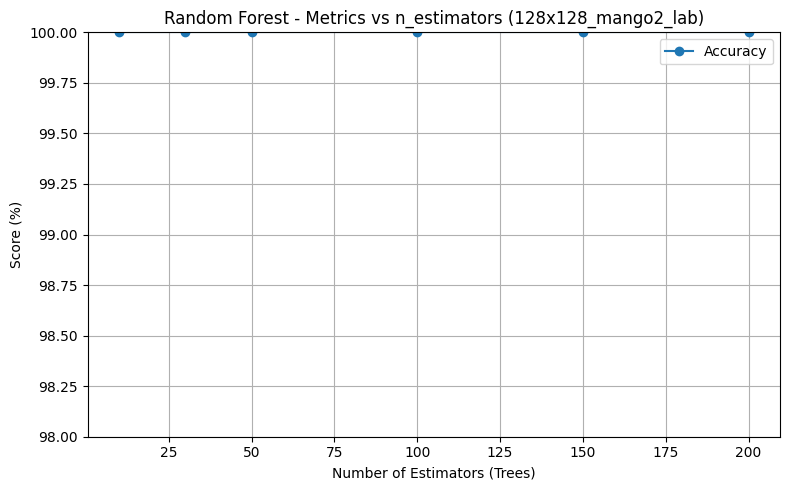

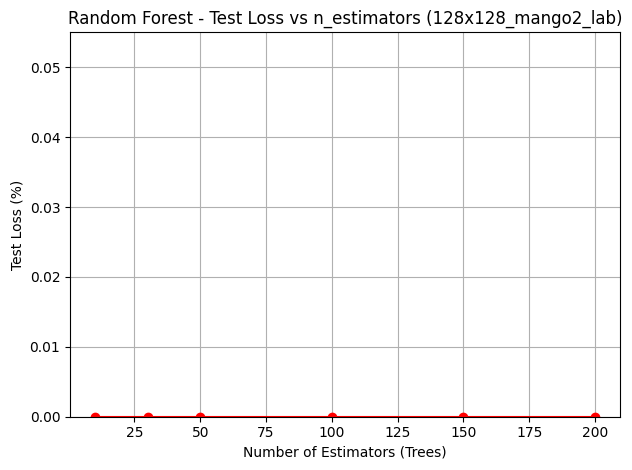

n_estimators  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  \
0            10         100.0          100.0       100.0         100.0   
1            30         100.0          100.0       100.0         100.0   
2            50         100.0          100.0       100.0         100.0   
3           100         100.0          100.0       100.0         100.0   
4           150         100.0          100.0       100.0         100.0   
5           200         100.0          100.0       100.0         100.0   

   Test Loss (%)  Training Time (s)  
0            0.0           0.013999  
1            0.0           0.028002  
2            0.0           0.046001  
3            0.0           0.100509  
4            0.0           0.129026  
5            0.0           0.180895

In [25]:
from rf_classification import rf_classification

rf_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lab_test.csv",
    feature="128x128_mango2_lab",
    class_order=['unripe', 'ripe']
)


--- Random Forest (n_estimators=10) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9605    0.9125    0.9359        80
        ripe     0.9213    0.9647    0.9425        85

    accuracy                         0.9394       165
   macro avg     0.9409    0.9386    0.9392       165
weighted avg     0.9403    0.9394    0.9393       165

Training time: 0.0180 seconds


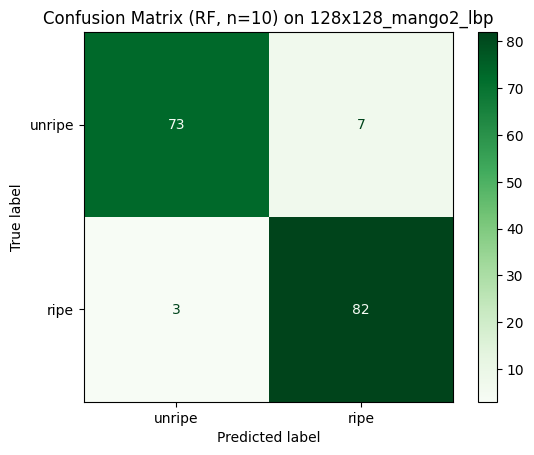

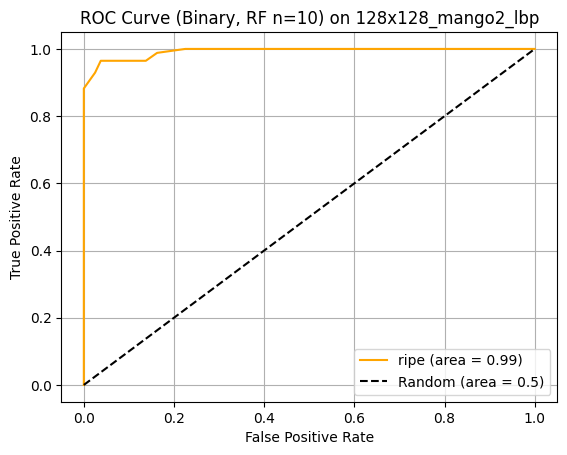


--- Random Forest (n_estimators=30) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9868    0.9375    0.9615        80
        ripe     0.9438    0.9882    0.9655        85

    accuracy                         0.9636       165
   macro avg     0.9653    0.9629    0.9635       165
weighted avg     0.9647    0.9636    0.9636       165

Training time: 0.0510 seconds


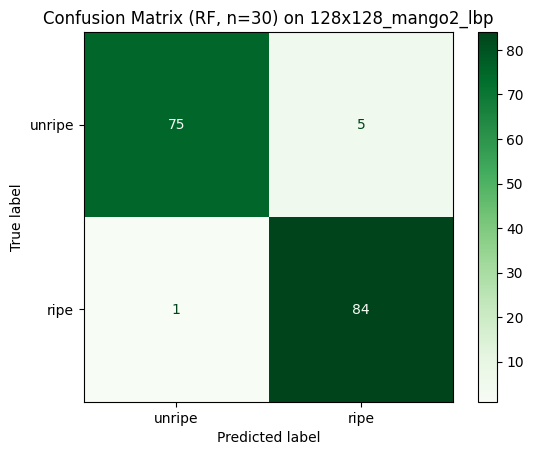

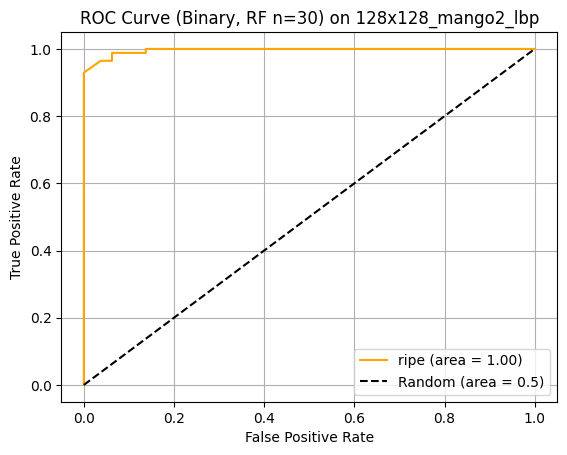


--- Random Forest (n_estimators=50) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9744    0.9500    0.9620        80
        ripe     0.9540    0.9765    0.9651        85

    accuracy                         0.9636       165
   macro avg     0.9642    0.9632    0.9636       165
weighted avg     0.9639    0.9636    0.9636       165

Training time: 0.0825 seconds


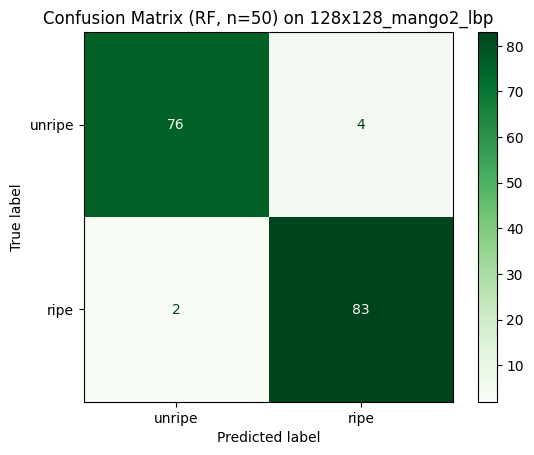

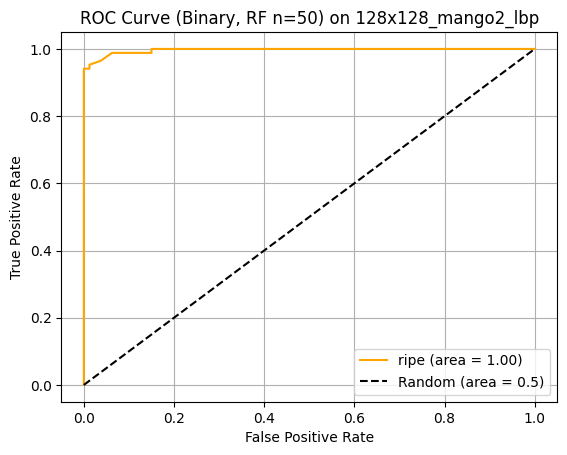


--- Random Forest (n_estimators=100) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9870    0.9500    0.9682        80
        ripe     0.9545    0.9882    0.9711        85

    accuracy                         0.9697       165
   macro avg     0.9708    0.9691    0.9696       165
weighted avg     0.9703    0.9697    0.9697       165

Training time: 0.1655 seconds


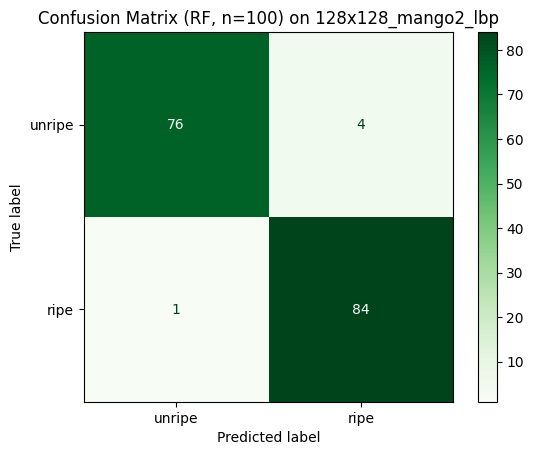

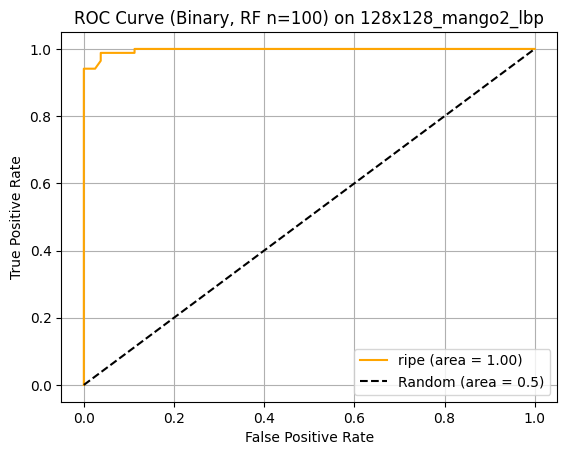


--- Random Forest (n_estimators=150) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9868    0.9375    0.9615        80
        ripe     0.9438    0.9882    0.9655        85

    accuracy                         0.9636       165
   macro avg     0.9653    0.9629    0.9635       165
weighted avg     0.9647    0.9636    0.9636       165

Training time: 0.2440 seconds


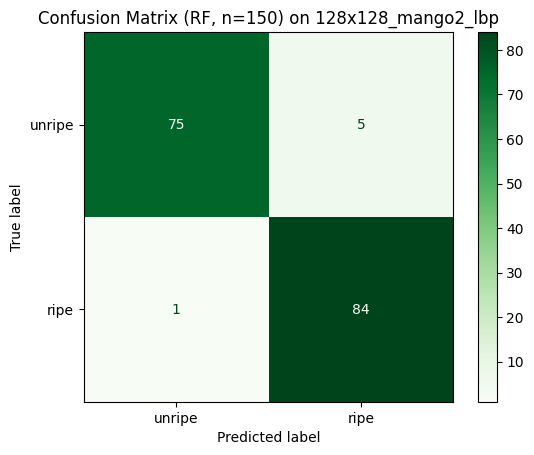

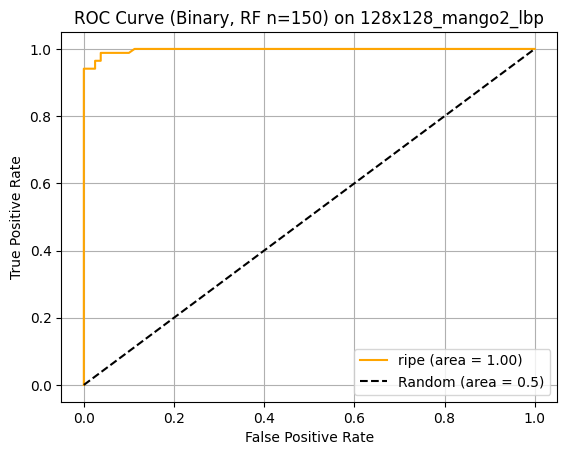


--- Random Forest (n_estimators=200) on 128x128_mango2_lbp ---
              precision    recall  f1-score   support

      unripe     0.9870    0.9500    0.9682        80
        ripe     0.9545    0.9882    0.9711        85

    accuracy                         0.9697       165
   macro avg     0.9708    0.9691    0.9696       165
weighted avg     0.9703    0.9697    0.9697       165

Training time: 0.3255 seconds


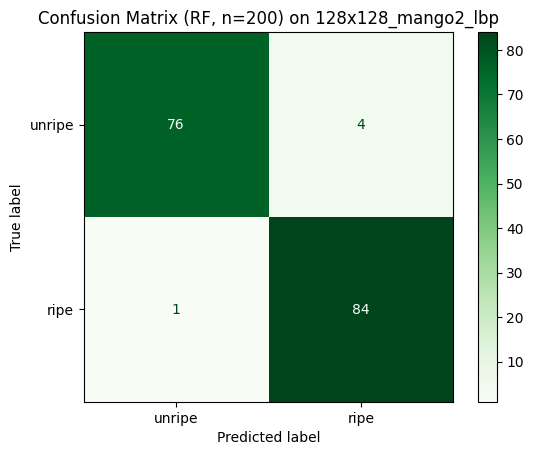

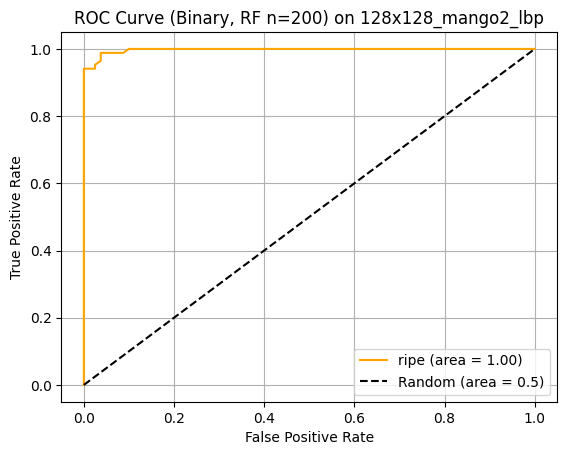

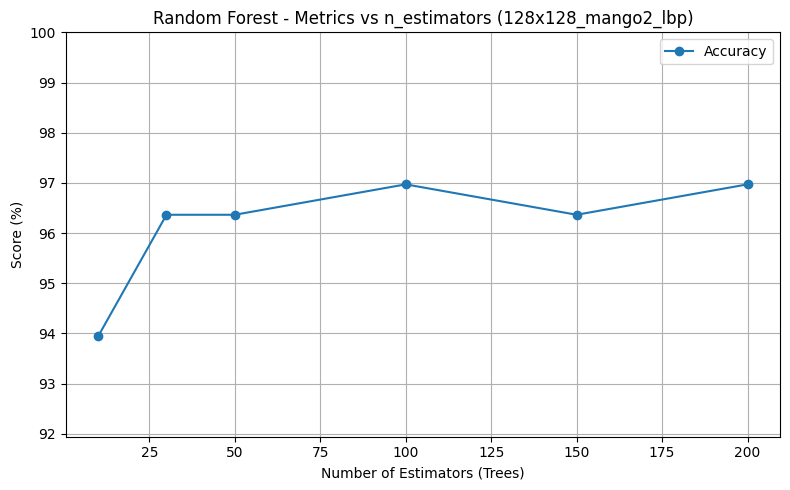

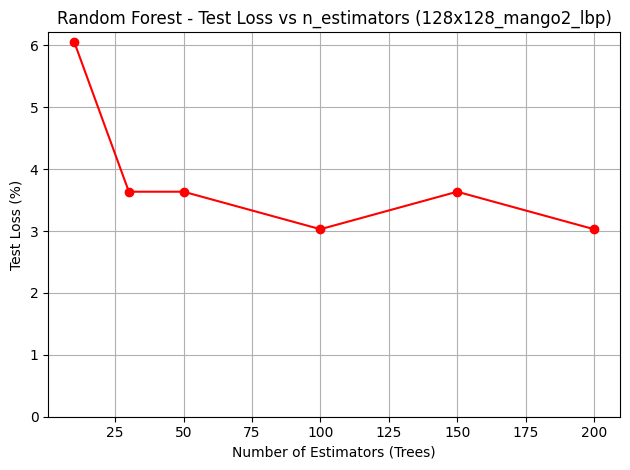

n_estimators  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  \
0            10     93.939394      94.034371   93.939394     93.931356   
1            30     96.363636      96.467932   96.363636     96.358814   
2            50     96.363636      96.388286   96.363636     96.361763   
3           100     96.969697      97.028729   96.969697     96.967019   
4           150     96.363636      96.467932   96.363636     96.358814   
5           200     96.969697      97.028729   96.969697     96.967019   

   Test Loss (%)  Training Time (s)  
0       6.060606           0.017998  
1       3.636364           0.050997  
2       3.636364           0.082507  
3       3.030303           0.165510  
4       3.636364           0.244024  
5       3.030303           0.325527

In [26]:
from rf_classification import rf_classification

rf_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_lbp_test.csv",
    feature="128x128_mango2_lbp",
    class_order=['unripe', 'ripe']
)


--- Random Forest (n_estimators=10) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9753    0.9875    0.9814        80
        ripe     0.9881    0.9765    0.9822        85

    accuracy                         0.9818       165
   macro avg     0.9817    0.9820    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.0120 seconds


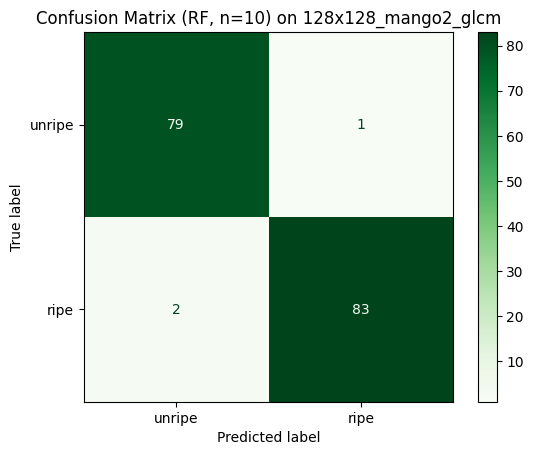

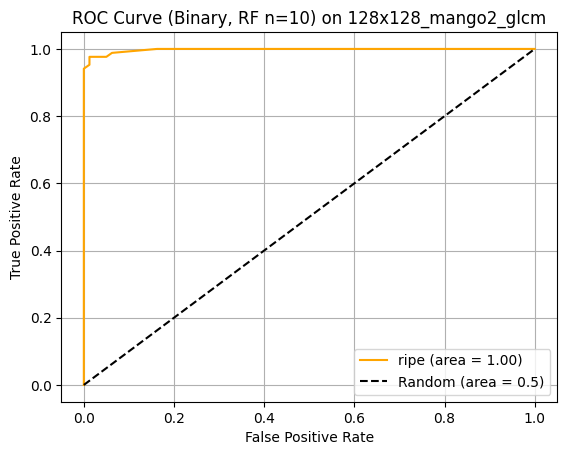


--- Random Forest (n_estimators=30) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9753    0.9875    0.9814        80
        ripe     0.9881    0.9765    0.9822        85

    accuracy                         0.9818       165
   macro avg     0.9817    0.9820    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.0351 seconds


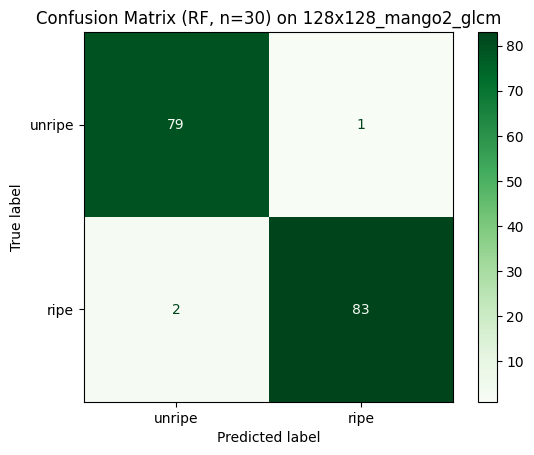

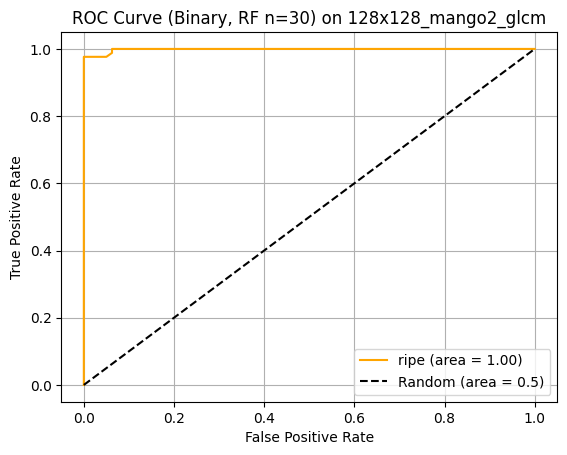


--- Random Forest (n_estimators=50) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9756    1.0000    0.9877        80
        ripe     1.0000    0.9765    0.9881        85

    accuracy                         0.9879       165
   macro avg     0.9878    0.9882    0.9879       165
weighted avg     0.9882    0.9879    0.9879       165

Training time: 0.0545 seconds


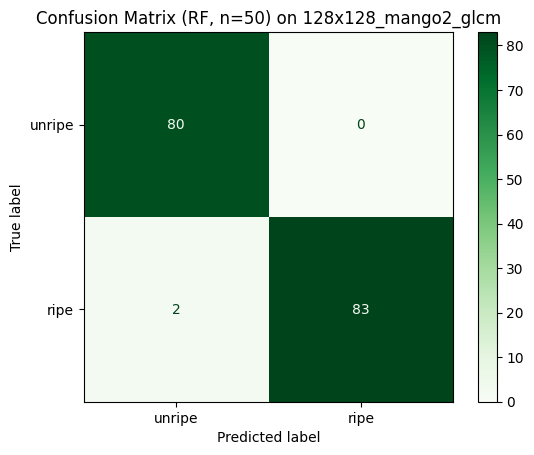

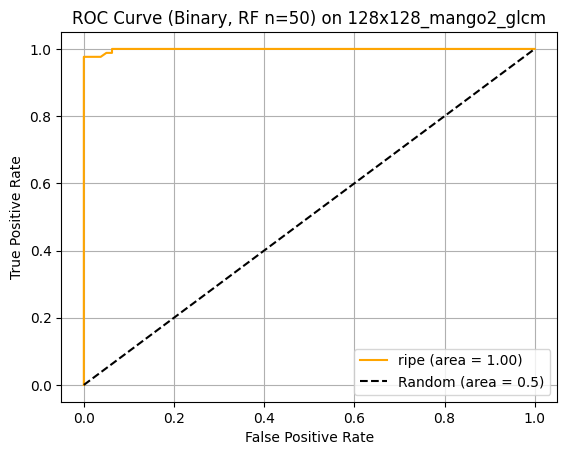


--- Random Forest (n_estimators=100) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9753    0.9875    0.9814        80
        ripe     0.9881    0.9765    0.9822        85

    accuracy                         0.9818       165
   macro avg     0.9817    0.9820    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.1235 seconds


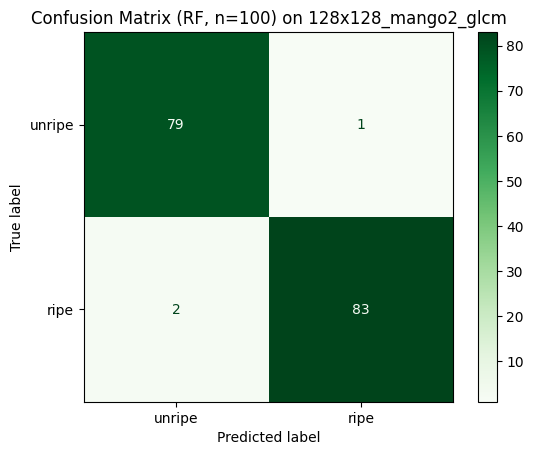

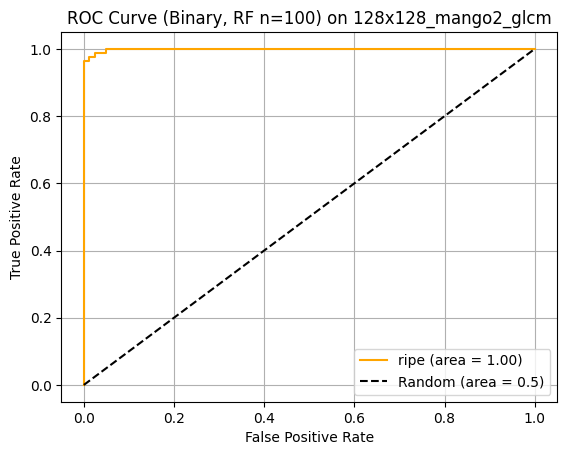


--- Random Forest (n_estimators=150) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9753    0.9875    0.9814        80
        ripe     0.9881    0.9765    0.9822        85

    accuracy                         0.9818       165
   macro avg     0.9817    0.9820    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.1817 seconds


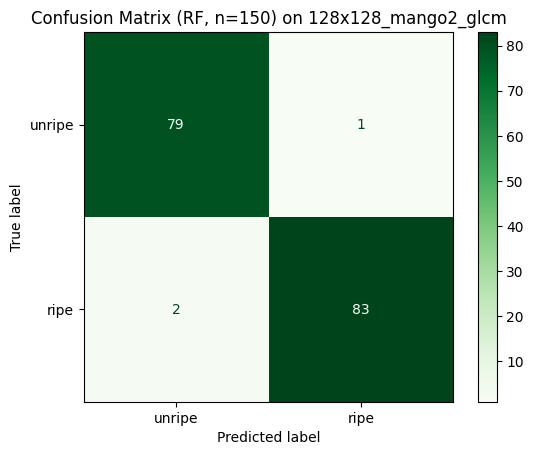

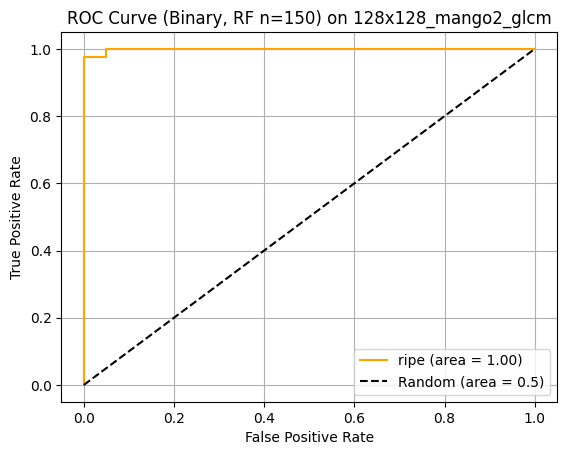


--- Random Forest (n_estimators=200) on 128x128_mango2_glcm ---
              precision    recall  f1-score   support

      unripe     0.9753    0.9875    0.9814        80
        ripe     0.9881    0.9765    0.9822        85

    accuracy                         0.9818       165
   macro avg     0.9817    0.9820    0.9818       165
weighted avg     0.9819    0.9818    0.9818       165

Training time: 0.2718 seconds


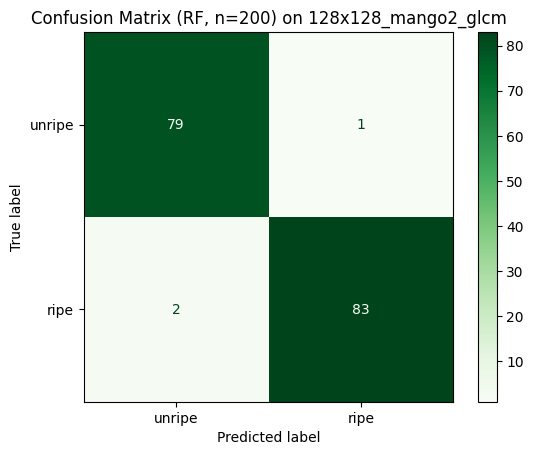

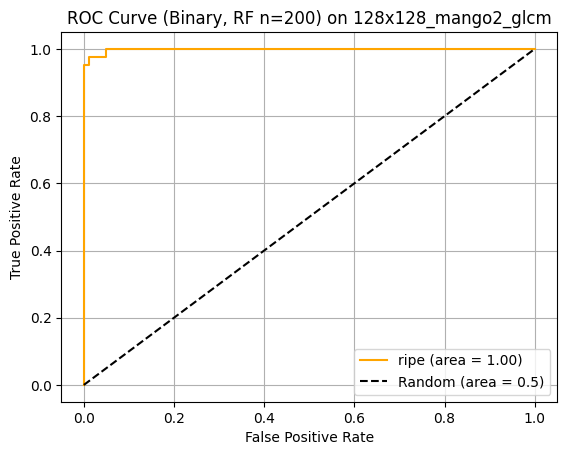

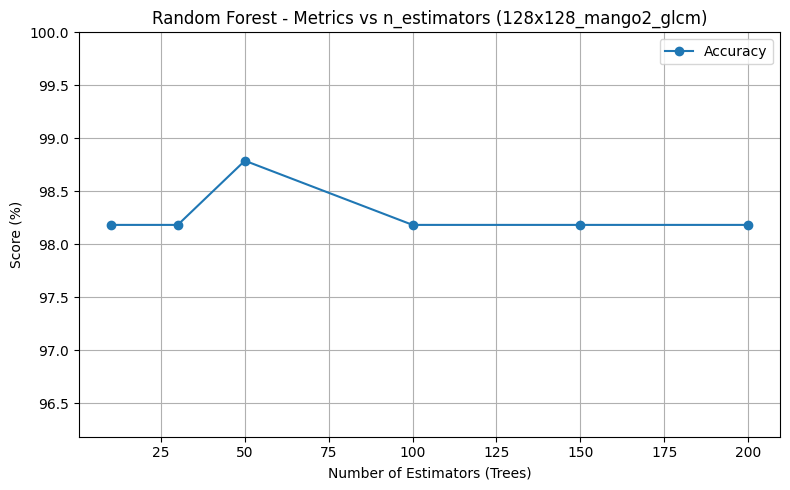

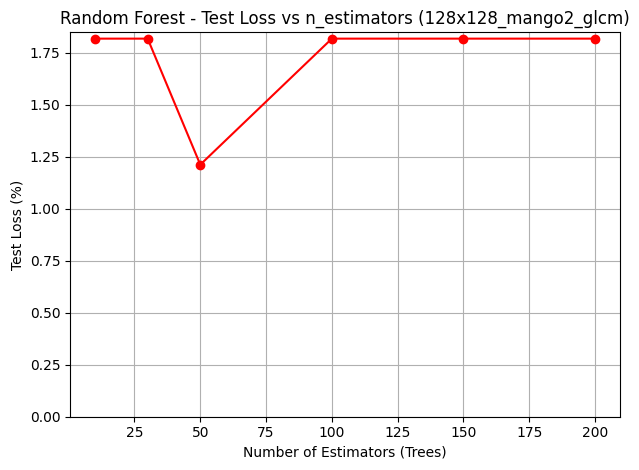

n_estimators  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)  \
0            10     98.181818      98.189568   98.181818     98.182085   
1            30     98.181818      98.189568   98.181818     98.182085   
2            50     98.787879      98.817443   98.787879     98.788146   
3           100     98.181818      98.189568   98.181818     98.182085   
4           150     98.181818      98.189568   98.181818     98.182085   
5           200     98.181818      98.189568   98.181818     98.182085   

   Test Loss (%)  Training Time (s)  
0       1.818182           0.012000  
1       1.818182           0.035136  
2       1.212121           0.054508  
3       1.818182           0.123509  
4       1.818182           0.181711  
5       1.818182           0.271758

In [27]:
from rf_classification import rf_classification

rf_classification(
    train_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_train.csv", 
    test_csv=r"C:\Users\User\Desktop\FYP\Dataset\mango_2\128x128_glcm_test.csv",
    feature="128x128_mango2_glcm",
    class_order=['unripe', 'ripe']
)
